# Biomakers paper

This notebook deals with
- phenotype analyses
- analyses and plots of PGS predictors
- training and analyses of BMRS predictors (here called BRS)
- evaluation of concatenated gBMRS predictors (here called BPRS)
- training and evaluation of BMRS ASCVD predictors
- evaluation of PGS ASCVD predictor

It is provided as reference to the paper *Machine Learning Prediction of Blood and Urine Biomarkers from Genotype and of Disease Risk from Biomarkers in the UK Biobank* published in Genes 2021. It does not provide any data and is not runnable as is. Some of the used packages may have been published on the groupd's GitHub (www.github.com/MSU-Hsu-Lab). The documentation is terse at most and the authors (E. Widen, L. Lello, T.G. Raben and S.D. Hsu) welcome any questions regarding the code.

# Imports

In [2]:
import re
import sys, os
from functools import reduce
import warnings
import pickle

import numpy as np
import pandas as pd
from time import time
from cycler import cycler

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl

import statsmodels.formula.api as smf
from scipy.stats import norm
from scipy import stats
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.utils import resample

sys.path.append("path/to/ModularPipeline")
import names_in_pipeline as nip
import pipeline_utilities as pu
import select_lasso_from_score as sls
from report_writer import ReportWriter
from phen_reader import PhenReader

In [3]:
import ewpkg.utils as ew

In [4]:
from sklearn.multioutput import (MultiOutputClassifier, MultiOutputRegressor)
from sklearn.linear_model import (LogisticRegression, Ridge, Lasso, LassoCV, MultiTaskLassoCV)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import (MLPRegressor)
from sklearn.metrics import (roc_auc_score)

In [5]:
from IPython.display import clear_output

In [6]:
pr = PhenReader()

In [7]:
dir_varsBiomarkersV2 = "VarsBiomarkersV2/"

# Helpers

In [11]:
def _z_score(data):
    if isinstance(data, (pd.Series, pd.DataFrame)):
        stds = np.nan_to_num(data.std())
        stds = np.where(stds == 0, 1, stds)
        return (data - data.mean())/stds
    
    # TODO: handle other data types
    raise Exception(f"type {type(data)} not implemented.")
    
def z_score(data, split_sex=False, split_ancestry=False, split_custom=None):
    # TODO: handle combinations of splits
    if isinstance(data, (pd.Series, pd.DataFrame)):
        if split_sex:
            return data.groupby(pr.sex["SEX"]).transform(_z_score)
        
        if split_ancestry:
            return data.groupby(pr.ancestry["ANCESTRY"]).transform(_z_score)
    
        return _z_score(data)
    # TODO: handle other data types
    raise Exception(f"type {type(data)} not implemented.")

In [12]:
def sibPairs_cc(cc_ser, condition=None, logic_op=None):
    '''cc_ser is series of cases status'''
    if condition is None:
        col = cc_ser.name
    else:
        col = condition

    col_0 = col + "_0"
    col_1 = col + "_1"
    sibs = pr.cohorts["sibPairs"].copy()
    sibs = sibs.set_index(0)
    sibs[col_0] = cc_ser.loc[cc_ser.index.isin(sibs.index)]
    sibs = sibs.reset_index().set_index(1)
    sibs[col_1] = cc_ser.loc[cc_ser.index.isin(sibs.index)]
    sibs = sibs.reset_index().dropna().astype(int)
    ret_order = [0, 1, col_0, col_1]
    if logic_op is None:
        return sibs[ret_order]
    elif callable(logic_op):
        mask = logic_op(sibs[col_0], sibs[col_1])
    elif logic_op in ['and', '&']:
        mask = sibs[col_0] & sibs[col_1]
    elif logic_op in ['or', '|']:
        mask = sibs[col_0] | sibs[col_1]
    elif logic_op in ['xor', '^']:
        mask = sibs[col_0] ^ sibs[col_1]
    else:
        raise Exception(f"Don't know what to do with logic_op {logic_op}")
    
    return sibs.loc[mask.astype(bool), ret_order]

Jupyter stuff

In [13]:
def print_tmp(*s):
    clear_output(wait=True)
    print(*s)

In [14]:
def my_globals(pattern):
    return [var for var in globals() if re.search(pattern, var)]

Project specific

In [15]:
def abbr_to_field(abbr):
    return fields.query("abbr == @abbr")["Field"].iloc[0]

In [16]:
def abbr_to_lou(abbr):
    row = fields.query('abbr == @abbr').iloc[0]
    return f"bioMarkers{row['lou_set']}.{row['lou_nr']}"

In [17]:
def to_lou_name(fieldID=None, string=None):
    if string is None and fieldID is not None:
        string = pr.field_info(fieldIDs=fieldID).loc[fieldID, "Field"]
    
    return re.sub(r"[ ()]", ".", string)

In [79]:
def dir_to_abbr(s):
    ds = re.search(r"(\d+)\.(\d+)", s)
    return fields.query(f"lou_set == {ds[1]} and lou_nr == {ds[2]}")["abbr"].iloc[0]

Plot functions

In [18]:
def my_qq(data, data2=None, center=True, scatter_kws={}, text=True):
    if not isinstance(data, pd.Series):
        raise Exception("Not implemented")
    
    x = np.concatenate((np.linspace(0, 4, 40), np.arange(4, 97), np.linspace(97, 100, 40)))/100
    if center:
        data = data - data.mean()
    if data2 is not None:
        if center:
            data2 = (data2 - data2.mean())
        data2q = data2.quantile(x).values
        dataq = data.quantile(x).values
        line_data = data.quantile(x).iloc[[0, -1]]
        mask = np.isfinite(dataq) & np.isfinite(data2q)
        r2 = r2_score(dataq[mask], data2q[mask])
    else:
        n = norm(loc=data.mean(), scale=data.std())
        data2q = data.quantile(x).values
        dataq = n.ppf(x)
        line_data = n.ppf(x[[1, -2]])
        mask = np.isfinite(dataq) & np.isfinite(data2q)
        r2 = r2_score(dataq[mask], data2q[mask])
        
    plt.scatter(dataq, data2q, s=10, **scatter_kws);
    plt.plot(line_data, line_data, 'gray', label='_nolegend_');
    if text:
        r2_color = 'k' if r2 > 0.97 else 'red'
        text_kws = {
            "fontsize": 10,
            "transform": plt.gca().transAxes,
        }
        # text
        if data2 is not None:
            string = f"x-std={data.std():.3f}\ny-std={data2.std():.3f}\n"
        else:
            string = ""
        string += f"r2={r2:.2f}"
        plt.text(1,
                 0.05, 
                 string,
                 horizontalalignment="right",
                 verticalalignment="bottom",
                 color=r2_color,
                 **text_kws);

In [19]:
def inch(*args):
    '''Convert pt to inch.'''
    p = 72.72
    if len(args) == 1:
        return args[0]/p
    return tuple(x/p for x in args)

def points(*args):
    '''Convert pt to inch.'''
    p = 72.72
    if len(args) == 1:
        return args[0]*p
    return tuple(x*p for x in args)

In [20]:
def hline(x1, x2, y, y2=None, color='0.6', linewidth=1, **plot_kws):
    if y2 is None:
        y2 = y
    plt.plot([x1, x2], [y, y2], ':', color=color, linewidth=linewidth, label='_nolegend_', **plot_kws)

In [21]:
ewinfo = ew.ewinfo

# Plot settings

In [22]:
plt.style.use('path/to/bloodOrder.mplstyle')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.facecolor'] = '#FFFFFF'

In [23]:
plt.rcParams['errorbar.capsize'] =3.0

In [24]:
plt.rcParams['legend.fontsize'] = 'small'

In [25]:
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [26]:
colors_ancestry = {
    'white': colors[0],
    'asian': colors[1],
    'black': colors[2],
    'chinese': colors[3],
}

In [27]:
hist_kws = {
    'bins': 100,
    'alpha': 0.4,
    'density': True
}

In [28]:
def my_mpl_height():
    return plt.gca().get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted()).height

In [29]:
def gcfigsize(pts=True):
    h = plt.gca().get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted()).height
    w = plt.gca().get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted()).width
    if pts:
        return points(w, h)

    return (w, h)

In [30]:
def adjust_x_lim(col):
    x1, x2 = plt.gca().get_xlim()
    d = x2 - x1
    std = swblood[col].std()
    m = swblood[col].mean()
    if d > 8 * std:
        plt.xlim([m - 3*std, m + 3*std])

Checking and installing fonts

In [32]:
plt.rcParams['font.family']

['Latin Modern Roman']

In [33]:
import matplotlib.font_manager as font_manager

font_dirs = ['path/to/Fonts/', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

In [34]:
[font_manager.fontManager.addfont(ff) for ff in font_files if 'alatino' in ff]

[None]

In [35]:
plt.rcParams['axes.unicode_minus'] = False

In [36]:
plt.rcParams['font.serif'] = ['Palatino', 'Latin Modern Roman', 'Times New Roman']

In [37]:
plt.rcParams['font.family'] = 'serif'

In [39]:
plt.rcParams['font.serif'].insert(0, 'Latin Modern Roman')
# plt.rcParams['font.serif'].insert(0, 'Palatino')
plt.rcParams['font.family'] = 'serif'

# Blood marker selection, directories and names

## Setup from Lou's stuff

In [40]:
dir_lou_biomarker1 = "path/to/biomarker1"
dir_lou_biomarker2 = "path/to/biomarker2"

Get maps from biomarker nr to name

In [43]:
with open(dir_lou_biomarker1 + "cohort-dictionary.txt", "r") as file:
    lines = file.readlines()

split_lines = [l.strip().split() for l in lines]
biomarkers1_map = {int(l[0]) : l[1].replace('"', '') for l in split_lines}

In [44]:
with open(dir_lou_biomarker2 + "biomarkers2.names.txt", "r") as file:
    lines = [l.strip() for l in file.readlines()]

biomarkers2_map = {n + 1 : l.replace('"', '') for n, l in enumerate(lines[1:])}

inverse maps

In [48]:
biomarkers1_mapi = {v : k for k, v in biomarkers1_map.items()}
biomarkers2_mapi = {v : k for k, v in biomarkers2_map.items()}

## Get UKB field names

Cut from Lou's extractAssay.R files

In [49]:
# all_fields_pattern = "White blood cell (leukocyte) count|Red blood cell (erythrocyte) count|Haemoglobin concentration|Haematocrit percentage|Platelet count|Platelet crit|Lymphocyte count|Monocyte count|Neutrophill count|Eosinophill count|Basophill count|Nucleated red blood cell count|Reticulocyte count|High light scatter reticulocyte count|Microalbumin in urine|Creatinine (enzymatic) in urine|Potassium in urine|Sodium in urine|Alanine aminotransferase|Albumin|Alkaline phosphatase|Apolipoprotein A|Apolipoprotein B|Aspartate aminotransferase|C-reactive protein|Calcium|Cholesterol|Creatinine|Cystatin C|Direct bilirubin|Gamma glutamyltransferase|Glucose|Glycated haemoglobin  HbA1c |HDL cholesterol|IGF 1|LDL direct|Lipoprotein A|Oestradiol|Phosphate|Rheumatoid factor|SHBG|Testosterone|Total bilirubin|Total protein|Triglycerides|Urate|Urea|Vitamin D"
# all_fields_pattern = "White blood cell (leukocyte) count$|Red blood cell (erythrocyte) count$|Haemoglobin concentration$|Haematocrit percentage$|Platelet count$|Platelet crit$|Lymphocyte count$|Monocyte count$|Neutrophill count$|Eosinophill count$|Basophill count$|Nucleated red blood cell count$|Reticulocyte count$|High light scatter reticulocyte count$|Microalbumin in urine$|Creatinine (enzymatic) in urine$|Potassium in urine$|Sodium in urine$|Alanine aminotransferase$|Albumin$|Alkaline phosphatase$|Apolipoprotein A$|Apolipoprotein B$|Aspartate aminotransferase$|C-reactive protein$|Calcium$|Cholesterol$|Creatinine$|Cystatin C$|Direct bilirubin$|Gamma glutamyltransferase$|Glucose$|Glycated haemoglobin  HbA1c $|HDL cholesterol$|IGF 1$|LDL direct$|Lipoprotein A$|Oestradiol$|Phosphate$|Rheumatoid factor$|SHBG$|Testosterone$|Total bilirubin$|Total protein$|Triglycerides$|Urate$|Urea$|Vitamin D$"
all_fields_pattern = "White blood cell \(leukocyte\) count$|Red blood cell \(erythrocyte\) count$|Haemoglobin concentration$|Haematocrit percentage$|Platelet count$|Platelet crit$|Lymphocyte count$|Monocyte count$|Neutrophill count$|Eosinophill count$|Basophill count$|Nucleated red blood cell count$|Reticulocyte count$|High light scatter reticulocyte count$|Microalbumin in urine$|Creatinine \(enzymatic\) in urine$|Potassium in urine$|Sodium in urine$|Alanine aminotransferase$|Albumin$|Alkaline phosphatase$|Apolipoprotein A$|Apolipoprotein B$|Aspartate aminotransferase$|C-reactive protein$|Calcium$|Cholesterol$|Creatinine$|Cystatin C$|Direct bilirubin$|Gamma glutamyltransferase$|Glucose$|Glycated haemoglobin \(HbA1c\)$|HDL cholesterol$|IGF-1$|LDL direct$|Lipoprotein A$|Oestradiol$|Phosphate$|Rheumatoid factor$|SHBG$|Testosterone$|Total bilirubin$|Total protein$|Triglycerides$|Urate$|Urea$|Vitamin D$"

In [50]:
ukb_fields = pr.field_info(field_pattern=all_fields_pattern)

In [51]:
lou_fields = pd.DataFrame({
    "lou_name": ["White.blood.cell..leukocyte..count", "Red.blood.cell..erythrocyte..count", "Haemoglobin.concentration", "Haematocrit.percentage", "Platelet.count", "Platelet.crit", "Lymphocyte.count", "Monocyte.count", "Neutrophill.count", "Eosinophill.count", "Basophill.count", "Nucleated.red.blood.cell.count", "Reticulocyte.count", "High.light.scatter.reticulocyte.count", "Microalbumin.in.urine", "Creatinine..enzymatic..in.urine", "Potassium.in.urine", "Sodium.in.urine", "Alanine.aminotransferase", "Albumin", "Alkaline.phosphatase", "Apolipoprotein.A", "Apolipoprotein.B", "Aspartate.aminotransferase", "C.reactive.protein", "Calcium", "Cholesterol", "Creatinine", "Cystatin.C", "Direct.bilirubin", "Gamma.glutamyltransferase", "Glucose", "Glycated.haemoglobin..HbA1c.", "HDL.cholesterol", "IGF.1", "LDL.direct", "Lipoprotein.A", "Oestradiol", "Phosphate", "Rheumatoid.factor", "SHBG", "Testosterone", "Total.bilirubin", "Total.protein", "Triglycerides", "Urate", "Urea", "Vitamin.D"]
})

def get_lou_nr(field_ser):
    ret = [ 
        [1, biomarkers1_mapi[v]] if v in biomarkers1_mapi
           else [2, biomarkers2_mapi[v]]
           for v in field_ser.to_list()]
    return np.array(ret)

lou_fields["lou_set"] = get_lou_nr(lou_fields["lou_name"])[:, 0]
lou_fields["lou_nr"] = get_lou_nr(lou_fields["lou_name"])[:, 1]

In [52]:
def clean_lou_name(ser):
    ret = []
    for v in ser.values:
        tmp = re.sub(r"\.\.(.+?)\.\.", r" (\1) ", v)
        tmp = re.sub(r"\.", " ", tmp)
        tmp = re.sub("C reac", "C-reac", tmp)
        tmp = re.sub(r"  HbA1c ", r" (HbA1c)", tmp)
        tmp = re.sub("IGF 1", "IGF-1", tmp)
        ret.append(tmp.strip())
    return ret
lou_fields["clean_name"] = clean_lou_name(lou_fields["lou_name"])

In [53]:
lou_fields["abbr"] = ["white", "red", "heam", "heamCrit", "plat", "platCrit", "lymph", "mono", "nuet", "eosi", "baso", "nucred", "reti", "HLreti", "micro", "creaUr", "potas", "sodium", "alan", "albu", "alka", "apoA", "apoB", "aspa", "creac", "calc", "chol", "crea", "cystC", "dbili", "gamma", "gluc", "glychaem", "hdl", "igf1", "ldl", "lipoA", "oest", "phos", "rheu", "shbg", "testo", "tbili", "tprot", "trig", "urate", "urea", "vitD"]

In [54]:
new_abbr_map = {
"alan": "ALT",
"albu": "ALB",
"alka": "ALP",
"aspa": "AST",
"apoA": "apoA",
"apoB": "apoB",
"baso": "ABC",
"calc": "Ca",
"chol": "chol",
"crea": "Cr",
"creac": "CRP",
"creaUr": "UCR",
"cystC": "CysC",
"dbili": "DBil",
"eosi": "AEC",
"gamma": "GGT",
"gluc": "gluc",
"glychaem": "HbA1c",
"hdl": "HDL",
"heam": "Hgb",
"heamCrit": "HCT",
"HLreti": "HLSR",
"igf1": "IGF1",
"ldl": "LDL",
"lipoA": "LpA",
"lymph": "ALC",
"micro": "MA",
"mono": "AMC", 
"nucred": "NRBC",
"nuet": "ANC",
"oest": "E2",
"phos": "phos",
"plat": "PLT",
"platCrit": "PCT",
"potas": "K",
"red": "RBC",
"reti": "RET",
"rheu": "RF",
"shbg": "SHBG",
"sodium": "Na",
"tbili": "TBil",
"testo": "T",
"tprot": "TP",
"trig": "TG",
"urate": "UA",
"urea": "U",
"vitD": "vitD",
"white": "WBC"
}

lou_fields["new_abbr"] = [new_abbr_map[a] for a in lou_fields['abbr'] ]

In [55]:
ancestry_map = {"white": "European", "asian": "South Asian", "chinese": "East Asian", "black": "African"}

In [56]:
def cond_to_print(cond):
    ret = re.sub(r"_.*?(\d?)$", r" \1", cond)
    return ret.upper() if ret == 'cad' else ret

In [57]:
fields = ukb_fields.reset_index().merge(lou_fields, left_on="Field", right_on="clean_name", how='outer').\
    drop(columns=["clean_name", "Array"]).set_index("FieldID")

In [58]:
fields = fields.loc[fields.index < 99999] # get rid of diet duplicates

In [59]:
fields.shape

(48, 7)

### Biomarkers 3

In [60]:
biomarkers3_fieldIDs = [30220, 30210, 30290, 30280, 30180, 30050, 30060, 30040, 30100, 30260, 30270, 30190, 30200, 30230, 30110, 30070, 30240]

In [61]:
biomarkers3_abbrs = pd.Series({
    30220: "ABCp",
    30210: "AECp",
    30290: "HLSRp",
    30280: "IRF" ,
    30180: "ALCp",
    30050: "MCH" ,
    30060: "MCHC",
    30040: "MCV" ,
    30100: "MPV" ,
    30260: "MRV" ,
    30270: "MSCV",
    30190: "AMCp",
    30200: "ANCp",
    30230: "NRBCp",
    30110: "PDW" ,
    30070: "RDW" ,
    30240: "RETp",
}
)

In [322]:
for ab in biomarkers3_abbrs:
    new_abbr_map[ab] = ab

In [62]:
_fields3 = pr.field_info(fieldIDs=biomarkers3_fieldIDs).drop(columns="Array")

In [63]:
_, fields3 = fields.align(_fields3, axis=1)

In [64]:
fields3["abbr"] = biomarkers3_abbrs
fields3["new_abbr"] = biomarkers3_abbrs
fields3["lou_set"] = 3

In [65]:
fields3 = fields3.sort_values("abbr")
fields3["lou_nr"] = range(1, len(fields3) + 1)

In [66]:
fields3["lou_name"] = [to_lou_name(fieldID=fid) for fid in fields3.index]

In [67]:
fields = fields.append(fields3)

In [68]:
# pickle.dump(fields, open(dir_varsBiomarkersV2 + "fields.p", "wb"))

### Make latex table

In [69]:
latex_kws = {"index": False}

# Quick load

In [70]:
blood2 = pickle.load(open(dir_varsBiomarkersV2 + "blood.p", "rb"))

In [71]:
# blood = blood2[[col for col in blood2 if col in fields.query("lou_set != 3")["abbr"].tolist()]]

In [72]:
additional = pickle.load(open(dir_varsBiomarkersV2 + "additional.p", "rb"))

In [73]:
cc = pd.read_csv(dir_varsBiomarkersV2 + "cc.csv", sep=" ").set_index("eid")

# Pheno analyses

In [59]:
# ablood = blood.copy()
# pr.assign_ancestry(ablood)

In [60]:
# wblood = prune(blood, "ANCESTRY == 'white'") #blood.loc[ablood["ANCESTRY"] == 'white']

In [ ]:
wblood2 = pr.prune(blood2, "ANCESTRY == 'white'") #blood.loc[ablood["ANCESTRY"] == 'white']

## Pheno sex differences

In [76]:
eids_to_keep = pr.sex.index[pr.sex["SEX"].isin([0, 1])]
swblood = wblood2.loc[wblood2.index.isin(eids_to_keep)].copy()

In [77]:
sg = swblood.groupby(pr.sex["SEX"])

In [78]:
phen_lens = [
   [405735, "bioMarkers1.10"],
   [405735, "bioMarkers1.11"],
   [405735, "bioMarkers1.12"],
   [405536, "bioMarkers1.13"],
   [399797, "bioMarkers1.14"],
   [399555, "bioMarkers1.15"],
   [129280, "bioMarkers1.16"],
   [406454, "bioMarkers1.17"],
   [405608, "bioMarkers1.18"],
   [405587, "bioMarkers1.19"],
   [406450, "bioMarkers1.2"],
   [406455, "bioMarkers1.3"],
   [406454, "bioMarkers1.4"],
   [406455, "bioMarkers1.5"],
   [406451, "bioMarkers1.6"],
   [406263, "bioMarkers1.7"],
   [405735, "bioMarkers1.8"],
   [405735, "bioMarkers1.9"],
   [354512, "bioMarkers2.10"],
   [354648, "bioMarkers2.11"],
   [302753, "bioMarkers2.12"],
   [354497, "bioMarkers2.13"],
   [325164, "bioMarkers2.14"],
   [354715, "bioMarkers2.15"],
   [325364, "bioMarkers2.16"],
   [352844, "bioMarkers2.17"],
   [354056, "bioMarkers2.18"],
   [282560, "bioMarkers2.19"],
   [354548, "bioMarkers2.1"],
    [55693, "bioMarkers2.20"],
   [324910, "bioMarkers2.21"],
    [31224, "bioMarkers2.22"],
   [322452, "bioMarkers2.23"],
   [321936, "bioMarkers2.24"],
   [353257, "bioMarkers2.25"],
   [325163, "bioMarkers2.26"],
   [354401, "bioMarkers2.27"],
   [354244, "bioMarkers2.28"],
   [354448, "bioMarkers2.29"],
   [325517, "bioMarkers2.2"],
   [112065, "bioMarkers2.30"],
   [354693, "bioMarkers2.3"],
   [323571, "bioMarkers2.4"],
   [352981, "bioMarkers2.5"],
   [353421, "bioMarkers2.6"],
   [353928, "bioMarkers2.7"],
   [112065, "bioMarkers2.8"],
   [354679, "bioMarkers2.9"],
    [406373, "bioMarkers3.10"],
    [406365, "bioMarkers3.11"],
    [399872, "bioMarkers3.12"],
    [399650, "bioMarkers3.13"],
    [405452, "bioMarkers3.14"],
    [406181, "bioMarkers3.15"],
    [406373, "bioMarkers3.16"],
    [399872, "bioMarkers3.17"],
    [405659, "bioMarkers3.1"],
    [405659, "bioMarkers3.2"],
    [405659, "bioMarkers3.3"],
    [405659, "bioMarkers3.4"],
    [405659, "bioMarkers3.5"],
    [399650, "bioMarkers3.6"],
    [399649, "bioMarkers3.7"],
    [406370, "bioMarkers3.8"],
    [406368, "bioMarkers3.9"],
]

In [80]:
phen_lens_ser = pd.Series([i[0] for i in phen_lens], index=[dir_to_abbr(i[1]) for i in phen_lens])

In [81]:
bin_map = {
    "alan": 300,
    "albu": 100,
    "alka": 200,
    "apoA": 100,
    "apoB": 100,
    "aspa": 300,
    "baso": 300,
    "calc": 150,
    "chol": 100,
    "crea": 300,
    "creac": 150,
    "creaUr": 100,
    "cystC": 200,
    "dbili": 300,
    "eosi": 200,
    "gamma": 150,
    "gluc": 150,
    "glychaem": 200,
    "hdl": 100,
    "heam": 100,
    "heamCrit": 100,
    "HLreti": 200,
    "igf1": 100,
    "ldl": 100,
    "lipoA": 100,
    "lymph": 300,
    "micro": 400,
    "mono": 300,
    "nucred": 500,
    "nuet": 150,
    "oest": 200,
    "phos": 150,
    "plat": 150,
    "platCrit": 150,
    "potas": 100,
    "red": 150,
    "reti": 300,
    "rheu": 100,
    "shbg": 100,
    "sodium": 100,
    "tbili": 200,
    "testo": 100,
    "tprot": 100,
    "trig": 100,
    "urate": 100,
    "urea": 100,
    "vitD": 100,
    "white": 300,
    "IRF": 90,
    "MPV": 100,
    "PDW": 60,
}

Plot all phenotype distributions

ABCp 1 0
AECp 2 1
alan 3 2
albu 4 3
ALCp 5 4
alka 6 5
AMCp 7 6
ANCp 8 7
apoA 9 8
apoB 10 9
aspa 11 10
baso 12 11
calc 13 12
chol 14 13
crea 15 14
creac 16 15
creaUr 17 16
cystC 18 17
dbili 19 18
eosi 20 19
gamma 21 20
gluc 22 21
glychaem 23 22
hdl 24 23
save and new fig
heam 1 24
heamCrit 2 25
HLreti 3 26
HLSRp 4 27
igf1 5 28
IRF 6 29
ldl 7 30
lipoA 8 31
lymph 9 32
MCH 10 33
MCHC 11 34
MCV 12 35
micro 13 36
mono 14 37
MPV 15 38
MRV 16 39
MSCV 17 40
NRBCp 18 41
nucred 19 42
nuet 20 43
oest 21 44
PDW 22 45
phos 23 46
plat 24 47
save and new fig
platCrit 1 48
potas 2 49
RDW 3 50
red 4 51
reti 5 52
RETp 6 53
rheu 7 54
shbg 8 55
sodium 9 56
tbili 10 57
testo 11 58
tprot 12 59
trig 13 60
urate 14 61
urea 15 62
vitD 16 63
white 17 64


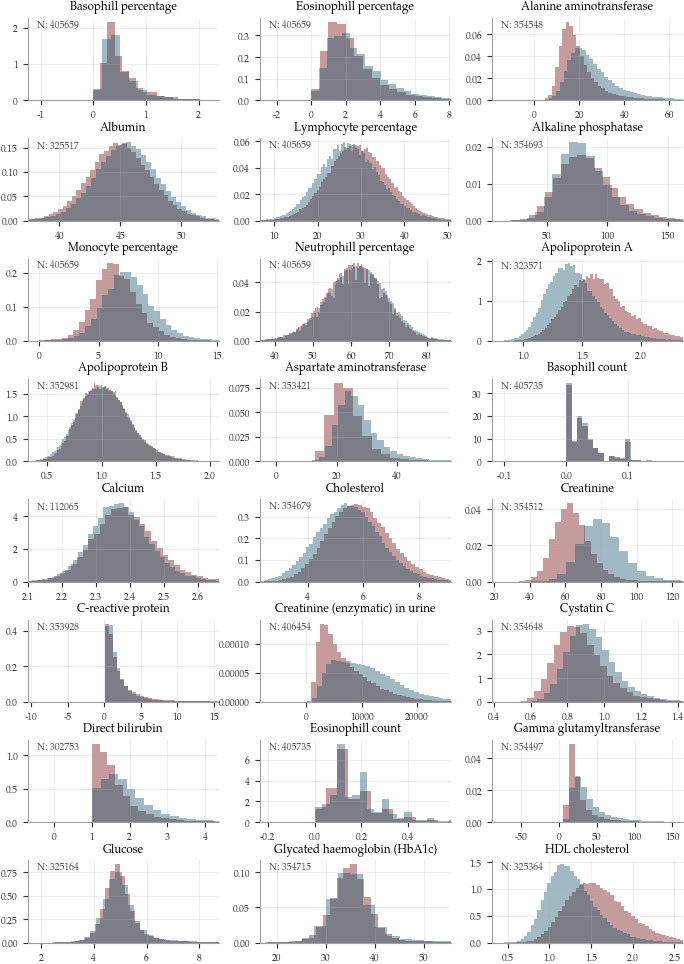

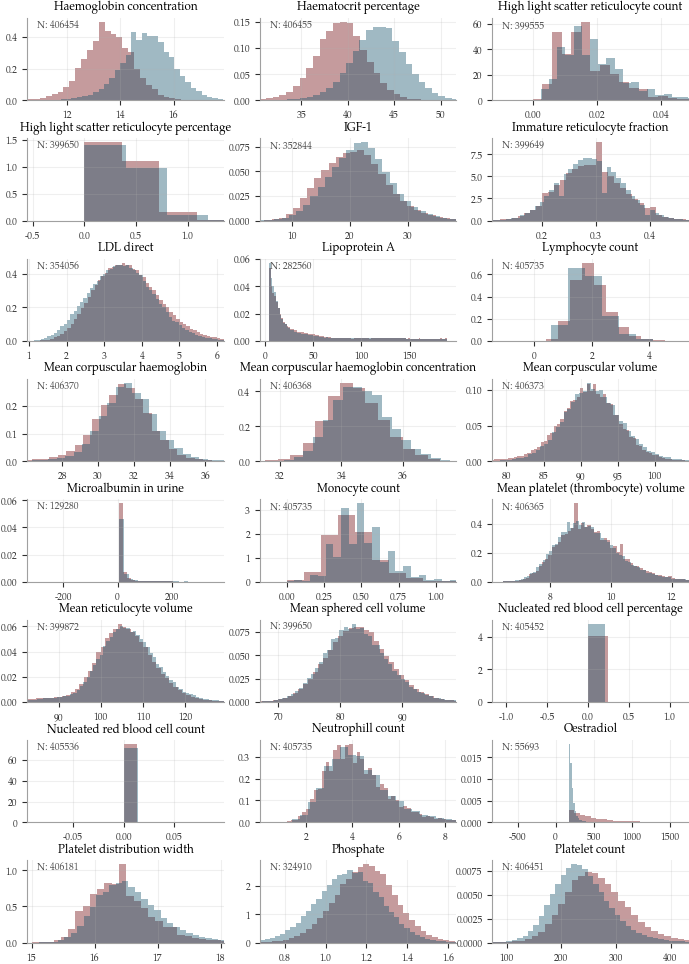

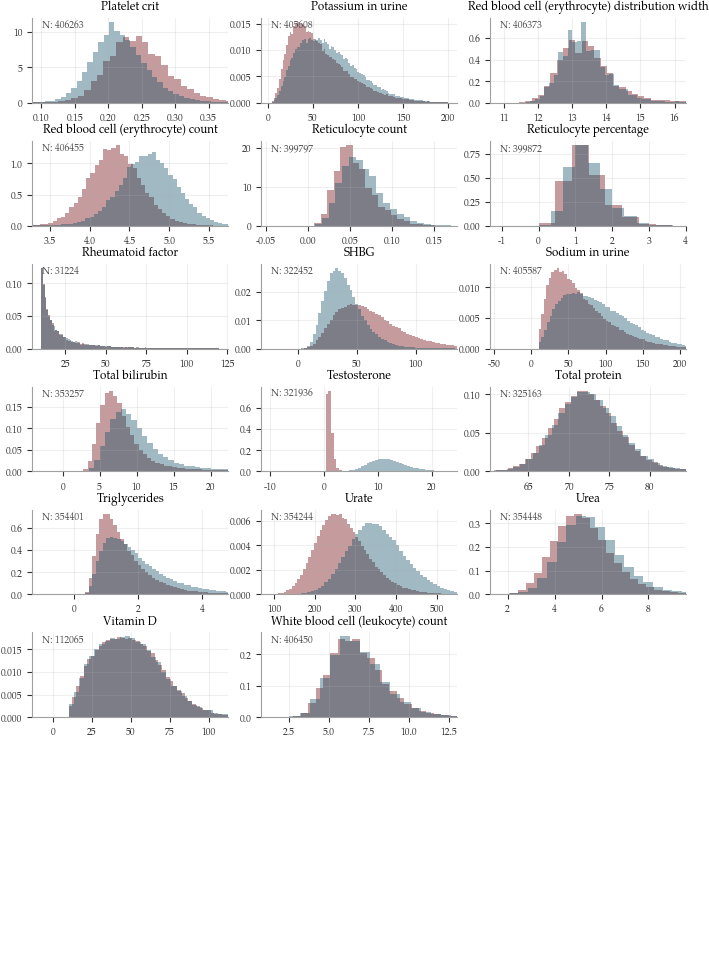

In [304]:
lhist_kws = {'alpha': 0.4, 'density': True}
n_rows = 8
fsize = inch(500, 700)
fig, axs = plt.subplots(n_rows, 3, figsize=fsize)
ax_lim = 23
for n, col in enumerate(swblood.columns.sort_values(key=lambda s: s.str.lower())):
    _n_ax = n%(ax_lim+1) + 1
    print(col, _n_ax, n)
#     ax = plt.subplot(n_rows, 3, n+1 if n <= ax_lim else n - ax_lim)
    ax = plt.subplot(n_rows, 3, _n_ax)
    _bins = bin_map[col] if col in bin_map else 200
    sg[col].hist(**lhist_kws, bins=_bins);
    adjust_x_lim(col)
    plt.text(0.05, .98, "N: " + str(phen_lens_ser.loc[col]),
             color='0.3',
             fontsize='x-small',
             ha='left', va='top',
            transform=ax.transAxes)
    plt.title(f"{abbr_to_field(col)}", fontsize='small')
#     plt.title(col, fontsize='small')
    if _n_ax == ax_lim + 1:
        print("save and new fig")
        plt.tight_layout(pad=0, h_pad=0, w_pad=0)
        _save_fig_num = int(n/ax_lim)
        fig.savefig(f"FiguresV2/supp_phen_distributions2.{_save_fig_num}.pdf")
        fig, axs = plt.subplots(n_rows, 3, figsize=fsize)

for n in range(_n_ax + 1, ax_lim + 2):
    ax = plt.subplot(n_rows, 3, n)
    ax.axis("off")
    
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
fig.savefig(f"FiguresV2/supp_phen_distributions2.{_save_fig_num + 1}.pdf")

## Phen - age dependence

In [305]:
bag = blood2.groupby(additional["AGE"].astype(int))

In [306]:
phen_mean_by_age = bag.mean()
phen_norm_mean_by_age = phen_mean_by_age/phen_mean_by_age.mean()

In [307]:
_df = phen_norm_mean_by_age.rename(columns=new_abbr_map).sort_index(axis=1, key=lambda s: s.str.lower())

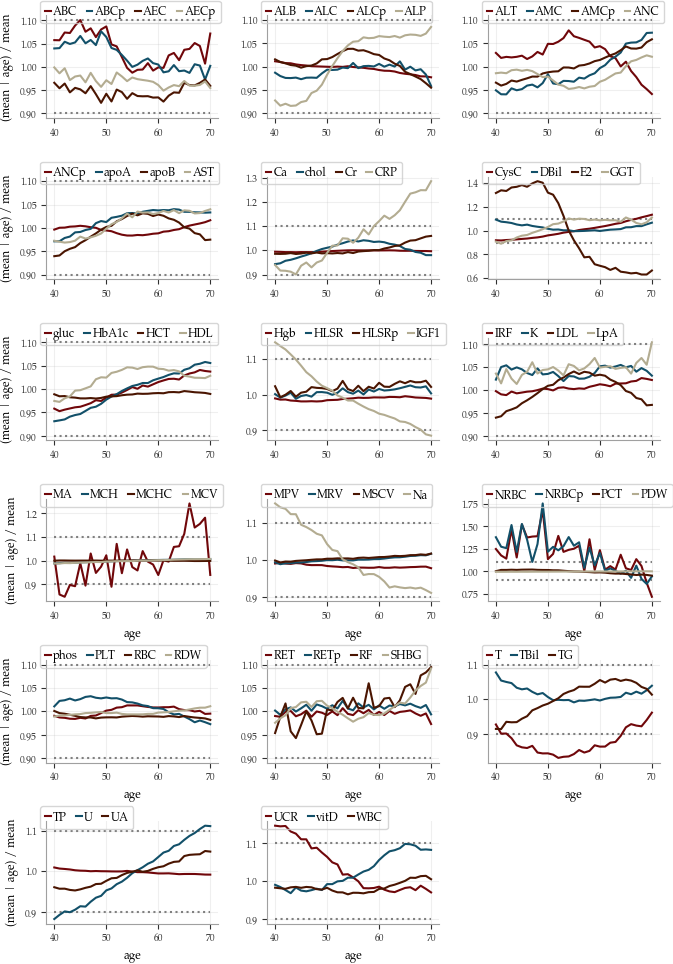

In [317]:
fsize = inch(500, 700)
n_plots = int(np.ceil(_df.shape[1]/4))
n_cols = 3
n_rows = int(np.ceil(n_plots/n_cols))
# plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
fig, axs = plt.subplots(n_rows, n_cols, figsize=fsize, sharex=True)
for n, df in enumerate(np.array_split(_df.T, n_plots)):
    ax = plt.subplot(n_rows, n_cols, n + 1)
    x = [40, 70]
    plt.plot(x, [1.1, 1.1], ':', color='0.5')
    plt.plot(x, [0.9, 0.9], ':', color='0.5')
    df.T.loc[40:70].plot(ax=ax)
    plt.legend(ncol=4, handlelength=0.5, handletextpad=0.2, columnspacing=.8,
              loc='upper left', bbox_to_anchor=(-0.07, .70, 0.5, 0.5))
#               loc='upper left', bbox_to_anchor=(.5, 1, 0.5, 0.5))
#     ax.set_title("")
    plt.xlabel("")
    if n > 8:
        plt.xlabel("age")
    if n%3 ==0 :
        plt.ylabel(r"(mean | age) / mean")
#     if n > 1 :
#         break
axs[5, 2].clear()
axs[5, 2].axis("off")
plt.tight_layout(pad=0, h_pad=0.3, w_pad=0)

In [318]:
fig.savefig("FiguresV2/supp_phen_age.pdf")

# PGS results

## Loading scores

In [78]:
dir_lou_siblingGP = "path/to/dir/with/pgs"

In [81]:
def score_files_to_dataframe(input_dir, files):
    read_kws = {"sep": " ", "header": None}
    files_map = {n: [] for n in range(1,6)}
    for f in files:
        files_map[int(f[-5])].append(f)
    
    dfs = []
    for k, fs in files_map.items():
        if not fs:
            continue
        pred_dfs = [pd.read_csv(input_dir + f, **read_kws) for f in fs]
        df = pd.concat(pred_dfs)
        df.columns = ["eid", "YOB", "SEX", "PHEN", f"SCORE_{k}"]
        dfs.append(df)
    
    ret = reduce(lambda df1, df2: 
                  df1.merge(df2.drop(columns=["YOB", "SEX", "PHEN"]), on="eid")
                 , dfs).set_index("eid")
    ret["ANCESTRY"] = pr.ancestry["ANCESTRY"]
    return ret

def abbr_from_filename(filename):
    lou_set, lou_nr = re.search(f"\D*([123])\.(\d+)", filename).group(1, 2)
    abbr = fields.loc[(fields["lou_set"] == int(lou_set)) & (fields["lou_nr"] == int(lou_nr)), "abbr"]
    return abbr.iloc[0]

In [82]:
biomarker_dirs = ["all", "PGS-dir paths", "as", "list"]

In [84]:
scores_lou_map = {}
pattern = r"score.*\d\.txt$"
for d in biomarker_dirs:
    abbr = abbr_from_filename(d)
    print_tmp("Processing", d.split("/")[-2:], f"--- {abbr}")
    
    files = nip.all_files_in_dir_containing(d, pattern)
    scores_lou_map[abbr] = score_files_to_dataframe(d, files)

Processing ['bioMarkers3.17', ''] --- RETp


In [ ]:
start = time()
scores = pd.concat(scores_lou_map)
scores["bad_mean"] = scores.filter(regex=f"SCORE_\d").mean(axis=1)
print(time() - start)
scores.head()

In [87]:
scores["SCORE_mean"] = z_score(scores.filter(regex=f"SCORE_\d")).mean(axis=1)

In [89]:
scores = pr.prune_withdrawals(scores)
scores.index.names = ['abbr', 'eid']

## Analyze scores

In [90]:
sg = scores.groupby([pd.Grouper(level=0), "ANCESTRY"])

### Score correlations

In [380]:
score_cols = [f"SCORE_{n}" for n in range(1, 6)]

In [198]:
def score_corr_fun(df):
    return df.filter(regex=r"PHEN|SCORE").corr()

In [199]:
score_corrs = sg.apply(score_corr_fun)

In [200]:
score_corrs_condensed = score_corrs["PHEN"].unstack().filter(regex=r"SCORE_\d").agg(["mean", "std"], axis=1)

In [201]:
s_idx = score_corrs_condensed.loc[(slice(None), "white"), :].sort_values("mean", ascending=False).index.get_level_values(0)
score_corrs_condensed = score_corrs_condensed.loc[s_idx]

Score correlations for each blood marker and ancestry, sorted according to correlations on whites.

In [202]:
score_corrs_condensed_mat = score_corrs_condensed.unstack().swaplevel(0, 1, axis=1).sort_index(axis=1).\
    sort_values(("white", "mean"), ascending=False)

In [203]:
col_order = ["white", "asian", "chinese", "black"]
tmp_mean = score_corrs_condensed_mat.loc[:, (slice(None), 'mean')].droplevel(level=1, axis=1)[col_order]
tmp_std = score_corrs_condensed_mat.loc[:, (slice(None), 'std')].droplevel(level=1, axis=1)[col_order]

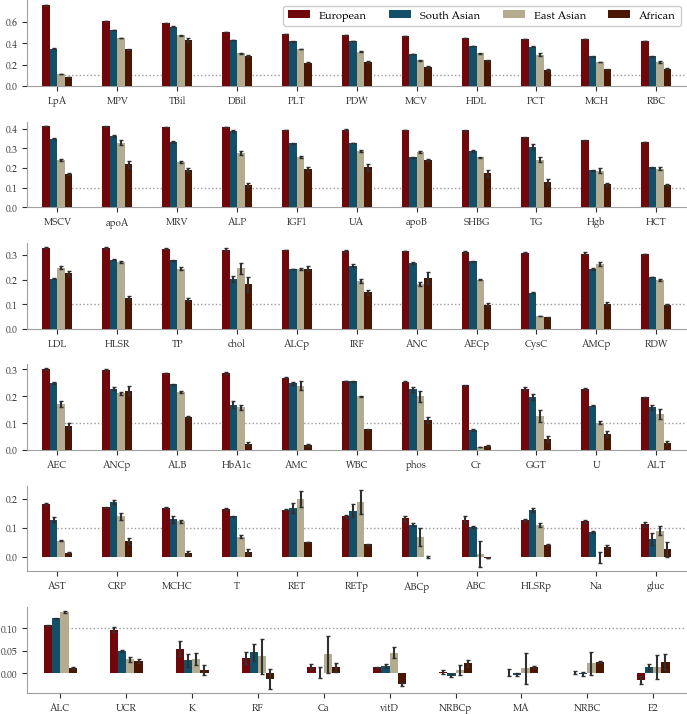

In [387]:
n_axes = 6
n_traits = len(scores.index.levels[0])
n_per_row = int(np.ceil(n_traits/n_axes))
tmp_colors = [colors_ancestry[a] for a in col_order]
fig, axs = plt.subplots(n_axes, 1, figsize=inch(520, 90 * n_axes))
plot_idx = np.arange(0, n_traits + n_traits%n_per_row, n_per_row)
for n in range(n_axes):
    plt.sca(axs[n])
    line_y = 0.1
    hline(0, 11.5, line_y)
    tmp_mean.rename(index=new_abbr_map, columns=ancestry_map).iloc[plot_idx[n]:plot_idx[n+1]].plot.bar(
        ax=axs[n], legend=False, grid=False, color=tmp_colors, zorder=3, rot=0,
        yerr=tmp_std.rename(index=new_abbr_map, columns=ancestry_map)[plot_idx[n]:plot_idx[n+1]], capsize=1.7);
    plt.locator_params(axis='y', nbins=5)

    if n == 0:
        plt.legend(fontsize=8, ncol=4, framealpha=1, facecolor='white')

plt.tight_layout()

In [388]:
# fig.savefig("FiguresV2/pgs_correlation_by_ancestry.pdf")

#### Correlation table

In [389]:
corr_tab = tmp_mean.combine(tmp_std, lambda s1, s2: s1.combine(s2, lambda x, y: f"{x:.3f} ± {y:.3f}"))

In [390]:
corr_tab = corr_tab.rename(index=new_abbr_map, columns=ancestry_map).sort_index(key=lambda s: s.str.lower()).reset_index()

In [394]:
print(pd.concat([corr_tab.iloc[:24].reset_index(drop=True), corr_tab.iloc[24:].reset_index(drop=True)], axis=1).to_latex(**latex_kws))

\begin{tabular}{llllllllll}
\toprule
index &        European &    South Asian &     East Asian &         African &  index &       European &     South Asian &      East Asian &         African \\
\midrule
  ABC &   0.127 ± 0.011 &  0.103 ± 0.003 &  0.009 ± 0.046 &  -0.006 ± 0.000 &   gluc &  0.112 ± 0.008 &   0.060 ± 0.020 &   0.090 ± 0.016 &   0.025 ± 0.026 \\
 ABCp &   0.132 ± 0.008 &  0.110 ± 0.006 &  0.068 ± 0.032 &  -0.002 ± 0.003 &  HbA1c &  0.286 ± 0.004 &   0.169 ± 0.013 &   0.160 ± 0.009 &   0.024 ± 0.005 \\
  AEC &   0.302 ± 0.002 &  0.250 ± 0.002 &  0.172 ± 0.010 &   0.089 ± 0.011 &    HCT &  0.332 ± 0.001 &   0.204 ± 0.003 &   0.196 ± 0.009 &   0.115 ± 0.005 \\
 AECp &   0.312 ± 0.003 &  0.274 ± 0.002 &  0.200 ± 0.003 &   0.097 ± 0.009 &    HDL &  0.451 ± 0.001 &   0.372 ± 0.002 &   0.305 ± 0.004 &   0.240 ± 0.005 \\
  ALB &   0.287 ± 0.001 &  0.244 ± 0.001 &  0.217 ± 0.004 &   0.123 ± 0.004 &    Hgb &  0.341 ± 0.003 &   0.188 ± 0.003 &   0.187 ± 0.013 &   0.117 ± 0.006 \\


### Calibrated?

In [193]:
def fit_ser(phen, ser):
    if ser.isna().any():
        return [np.nan, np.nan]
    df = pd.concat([phen, ser], axis=1).dropna()
    l = LinearRegression(fit_intercept=True)
    return l.fit(np.array([df.iloc[:, 1].to_numpy()]).T, df.iloc[:, 0].to_numpy()).coef_

def fit_fun(df):
    df = df.filter(regex="SCORE|PHEN")
    x = df['PHEN']
    ret = df.filter(regex=r'SCORE_').agg(lambda s: fit_ser(x, s)[0]).reset_index()
    try:
        ret["abbr"] = df.index[0][0]
    except:
        print(type(df))
        print(df)
        print(df.index)
        ret["abbr"] = "WEIRD"
    return ret.set_index(["abbr", "index"])
    

In [194]:
tmpg = scores.query("ANCESTRY == 'white'").groupby('abbr')

In [195]:
calibration_slopes = tmpg.apply(fit_fun)

In [196]:
calib = calibration_slopes.droplevel(0).unstack().droplevel(0, axis=1).filter(regex=r"\d$").agg(['mean', 'std'], axis=1)

In [206]:
calib_corr = pd.concat([
    calib, 
    score_corrs.loc[(slice(None), 'white', 'PHEN'), "SCORE_1":].droplevel([1, 2]).rename(columns=lambda s: re.sub("SCORE", "CORR", s))
], axis=1)

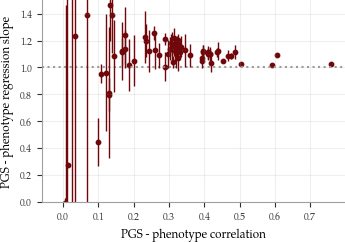

In [207]:
fsize = inch(250, 175)
_df = calib_corr#.query("mean > 0 and mean < 5")
ax = _df.plot.scatter(
    x="CORR_mean", y="mean",
    s=10,
    figsize=fsize)
ax.errorbar(x=_df["CORR_mean"], y=_df["mean"], yerr=_df['std'], linestyle="None",
            elinewidth=1, capsize=0)
#     error_kws=dict(lw=1, capthick=1))
#     elinewidth=1)
#     capsize=0
# )
plt.gca().axhline(1, 0, 1, linestyle=":", color="0.6", zorder=1)
# plt.title("PGS calibration vs PGS correlation")
plt.ylim([0, 1.5])
plt.xlabel("PGS - phenotype correlation")
plt.ylabel("PGS - phenotype regression slope")
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
fig = plt.gcf()

In [208]:
fig.savefig("FiguresV2/supp_calibration_corr.pdf")

#### Calibration table

In [218]:
calib_tab = calib.apply(lambda r: f"{r.iloc[0]:.2f} ± {r.iloc[1]:.2f}", axis=1)

In [222]:
calib_tab = calib_tab.rename(index=new_abbr_map).sort_index(key=lambda s: s.str.lower())
calib_tab["MA"] = "N/A"

In [225]:
latex_kws = {"index": False}

In [227]:
n_col = 5
delta = int(np.ceil(len(calib_tab)/n_col))
tmp = pd.concat(
#     [ fields[[abbr_col, "Field"]].sort_values(abbr_col, key=lambda x: x.str.lower()).iloc[n:n + delta].reset_index(drop=True) for n in range(0, 48, delta)]
    [ calib_tab.iloc[n:n + delta].reset_index() for n in range(0, len(calib_tab), delta)]
    , axis=1, ignore_index=True)
print(tmp.to_latex(**latex_kws))

\begin{tabular}{llllllllll}
\toprule
    0 &            1 &      2 &             3 &      4 &            5 &      6 &             7 &     8 &            9 \\
\midrule
  ABC &  1.46 ± 0.27 &   apoA &   1.10 ± 0.05 &    HCT &  1.15 ± 0.08 &    MCV &   1.09 ± 0.04 &   RET &  1.12 ± 0.21 \\
 ABCp &  1.39 ± 0.28 &   apoB &   1.05 ± 0.02 &    HDL &  1.05 ± 0.02 &    MPV &   1.10 ± 0.01 &  RETp &  1.08 ± 0.27 \\
  AEC &  1.14 ± 0.09 &    AST &   1.02 ± 0.19 &    Hgb &  1.13 ± 0.12 &    MRV &   1.12 ± 0.05 &    RF &  1.23 ± 2.30 \\
 AECp &  1.22 ± 0.08 &     Ca &  5.68 ± 10.35 &   HLSR &  1.16 ± 0.05 &   MSCV &   1.10 ± 0.04 &  SHBG &  1.07 ± 0.07 \\
  ALB &  1.21 ± 0.05 &   chol &   1.07 ± 0.10 &  HLSRp &  0.80 ± 0.12 &     Na &   0.81 ± 0.49 &     T &  1.11 ± 0.11 \\
  ALC &  0.95 ± 0.07 &     Cr &   1.13 ± 0.16 &   IGF1 &  1.11 ± 0.06 &   NRBC &  -0.01 ± 0.03 &  TBil &  1.02 ± 0.01 \\
 ALCp &  1.18 ± 0.05 &    CRP &   1.14 ± 0.14 &    IRF &  1.10 ± 0.10 &  NRBCp &  -1.87 ± 3.34 &    TG &  1

## Predictions

### Systematic predictors

#### Training data

Lou did the following data processing before training
- z-scored according to sex using means and stds of whites
- linear age regression on white z-scored values, applied to every one
- training set z-scoring inside pipeline before doing the lasso

The saved betas, and the hence the scores are undoing the *scaling* of the z-scoring of genotypes and phenotypes in the pipeline:
$$\beta = \frac{\sigma_{ph}{\sigma_{gen} = \beta_{lasso}$$

The phenFiles contain the two first steps (z-scoring, age). The predictions should add the means of the training sets used, i.e., SCORE_x should be SCORE_x + mean(train_x).

#### Functions and training

In [91]:
class LassoWrapper(LassoCV):
    '''Wrapper for predictors to store training set and info about it.'''
    
    def __init__(self, description=None,
                # sklearn
                eps=0.001,
                n_alphas=100,
                alphas=None,
                fit_intercept=True,
                normalize=False,
                precompute='auto',
                max_iter=1000,
                tol=0.0001,
                copy_X=True,
                cv=None,
                verbose=False,
                n_jobs=None,
                positive=False,
                random_state=None,
                selection='cyclic', 
                ):
        super().__init__(
                        eps=eps,
                        n_alphas=n_alphas,
                        alphas=alphas,
                        fit_intercept=fit_intercept,
                        normalize=normalize,
                        precompute=precompute,
                        max_iter=max_iter,
                        tol=tol,
                        copy_X=copy_X,
                        cv=cv,
                        verbose=verbose,
                        n_jobs=n_jobs,
                        positive=positive,
                        random_state=random_state,
                        selection=selection,
        )
        self.description = description
        self.aucs = {}
        
    def fit(self, X, y):
        self.train_cols = X.columns.to_list()
        if isinstance(X, pd.DataFrame):
            self.train_cols = X.columns.to_list()
            self.train_eids = X.index
            # PODO:
            self.train_cohort = {
                "SEX": pr.sex.loc[X.index, "SEX"].unique(),
                "ANCESTRY": pr.ancestry.loc[X.index, "ANCESTRY"].unique()
            }
            
        return super().fit(X, y)
    
    def fit_to_cc(self, X, cond):
        '''Train on subset of X after having removed withdrawals and 
        set 500/500 case/ctrls aside in self.valid_data.'''
        if not isinstance(X, (pd.DataFrame, pd.Series)):
            raise Exception(f"Cannot handle type(X) {type(X)}. Need pd.DataFrame/Series.")
            
        self.train_cond = cond
        X = pr.prune_withdrawals(X)    
        y = cc.loc[X.index, cond]
        valid_cases = y.loc[y == 1].sample(500, replace=False)
        valid_ctrls = y.loc[y == 0].sample(500, replace=False)
        valid_y = valid_cases.append(valid_ctrls)
        valid_X = X.loc[valid_y.index]
        self.valid_eids = valid_X.index
        pred_X = X.loc[~X.index.isin(valid_y.index)]
        pred_y = y.loc[~y.index.isin(valid_y.index)]
        self.fit(pred_X, pred_y)
        return self.auc(valid_y, valid_X, 'valid')
    
    def auc(self, y_true, X, auc_name):
        y_pred = self.predict(X)
        a = roc_auc_score(y_true, y_pred)
        self.aucs[auc_name] = a
        return a

In [ ]:
proc_phen = pr.prune(blood2, "ANCESTRY == 'white'").groupby(pr.sex["SEX"]).transform(z_score)

In [93]:
age_regressions = {}
for col in proc_phen:
    print_tmp(col)
    _, reg = pr.correct_for(proc_phen, pr.age.loc[proc_phen.index, "AGE-0.0"], col, new_col=col + "_corr", winsorize=3);
    age_regressions[col] = reg

vitD


In [94]:
proc_phen = proc_phen.rename(columns=lambda c: c + "_orig").rename(columns=lambda c: re.sub(r"_corr_orig", "", c))

In [95]:
proc_phen = proc_phen.transform(z_score)

In [96]:
abbrs_to_drop = ["micro", "oest", "rheu"]
phen_cols = [c for c in proc_phen if not c.endswith("_orig") and c not in abbrs_to_drop]

In [153]:
proc_phen[phen_cols].dropna().shape

(214871, 62)

In [156]:
pap_preds = {}
subset_fstring = "ANCESTRY == 'white' and SEX == {sex}"
tmp_phen = proc_phen.loc[~proc_phen.index.isin(pr.cohorts['eid.withinSibPairs'])].drop(columns=abbrs_to_drop)
start = time()
for cond in cc:
    start_cond = time()
    pap_preds[cond] = {}
    for sex in [0, 1]:
        start_sex = time()
        subset_string = subset_fstring.format(sex=sex)
        pap_preds[cond][sex] = []
        tmpX = pr.prune(tmp_phen[phen_cols].dropna(), subset_string)
        for n in range(5):
            start_n = time()
            pap_preds[cond][sex].append(LassoWrapper(description=f"{cond}:{sex} - {subset_string}", eps=0.01, n_alphas=100))
            pap_preds[cond][sex][-1].fit_to_cc(tmpX, cond)
            print_tmp(cond, sex, n, ":", time() - start, time() - start_cond, time() - start_sex, time() - start_n)

obesity 1 4 : 225.90122985839844 19.579166412353516 10.965452909469604 2.2049221992492676


In [157]:
# pickle.dump(pap_preds, open(dir_varsBiomarkersV2 + 'pap_preds.p', 'wb'))

In [97]:
pap_preds = pickle.load(open(dir_varsBiomarkersV2 + 'pap_preds.p', 'rb'))

In [98]:
pap_preds_df = pd.DataFrame({(cond, sex): pap_preds[cond][sex] for cond in pap_preds for sex in pap_preds[cond]})

##### Score on other ancestries

Copy scores and fill in vitD to fix bprs aucs.

In [99]:
scores_vitD_fill = scores.copy()
scores_vitD_fill.loc['vitD', "SCORE_1"] = scores_vitD_fill.loc['vitD', "SCORE_3"].to_list()
scores_vitD_fill.loc['vitD', "SCORE_2"] = scores_vitD_fill.loc['vitD', "SCORE_3"].to_list()
scores_vitD_fill.loc['vitD', "SCORE_5"] = scores_vitD_fill.loc['vitD', "SCORE_4"].to_list()

redo scoring
- use proc_phen and remove all used in training before calling pred.auc
- do for all ancestries and remake brs plot. Check results in paper
- make tables with AUC values
- make tables with N c/c.
- make tables for bprs

In [119]:
def calc_aucs(pred, ancestry=None, sex=None):
    m = re.search(r"ANCESTRY\s*==\s*'(.*)'.*SEX\s*==\s*(\d)", pred.description)
    if ancestry is None:
        ancestry = m[1]
    if sex is None:
        sex = m[2]
    subset_string = f"ANCESTRY == '{ancestry}' and SEX == {sex}"
    cond = pred.train_cond
    pred_group = pred.description.split(":")[0]
    print_tmp(pred_group, cond)
    brs_X = scores["PHEN"].unstack(0)[pred.train_cols].dropna() # "PHEN" already z-scored
    brs = pr.prune(brs_X, subset_string)
    auc_brs = pred.auc(cc.loc[brs.index, cond], brs, subset_string)
    return auc_brs

def calc_bprs_aucs(pred, ancestry=None, sex=None,  ret_bprs=False):
    m = re.search(r"ANCESTRY\s*==\s*'(.*)'.*SEX\s*==\s*(\d)", pred.description)
    if ancestry is None:
        ancestry = m[1]
    if sex is None:
        sex = m[2]
    subset_string = f"ANCESTRY == '{ancestry}' and SEX == {sex}"
    cond = pred.train_cond
    pred_group = pred.description.split(":")[0]
    print_tmp(pred_group, cond, ancestry, sex)
    bprs_Xs = scores_vitD_fill.filter(regex=r"SCORE_\d")
    aucs_bprs = []
    preds_bprs = []
    for s in bprs_Xs:
        bprs_X = z_score(bprs_Xs[s].unstack(0)[pred.train_cols].dropna())
        bprs = pr.prune(bprs_X, subset_string)
        bprs = bprs.loc[bprs.index.isin(cc.index)]
        aucs_bprs.append(pred.auc(cc.loc[bprs.index, cond], bprs, "bprs: " + subset_string))
        if ret_bprs:
            y_pred_ser = pd.Series(pred.predict(bprs), index=bprs.index)
            preds_bprs.append(y_pred_ser)

    return preds_bprs if ret_bprs else aucs_bprs

Calculate AUCs for BRS

In [184]:
pap_anc_aucs = {a: pap_preds_df.applymap(lambda p: calc_aucs(p, ancestry=a)) for a in ["white", "asian", "chinese", "black"]}

obesity obesity


In [185]:
pap_anc_aucs_df = pd.concat(pap_anc_aucs, names=["ANCESTRY"])

In [220]:
# pickle.dump(pap_anc_aucs_df, open('pap_anc_aucs_df.p', 'wb'))

In [94]:
pap_anc_aucs_df = pickle.load(open('pap_anc_aucs_df.p', 'rb'))

Calculate BPRS AUCs for white

In [ ]:
wpap_bprs_aucs_df = pap_preds_df.unstack().apply(calc_bprs_aucs)

In [103]:
tmp = pd.DataFrame(columns=wpap_bprs_aucs_df.index)

In [104]:
for l in wpap_bprs_aucs_df.index:
    tmp[l] = pap_bprs_aucs_df.loc[l]

In [106]:
wpap_bprs_aucs_df = tmp

In [118]:
# pickle.dump(wpap_bprs_aucs_df, open("VarsBiomarkersV2/wpap_bprs_aucs_df.p", "wb"))

In [73]:
wpap_bprs_aucs_df = pickle.load(open("VarsBiomarkersV2/wpap_bprs_aucs_df.p", "rb"))

Calculate BPRS for all ancestries

In [ ]:
pap_anc_bprs = {a: pap_preds_df.applymap(lambda p: calc_bprs_aucs(p, ancestry=a, ret_bprs=True)) for a in ["white", "asian", "chinese", "black"]}

In [ ]:
# pickle.dump(pap_anc_bprs, open("VarsBiomarkersV2/pap_anc_bprs.p", "wb"))

In [124]:
pap_anc_bprs_df = pd.concat(pap_anc_bprs, names=["ANCESTRY"])

In [129]:
pap_anc_bprs_df.index.set_names("PREDICTOR_FOLD", level=1, inplace=True)

In [131]:
pap_anc_bprs_df = pap_anc_bprs_df.unstack(1)

In [181]:
_df = pap_anc_bprs_df.stack(1)
tmp = pd.concat({l: pd.concat({c: pd.concat(_df.loc[l, c], axis=1) for c in _df}, axis=1, keys=_df.columns) for l in _df.index}, axis=0)

In [186]:
tmp.index.set_names(["ANCESTRY", "SEX", "eid"], inplace=True)
tmp.columns.set_names(["cond", "PREDICTOR_FOLD", "#PGS"], inplace=True)

In [188]:
pap_anc_bprs_df = tmp

In [189]:
# pickle.dump(pap_anc_bprs_df, open("VarsBiomarkersV2/pap_anc_bprs_df.p", "wb"))

In [ ]:
pap_anc_bprs_df = pickle.load(open("VarsBiomarkersV2/pap_anc_bprs_df.p", "rb"))

Calculate white BPRS means and stds

In [190]:
wpap_bpm = wpap_bprs_aucs_df.unstack().groupby(level=[0, 1]).mean()
wpap_bpstd = wpap_bprs_aucs_df.unstack().groupby(level=[0, 1]).std()

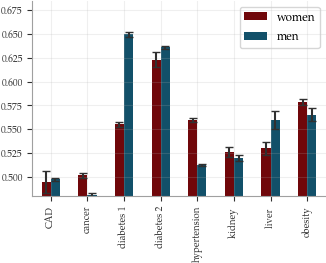

In [191]:
fsize = inch(236, 190)
wpap_bpm.unstack(1).drop(index='diabetes').rename(index=cond_to_print).plot.bar(yerr=wpap_bpstd.unstack(1).rename(index=cond_to_print), figsize=fsize)
plt.ylim(bottom=0.48)
plt.legend(labels=['women', 'men'])
fig = plt.gcf()
plt.tight_layout(pad=0)

In [192]:
fig.savefig("FiguresV2/bprs_aucs_white.pdf")

##### Redo BRS predictions and AUCs

In [344]:
pap_train_eids = {cond: reduce(lambda idx, p: idx.union(p.train_eids), pap_preds_df[cond].unstack(), pap_preds_df[cond].iloc[0, 0].train_eids) for cond in cc}

In [ ]:
brs_mstd = pr.prune(blood2, "ANCESTRY == 'white'").groupby(pr.sex["SEX"]).agg(['mean', 'std'])

In [346]:
brs_mstd = brs_mstd.drop([-2, -1]).stack().unstack(0).T

In [ ]:
brs_score_phen= pr.prune(blood2, "SEX.isin([0, 1])").copy()

In [348]:
pr.assign_sex(brs_score_phen)

In [349]:
brs_score_phen = brs_score_phen.set_index("SEX", append=True).unstack()

In [350]:
brs_score_phen = (brs_score_phen - brs_mstd["mean"])/brs_mstd["std"]

In [354]:
for abbr in age_regressions:
    brs_score_phen[abbr] = brs_score_phen[abbr].sub(age_regressions[abbr].predict(pr.age.loc[brs_score_phen.index, "AGE-0.0"]), axis=0)

In [355]:
brs_score_phen = brs_score_phen.stack().reset_index(level=1, drop=True)

In [356]:
def redo_brs_predAuc(pred, ancestry=None, sex=None, ret_auc=False):
    m = re.search(r"ANCESTRY\s*==\s*'(.*)'.*SEX\s*==\s*(\d)", pred.description)
    if ancestry is None:
        ancestry = m[1]
    if sex is None:
        sex = m[2]
    subset_string = f"ANCESTRY == '{ancestry}' and SEX == {sex}"
    cond = pred.train_cond
    pred_group = pred.description.split(":")[0]
    print_tmp(pred_group, cond, ancestry, sex)
    # chose features
    brs_X = brs_score_phen[pred.train_cols].dropna()
#     print(brs_X.shape)
    brs_X = brs_X.loc[~brs_X.index.isin(pap_train_eids[cond])]
#     print(brs_X.shape)
    brs_X = pr.prune(brs_X, subset_string)
#     print(brs_X.shape)
    auc_brs = pred.auc(cc.loc[brs_X.index, cond], brs_X, subset_string)
    brs = pd.Series(pred.predict(brs_X), index=brs_X.index)
    return auc_brs if ret_auc else brs



# def calc_bprs_aucs(pred, ancestry=None, sex=None):
#     m = re.search(r"ANCESTRY\s*==\s*'(.*)'.*SEX\s*==\s*(\d)", pred.description)
#     if ancestry is None:
#         ancestry = m[1]
#     if sex is None:
#         sex = m[2]
#     subset_string = f"ANCESTRY == '{ancestry}' and SEX == {sex}"
#     cond = pred.train_cond
#     pred_group = pred.description.split(":")[0]
#     print_tmp(pred_group, cond)
#     bprs_Xs = scores_vitD_fill.filter(regex=r"SCORE_\d")
#     aucs_bprs = []
#     for s in bprs_Xs:
#         bprs_X = z_score(bprs_Xs[s].unstack(0)[pred.train_cols].dropna())
#         bprs = prune(bprs_X, subset_string)
#         bprs = bprs.loc[bprs.index.isin(cc.index)]
#         aucs_bprs.append(pred.auc(cc.loc[bprs.index, cond], bprs, "bprs: " + subset_string))
#     return aucs_bprs

In [ ]:
start = time()
pap_redone_anc_brs = {}
pap_redone_anc_aucs = {}
for a in ["white", "asian", "chinese", "black"]:
    start_a = time()
    print_tmp(a, time() - start)
    pap_redone_anc_brs[a] = pap_preds_df.applymap(lambda p: redo_brs_predAuc(p, ancestry=a, ret_auc=False));
    print_tmp(a, time() - start, time() - start_a)
    pap_redone_anc_aucs[a] = pap_preds_df.applymap(lambda p: redo_brs_predAuc(p, ancestry=a, ret_auc=True));

In [358]:
pap_redone_anc_brs_df = pd.concat(pap_redone_anc_brs, names=["ANCESTRY"])

In [359]:
pap_redone_anc_aucs_df = pd.concat(pap_redone_anc_aucs, names=["ANCESTRY"])

In [360]:
# pickle.dump(pap_redone_anc_brs_df, open("VarsBiomarkersV2/pap_redone_anc_brs_df.p", "wb"))
# pickle.dump(pap_redone_anc_aucs_df, open("VarsBiomarkersV2/pap_redone_anc_aucs_df.p", "wb"))

In [374]:
pap_redone_anc_aucs_df

cad              cancer            diabetes            \
                   0         1         0         1         0         1   
ANCESTRY                                                                 
white    0  0.742660  0.733892  0.561754  0.597340  0.930625  0.922405   
         1  0.744629  0.733744  0.561667  0.596167  0.930755  0.922387   
         2  0.741533  0.734005  0.561559  0.597156  0.930542  0.922448   
         3  0.741821  0.734078  0.560888  0.595996  0.930734  0.922379   
         4  0.743224  0.733891  0.560636  0.598791  0.930665  0.922354   
asian    0  0.764646  0.744060  0.651375  0.653482  0.927808  0.905504   
         1  0.765814  0.743895  0.653059  0.658847  0.928055  0.905452   
         2  0.760823  0.743894  0.655750  0.654800  0.927988  0.905496   
         3  0.757609  0.743674  0.651596  0.657471  0.928360  0.905519   
         4  0.759800  0.744339  0.652603  0.655571  0.927722  0.905384   
chinese  0  0.816403  0.780817  0.699648  0.640324  0.945324  0.785647   
         1  0.827690  0.777440  0.691625  0.653833  0.945614  0.785332   
         2  0.808628  0.777778  0.704145  0.646403  0.945686  0.786067   
         3  0.822423  0.781830  0.691504  0.639311  0.945758  0.785542   
         4  0.818410  0.777778  0.692476  0.651807  0.946915  0.785857   
black    0  0.681688  0.693680  0.680367  0.641217  0.894252  0.890970   
         1  0.675035  0.694448  0.680718  0.638001  0.894473  0.890447   
         2  0.683484  0.694433  0.684024  0.638604  0.894065  0.891001   
         3  0.682954  0.693552  0.682000  0.636956  0.893950  0.891004   
         4  0.686791  0.693694  0.684983  0.641391  0.894099  0.891044   

           diabetes_type1           diabetes_type2           hypertension  \
                        0         1              0         1            0   
ANCESTRY                                                                    
white    0       0.946529  0.949478       0.937637  0.921053     0.710323   
         1       0.946484  0.949859       0.937412  0.920884     0.710377   
         2       0.946569  0.949686       0.937374  0.921066     0.710358   
         3       0.946699  0.949702       0.937287  0.920909     0.710310   
         4       0.946493  0.949786       0.937774  0.921068     0.710264   
asian    0       0.935693  0.930488       0.917202  0.880770     0.722316   
         1       0.936057  0.930789       0.917356  0.880765     0.721791   
         2       0.935567  0.930653       0.917509  0.880824     0.721880   
         3       0.936028  0.930493       0.917542  0.880783     0.721906   
         4       0.936099  0.930762       0.917314  0.880841     0.722115   
chinese  0       0.935228  0.831424       0.955120  0.793928     0.766440   
         1       0.935100  0.830729       0.955207  0.794918     0.766570   
         2       0.935100  0.830035       0.955294  0.794423     0.766231   
         3       0.935100  0.831076       0.953551  0.794588     0.766022   
         4       0.936508  0.830556       0.954161  0.794258     0.766648   
black    0       0.919397  0.909410       0.891376  0.886459     0.706485   
         1       0.919168  0.909106       0.891393  0.886668     0.706307   
         2       0.918868  0.909365       0.890459  0.886430     0.706459   
         3       0.918466  0.909245       0.891393  0.885799     0.706239   
         4       0.918063  0.909410       0.891329  0.886395     0.706296   

                     kidney_problem           liver_problem            \
                   1              0         1             0         1   
ANCESTRY                                                                
white    0  0.717375       0.695431  0.667900      0.644173  0.643125   
         1  0.717358       0.696731  0.668362      0.646112  0.642283   
         2  0.717485       0.696660  0.668261      0.645693  0.646011   
         3  0.717342       0.699651  0.668936      0.645393  0.643210   
         4  0.717384       0.69

In [89]:
pap_redone_anc_brs_df = pickle.load(open("VarsBiomarkersV2/pap_redone_anc_brs_df.p", "rb"))
pap_redone_anc_aucs_df = pickle.load(open("VarsBiomarkersV2/pap_redone_anc_aucs_df.p", "rb"))

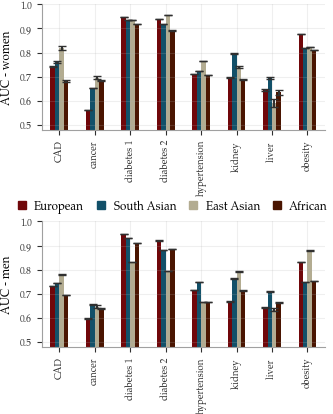

In [361]:
def plot_pap_preds_aucs(sex, ax=None, figsize=inch(250, 100), legend=True):
    ax_kws= {} if ax is None else {"ax": ax}
    anc_order = ['white', 'asian', 'chinese', 'black']
    anc_colors = colors[[0, 1, 3, 2]]
    g = pap_redone_anc_aucs_df.drop(columns='diabetes').rename(columns=cond_to_print, level=0)\
        .loc[:, (slice(None), sex)].droplevel(1, axis=1).groupby(level=0)
    g.mean().T[anc_order].plot.bar(
        yerr=g.std().T, color=anc_colors, 
        figsize=figsize,
        legend=False,
        **ax_kws)
    plt.ylim([0.48, 1])
    if legend or sex:
        plt.legend(
            [mpl.lines.Line2D([], [], marker='s', color=anc_colors[n], linestyle='None') for n in range(4)],
            [ancestry_map[a] for a in anc_order],
            ncol=4, 
            title_fontsize='x-small',
            frameon=False,
            handletextpad=0.05,
            columnspacing=.5,
            loc='lower center', bbox_to_anchor=(0.45, .98),
        )
    plt.ylabel("AUC - " + ["women", "men"][sex])
#     plt.title(["women", "men"][sex], )
#     plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    
fig, axs = plt.subplots(2, 1, figsize=inch(250, 200))
for n in [0, 1]:
    plt.sca(axs[n])
    plot_pap_preds_aucs(n, ax=axs[n], figsize=inch(250, 300),
                       legend=False)
        
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
# plot_pap_preds_aucs(0), plot_pap_preds_aucs(1)

In [362]:
fig.savefig("FiguresV2/brs_aucs_femalesAndMales.pdf")

#### Sample sizes

AUC brs sizes

In [576]:
def unique_ancestries(data):
    eids = data.index.intersection(pr.ancestry.index)
    return pr.ancestry.loc[eids, "ANCESTRY"].unique()

In [574]:
train_cols = pap_preds['cad'][0][0].train_cols

In [602]:
# scores people
tmpX = scores["PHEN"].unstack(0)[pap_preds['cad'][0][0].train_cols].dropna()
tmpCC = cc.loc[cc.index.isin(tmpX.index)].copy()
pr.assign_ancestry(tmpCC)
tmp = tmpCC.groupby("ANCESTRY").apply(lambda df: df.drop(columns=["ANCESTRY", "diabetes"]).apply(pd.value_counts)).T
tmp = tmp[["white", "asian", "chinese", "black"]].rename(columns=ancestry_map, level=0).rename(columns={0:"controls", 1: "cases"}, level=1).rename(index=cond_to_print)
tmp

ANCESTRY     European       South Asian       East Asian        African      
             controls cases    controls cases   controls cases controls cases
CAD              5435   270         956    86        212     7      716     9
cancer           5177   528        1021    21        211     8      702    23
diabetes 1       5493   212         898   144        211     8      668    57
diabetes 2       5451   254         901   141        205    14      660    65
hypertension     3909  1796         672   370        160    59      455   270
kidney           5486   219        1008    34        212     7      700    25
liver            5553   152        1019    23        209    10      712    13
obesity          4548  1157         856   186        208    11      459   266

In [603]:
print(tmp.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
ANCESTRY & \multicolumn{2}{l}{European} & \multicolumn{2}{l}{South Asian} & \multicolumn{2}{l}{East Asian} & \multicolumn{2}{l}{African} \\
{} & controls & cases &    controls & cases &   controls & cases & controls & cases \\
\midrule
CAD          &     5435 &   270 &         956 &    86 &        212 &     7 &      716 &     9 \\
cancer       &     5177 &   528 &        1021 &    21 &        211 &     8 &      702 &    23 \\
diabetes 1   &     5493 &   212 &         898 &   144 &        211 &     8 &      668 &    57 \\
diabetes 2   &     5451 &   254 &         901 &   141 &        205 &    14 &      660 &    65 \\
hypertension &     3909 &  1796 &         672 &   370 &        160 &    59 &      455 &   270 \\
kidney       &     5486 &   219 &        1008 &    34 &        212 &     7 &      700 &    25 \\
liver        &     5553 &   152 &        1019 &    23 &        209 &    10 &      712 &    13 \\
obesity      &     4548 &  1157 &         856 &  

CC numbers for brs

In [364]:
def anc_cc_count(df, cond):
    ndf = pd.DataFrame()
    ndf["CC"] = cc.loc[df.index.get_level_values(0), cond]
    ndf["ANCESTRY"] = pr.ancestry["ANCESTRY"]
    ret = ndf.groupby("ANCESTRY").apply(lambda df: df.value_counts())
    ret = ret.rename(columns={0: "ctrls", 1: "cases"}, level=0)
    ret = ret.droplevel(1, axis=1)
    return ret

# anc_cc_count(pap_brs_df.iloc[0, 0], 'cad')

In [365]:
tmp = pap_redone_anc_brs_df.loc[(slice(None), 0), :].reset_index(level=1, drop=True)

_ = pd.concat({cond: tmp[cond].unstack().apply(lambda d: anc_cc_count(d, cond)) for cond in cc})

tab_brs = pd.concat({l: _.loc[l] for l in _.index}).droplevel(-1).stack().unstack(0).T
# tab_brs = tab_brs.sort_index(axis=1, level=[0])
# .rename(columns={0:"women", 1: "men"}, level=0).

In [366]:
def style_tab(tab):
    return tab.reindex(columns=anc_order, level=1).rename(columns={0:"women", 1: "men"}, level=0).rename(columns=ancestry_map, level=1).drop("diabetes").rename(index=cond_to_print)

In [797]:
# print(style_tab(tab_brs).to_latex())

In [368]:
anc_order = ['white', 'asian', 'chinese', 'black']
stab_brs = style_tab(tab_brs)

In [369]:
print(stab_brs.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{8}{l}{women} & \multicolumn{8}{l}{men} \\
{} & \multicolumn{2}{l}{European} & \multicolumn{2}{l}{South Asian} & \multicolumn{2}{l}{East Asian} & \multicolumn{2}{l}{African} & \multicolumn{2}{l}{European} & \multicolumn{2}{l}{South Asian} & \multicolumn{2}{l}{East Asian} & \multicolumn{2}{l}{African} \\
CC &    ctrls & cases &       ctrls & cases &      ctrls & cases &   ctrls & cases &    ctrls & cases &       ctrls & cases &      ctrls & cases &   ctrls & cases \\
\midrule
CAD          &     8842 &   174 &        1369 &    30 &        443 &     9 &    1361 &    18 &     8745 &   861 &        2329 &   365 &        329 &     9 &    1496 &    47 \\
cancer       &     8076 &   940 &        1352 &    47 &        433 &    19 &    1323 &    56 &     8897 &   709 &        2642 &    52 &        329 &     9 &    1485 &    58 \\
diabetes 1   &     8785 &   232 &        1267 &   132 &        434 &    18 &    1280 &    99 &     9031 &  

AUCs table

In [370]:
tab_auc = pap_redone_anc_aucs_df.groupby(level=0).apply(lambda df: df.agg(lambda s: f"{s.mean():.3f} ± {s.std():.3f}")).unstack().unstack(0)

In [371]:
tab_auc["AUC"] = "AUC"
tab_auc = tab_auc.set_index("AUC", append=True).T

In [372]:
print(style_tab(tab_auc).to_latex())

\begin{tabular}{lllllllll}
\toprule
{} & \multicolumn{4}{l}{women} & \multicolumn{4}{l}{men} \\
ANCESTRY &       European &    South Asian &     East Asian &        African &       European &    South Asian &     East Asian &        African \\
AUC &            AUC &            AUC &            AUC &            AUC &            AUC &            AUC &            AUC &            AUC \\
\midrule
CAD          &  0.743 ± 0.001 &  0.762 ± 0.003 &  0.819 ± 0.007 &  0.682 ± 0.004 &  0.734 ± 0.000 &  0.744 ± 0.000 &  0.779 ± 0.002 &  0.694 ± 0.000 \\
cancer       &  0.561 ± 0.001 &  0.653 ± 0.002 &  0.696 ± 0.006 &  0.682 ± 0.002 &  0.597 ± 0.001 &  0.656 ± 0.002 &  0.646 ± 0.007 &  0.639 ± 0.002 \\
diabetes 1   &  0.947 ± 0.000 &  0.936 ± 0.000 &  0.935 ± 0.001 &  0.919 ± 0.001 &  0.950 ± 0.000 &  0.931 ± 0.000 &  0.831 ± 0.001 &  0.909 ± 0.000 \\
diabetes 2   &  0.937 ± 0.000 &  0.917 ± 0.000 &  0.955 ± 0.001 &  0.891 ± 0.000 &  0.921 ± 0.000 &  0.881 ± 0.000 &  0.794 ± 0.000 &  0.886 ± 0.000

Combine

In [789]:
# tab_brs_auc = pd.concat([tab_brs, tab_auc], axis=1)

In [793]:
# print(tab_brs_auc.sort_index(axis=1).to_latex())

BPRS table

In [816]:
tab_bprs_auc = pap_bprs_aucs_df.stack().agg(lambda s: f"{s.mean():.3f} ± {s.std():.3f}").unstack()

In [839]:
tab_bprs = pd.concat([
    pd.concat({cond: anc_cc_count(pap_bprs.loc[(slice(None), 0), :], cond) for cond in cc}).droplevel(1),
        pd.concat({cond: anc_cc_count(pap_bprs.loc[(slice(None), 1), :], cond) for cond in cc}).droplevel(1),
], axis=1)

In [842]:
women_men = {0: "women", 1: "men"}
stab_bprs_auc = tab_bprs_auc.rename(index=cond_to_print).rename(columns=women_men)

In [846]:
stab_bprs_combo = pd.concat([tab_bprs_auc[0], tab_bprs.iloc[:, :2], tab_bprs_auc[1], tab_bprs.iloc[:, 2:]], axis=1).rename(index=cond_to_print)

In [848]:
print(stab_bprs_combo.to_latex())

\begin{tabular}{llrrlrr}
\toprule
{} &              0 &  ctrls &  cases &              1 &  ctrls &  cases \\
\midrule
CAD          &  0.493 ± 0.010 &   2751 &     40 &  0.492 ± 0.001 &   2680 &    230 \\
cancer       &  0.505 ± 0.002 &   2506 &    285 &  0.488 ± 0.005 &   2668 &    242 \\
diabetes     &  0.606 ± 0.002 &   2681 &    110 &  0.627 ± 0.002 &   2688 &    222 \\
diabetes 1   &  0.557 ± 0.003 &   2729 &     62 &  0.650 ± 0.002 &   2760 &    150 \\
diabetes 2   &  0.624 ± 0.009 &   2709 &     82 &  0.637 ± 0.003 &   2738 &    172 \\
hypertension &  0.558 ± 0.002 &   2074 &    717 &  0.514 ± 0.001 &   1831 &   1079 \\
kidney       &  0.527 ± 0.005 &   2713 &     78 &  0.522 ± 0.003 &   2769 &    141 \\
liver        &  0.524 ± 0.008 &   2719 &     72 &  0.551 ± 0.008 &   2830 &     80 \\
obesity      &  0.574 ± 0.003 &   2236 &    555 &  0.564 ± 0.007 &   2309 &    601 \\
\bottomrule
\end{tabular}



#### Betas

In [163]:
fsize_full2Beta = inch(200, 400)
fsize_fullBeta = inch(100, 400)

In [370]:
pap_betas = pd.concat({fold: pap_preds_df.loc[fold].apply(lambda x: pd.Series(x.coef_, index=x.train_cols)) for fold in range(5)}, names=["fold"])

In [371]:
pap_betas = pap_betas.T.swaplevel(0, 2, axis=1).sort_index(axis=1)

In [372]:
pap_bm = pap_betas.groupby(level=[0, 1], axis=1).mean()#.swaplevel(0, 1, axis=1)['hypertension'].sort_values(1, ascending=True, key=np.abs).plot.barh()
pap_bstd = pap_betas.groupby(level=[0, 1], axis=1).std()

Plot betas

In [419]:
def plot_brs_betas(cond, n_abbr=None, top_lim=0.05, figsize=inch(200, 300), savename=None, **plot_kws):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    for sex in [0, 1]:
        col = (sex, cond)
        ser = pap_bm[col].sort_values(key=np.abs).rename(index=new_abbr_map)
        ser_top = ser.loc[ser.abs() > top_lim*ser.abs().iloc[-1]]
#         print(cond, sex, top_lim,  ":", len(ser_top), n_abbr)
        if n_abbr is not None:
            ser.tail(n_abbr).plot.barh(xerr=pap_bstd[col].rename(index=new_abbr_map), ax=axs[sex],color=colors[sex], **plot_kws)            
        else:
            ser_top.plot.barh(xerr=pap_bstd[col].rename(index=new_abbr_map), ax=axs[sex],color=colors[sex], **plot_kws)
#         plt.suptitle(cond_to_print(cond), fontsize='small', y=.93)
#         plt.tight_layout()
        plt.suptitle(cond_to_print(cond), fontsize='small')
        plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=(0, 0, 1, 0.985))
        
    if savename is None:
        savename = f"FiguresV2/brs_betas_{cond}_full.pdf"
    fig.savefig(savename)
    
for cond in cc:
#     plot_brs_betas(cond, n_abbr=32, figsize=inch(170, 300)) #NB:change save name!
    plot_brs_betas(cond, n_abbr=len(phen_cols), figsize=inch(170, 450))

Shorter ones for paper

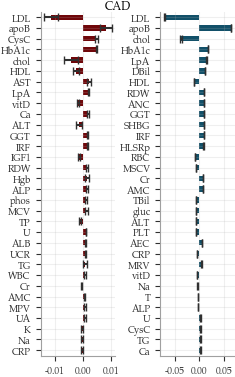

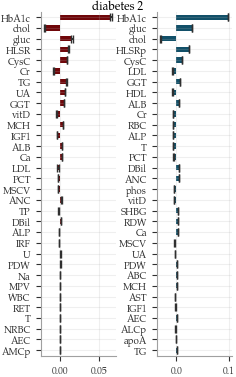

In [423]:
for cond in ["cad", "diabetes_type2"]:
    plot_brs_betas(cond, n_abbr=32, figsize=inch(170, (32/62*1.2)*450), savename=f"FiguresV2/brs_betas_{cond}_short.pdf")

### Non-linear effects?

Test if there are any non-linear effects between blood markers and case status

In [41]:
from sklearn.preprocessing import PolynomialFeatures

In [285]:
blood.memory_usage().sum()/1e6

216.514056

In [289]:
220/48*(45 + 25)

320.8333333333333

In [286]:
220/48*(45**2)

9281.25

In [96]:
def quad_features(df, cols=None, concat=False):
    if cols is None:
        cols = df.columns
    
    qdf = pd.DataFrame(index=df.index)
    for c1 in cols:
        for c2 in cols:
            qdf[f"{c1}·{c2}"] = df[c1] * df[c2]
    
    if concat:
        return pd.concat([df, qdf], axis=1)
    
    return qdf

In [95]:
preds2 = {}
preds2["lin1"] = {}
preds2["lin2"] = {}

In [97]:
time1 = 0
time2 = 0
for cond in cc:
    print_tmp(f'Began {cond}. Last trainings took', (time1, time2))
    tmpp = preds['lasso0'][cond]
    tmp = pd.Series(tmpp.coef_, index=tmpp.train_cols)
    tmp_top_abbrs = tmp.sort_values(key=np.abs, ascending=False).head(7).index
#     tmpX = z_score(prune(blood[pred_abbrs_map[0]], "ANCESTRY == 'white' and SEX == 1").dropna())
    tmpX = prune(blood[pred_abbrs_map[0]], "ANCESTRY == 'white' and SEX == 1").dropna()
#     tmpQ = pd.DataFrame(
#         PolynomialFeatures(degree=2, include_bias=False).fit_transform(tmpX[tmp_top_abbrs]),
#         index = tmpX.index)

#     tmpQ = quad_features(tmpX, concat=True)
    tmpQ = quad_features(tmpX, tmp_top_abbrs, concat=True)
    tmpeids = tmpX.index.difference(tmpp.valid_data[0].index)

    tmpy = cc.loc[tmpeids, cond]
    start = time()
    l1 = LinearRegression().fit(tmpX.loc[tmpeids], tmpy)
    time1 = time() - start
    start = time()
    l2 = LinearRegression().fit(tmpQ.loc[tmpeids], tmpy)
    time2 = time() - start

    predeids = tmpp.valid_data[0].index[tmpp.valid_data[0].index.isin(tmpX.index)]
    tmppred1 = l1.predict(tmpX.loc[predeids])
    tmppred2 = l2.predict(tmpQ.loc[predeids])

    l1.aucs = {}
    l2.aucs = {}
    l1.aucs["valid"] = roc_auc_score(cc.loc[predeids, cond], tmppred1)
    l2.aucs["valid"] = roc_auc_score(cc.loc[predeids, cond], tmppred2)
    
    preds2['lin1'][cond] = l1
    preds2['lin2'][cond] = l2

Began obesity. Last trainings took (0.1553971767425537, 0.6211636066436768)


In [98]:
lin_auc = pd.DataFrame(index=['lin1', 'lin2'])
for cond in cc:
    lin_auc[cond] = [preds2['lin1'][cond].aucs["valid"], preds2['lin2'][cond].aucs["valid"]]

lin_auc = lin_auc.T
lin_auc

,lin1,lin2
cad,0.749733,0.757717
cancer,0.609286,0.615734
diabetes,0.934063,0.929654
diabetes_type1,0.955088,0.945829
diabetes_type2,0.933964,0.930836
hypertension,0.713764,0.719666
kidney_problem,0.660767,0.657936
liver_problem,0.691723,0.686960
obesity,0.828827,0.836434


# BRS and BPRS

## QQ plots of BRS and BPRS

### BRS

In [379]:
wpap_brs_wz = wpap_brs_w.groupby(level=1).apply(z_score)

In [380]:
def freedman_diaconis(ser, ret_n_bins=True):
    '''Return n_bins (or bin_width) using Freedman-Diaconis rule.'''
    iqr = ser.quantile(0.75) - ser.quantile(0.25)
    bin_width = 2 * iqr/np.cbrt(len(ser))
    n_bins = (ser.max() - ser.min())/bin_width
    return int(np.round(n_bins)) if ret_n_bins else bin_width

def get_bin_edges(df, n_bins=None):
    '''Return average bin edges for all columns using Freedman-Diaconis rule.'''
    bin_edges = []
    if n_bins is None:
        n_bins = int(np.round(df.apply(freedman_diaconis).mean()))
    for col in df:
        _, _bin_edges = np.histogram(df[col], bins=n_bins)
        bin_edges.append(_bin_edges)
    return sum(bin_edges)/len(bin_edges)

In [381]:
def plot_hist_with_yerr(df, bins=None, density=True, bar_kws={}):#hist_kws={}, err_kws={}):
    bin_edges = get_bin_edges(df, n_bins=bins)
    ys = pd.DataFrame(
         [np.histogram(df[col], bins=bin_edges, density=density)[0] for col in df])
#     df.mean(axis=1).hist(bins=bin_edges, density=density, **hist_kws)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    bin_width = (bin_edges[1:] - bin_edges[:-1]).mean()
    plt.bar(bin_centers, ys.mean(), width=bin_width, yerr=ys.std(), 
            capsize=0,
            **bar_kws)
#     plt.errorbar(x=bin_centers, y=ys.mean(), yerr=ys.std(),
#                  fmt="none", capsize=0, **err_kws)
    return ys, bin_edges

In [ ]:
for sex in [0, 1]:
    subset_string = f'ANCESTRY == "white" and SEX == {sex}'
    sext = ['women', 'men'][sex]
    fsize = inch(520, 300)
    fig, axs = plt.subplots(3, 3, figsize=fsize)
    for n, cond in enumerate(cc.drop(columns="diabetes")):
        ax1 = plt.subplot(3, 3, n + 1)
        data = z_score(pr.prune(wpap_brs_wz.droplevel(1)[cond], subset_string))
        mean = data.mean(axis=1)
#         std = data.std(axis=1)
    #     data.groupby(cc[cond]).apply(lambda df: my_qq(df, text=False));
        mg = mean.groupby(cc[cond])
        my_qq(mg.get_group(1), text=False)
        my_qq(mg.get_group(0), text=False)

        plt.legend(['cases', 'ctrls'])
        xlim = ax1.get_xlim()
        ax2 = ax1.twinx()
    #     (data - data.mean()).groupby(cc[cond]).apply(lambda ser: ser.hist(bins=30, density=True, alpha=0.4, ax=ax2));
        n_bins = 40
#         hist_kws = {"alpha": 0.4, "ax": ax2}
#         err_kws = {}
        plt.sca(ax2)
        bar_kws = dict(alpha=0.4)
        err_alpha = "80"
        dgs = [g for _, g in data.groupby(cc[cond])]
        g = dgs[1]
        bar_kws["color"] = colors[0] 
        bar_kws["ecolor"] = bar_kws["color"] + err_alpha
        plot_hist_with_yerr(g, bins=n_bins, bar_kws=bar_kws)
        g = dgs[0]
        bar_kws["color"] = colors[1] 
        bar_kws["ecolor"] = bar_kws["color"] + err_alpha
        plot_hist_with_yerr(g, bins=n_bins, bar_kws=bar_kws)
        
        plt.xlim(xlim)
        plt.title(f"{cond_to_print(cond)} — {sext}"); #": BRS QQ");
        ax1.set_zorder(ax2.get_zorder() + 1)
        ax1.spines['right'].set_visible(True)
#         break

    axs[-1, -1].set_visible(False)
    plt.tight_layout(pad=0, h_pad=0.2)
    fig.savefig(f"FiguresV2/supp_brs_distrib_{sext}.pdf")

### BPRS

In [385]:
wpap_bprs_wz = wpap_bprs.groupby(level=1).apply(z_score)

In [ ]:
for sex in [0, 1]:
    subset_string = f'ANCESTRY == "white" and SEX == {sex}'
    sext = ['women', 'men'][sex]
    fsize = inch(520, 300)
    fig, axs = plt.subplots(3, 3, figsize=fsize)
    for n, cond in enumerate(cc.drop(columns="diabetes")):
        ax1 = plt.subplot(3, 3, n + 1)
        data = pr.prune(wpap_bprs_wz.droplevel(1)[cond], subset_string)
        mean = data.mean(axis=1)
        mg = mean.groupby(cc[cond])
        my_qq(mg.get_group(1), text=False)
        my_qq(mg.get_group(0), text=False)

        plt.legend(['cases', 'ctrls'])
        xlim = ax1.get_xlim()
        ax2 = ax1.twinx()

        plt.sca(ax2)
        n_bins = 40
        bar_kws = dict(alpha=0.4)
        err_alpha = "80"
        dgs = [g for _, g in data.groupby(cc[cond])]
        g = dgs[1]
        bar_kws["color"] = colors[0] 
        bar_kws["ecolor"] = bar_kws["color"] + err_alpha
        plot_hist_with_yerr(g, bins=n_bins, bar_kws=bar_kws)
        g = dgs[0]
        bar_kws["color"] = colors[1] 
        bar_kws["ecolor"] = bar_kws["color"] + err_alpha
        plot_hist_with_yerr(g, bins=n_bins, bar_kws=bar_kws)
        
        plt.xlim(xlim)
        plt.title(f"{cond_to_print(cond)} — {sext}"); #": BRS QQ");
        ax1.set_zorder(ax2.get_zorder() + 1)
        ax1.spines['right'].set_visible(True)


    axs[-1, -1].set_visible(False)
    plt.tight_layout(pad=0)
    fig.savefig(f"FiguresV2/supp_bprs_distrib_{sext}.pdf")

### Sizes

In [297]:
wpap_brs_wz.groupby(level=1).count().groupby(level=0, axis=1).mean()

,cad,cancer,diabetes,diabetes_type1,diabetes_type2,hypertension,kidney_problem,liver_problem,obesity
0,9016,9016,9016,9016,9016,9016,9016,9016,9016
1,9607,9607,9607,9607,9607,9607,9607,9607,9607


In [298]:
wpap_bprs_wz.groupby(level=1).count().groupby(level=0, axis=1).mean()

,cad,cancer,diabetes,diabetes_type1,diabetes_type2,hypertension,kidney_problem,liver_problem,obesity
0,2791,2791,2791,2791,2791,2791,2791,2791,2791
1,2910,2910,2910,2910,2910,2910,2910,2910,2910


# Is the diabetes PGS predictor the same as the diabetes predictor directly?

## Load scores

In [387]:
dir_lou_diabetes2 = "path/to/diabetes2-PRS"

In [388]:
diab2_score_files = nip.all_files_in_dir_containing(dir_lou_diabetes2, 'score')

In [389]:
diab2_scores = score_files_to_dataframe(dir_lou_diabetes2, diab2_score_files)

In [390]:
diab2_scores["SCORE_mean"] = z_score(diab2_scores.filter(regex="SCORE")).mean(axis=1)

In [ ]:
# pgs = pd.DataFrame(spreds['lasso'], index=pred_set.index)
sex = 1
subset_string = f"ANCESTRY == 'white' and SEX == {sex}"
train_cols = pap_preds['cad'][0][0].train_cols
tmpX = proc_phen.loc[proc_phen.index.isin(pr.cohorts['eid.withinSibPairs']), train_cols]
tmpX = pr.prune(tmpX, subset_string).dropna()
pgs = pd.Series(pap_preds['diabetes_type2'][1][sex].predict(tmpX), index=tmpX.index).rename("diabetes_type2")

In [ ]:
tmpX2 = z_score(scores["SCORE_mean"].unstack(0))
tmpX2 = tmpX2.loc[tmpX2.index.isin(pr.cohorts['eid.withinSibPairs']), train_cols].dropna()
tmpX2 = pr.prune(tmpX2, subset_string)
pgs2 = pd.Series(pap_preds['diabetes_type2'][sex][1].predict(tmpX2), index=tmpX2.index).rename("diabetes_type2")

In [417]:
pgs2s = pd.concat([pd.Series(pap_preds['diabetes_type2'][sex][n].predict(tmpX2), index=tmpX2.index).rename(f"diabetes_type2.{n+1}") for n in range(5)], axis=1)

In [395]:
# diab_pgs_df = pd.concat([diab2_scores, pgs["diabetes_type2"]], join='inner', axis=1)
diab_pgs_df = pd.concat([diab2_scores, z_score(pgs)], join='inner', axis=1)
diab_pgs_df2 = pd.concat([diab2_scores, z_score(pgs2)], join='inner', axis=1)

## Study score relations

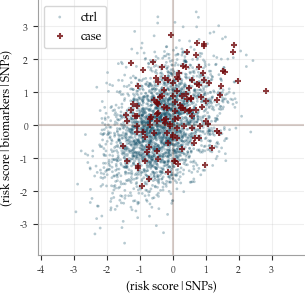

In [402]:
fig, axs = plt.subplots(1, 1, figsize=inch(250, 245))
# diab_pgs_df.plot.scatter(x="SCORE_mean", y="diabetes_type2", s=3, alpha=0.5, c = colors[diab_pgs_df["PHEN"]])
ax = diab_pgs_df2.query("PHEN == 0").plot.scatter(x="SCORE_mean", y="diabetes_type2", s=4, alpha=0.3, ax=axs, label="ctrl", color=colors[1], edgecolor="none")
diab_pgs_df2.query("PHEN == 1").plot.scatter(x="SCORE_mean", y="diabetes_type2", marker='+', label="case", s=20, alpha=0.8, ax=ax, c=colors[0]);
axs.axis('equal')
# axs.grid(alpha=0.5)
grid_alpha = 0.2
ax_col = colors[2]
axs.axhline(y=0, color=ax_col, alpha=grid_alpha)
axs.axvline(x=0, color=ax_col, alpha=grid_alpha)
plt.legend(loc="upper left")
# plt.title("Diabetes type 2: PRS on trait vs PRS from PGS of blood markers")
plt.xlabel("PRS")
plt.ylabel("gBMRS");
# plt.xlim([-4, 4])

In [403]:
# fig.savefig("FiguresV2/prsSNP_vs_prsPGS_diabetes2.pdf")

Linear regression

In [404]:
diab_linreg = LinearRegression(fit_intercept=False).fit(diab_pgs_df2["SCORE_mean"].to_numpy()[:, None], diab_pgs_df2["diabetes_type2"])
diab_linreg.coef_

array([0.3854602])

Correlation

In [405]:
diab_pgs_df2[["SCORE_mean", "diabetes_type2"]].corr()

,SCORE_mean,diabetes_type2
SCORE_mean,1.000000,0.368404
diabetes_type2,0.368404,1.000000


In [178]:
# diab_pgs_df2[["SCORE_mean", "diabetes_type2"]].corr()

,SCORE_mean,diabetes_type2
SCORE_mean,1.000000,0.370948
diabetes_type2,0.370948,1.000000


AUCs

In [408]:
diab_pgs_df2["ANCESTRY"].unique()   ,   diab_pgs_df2.index.isin(pr.cohorts["eid.withinSibPairs"].to_numpy()).all()

(array(['white'], dtype=object), True)

In [406]:
list(map(lambda s: roc_auc_score(diab_pgs_df2["PHEN"], s), [diab_pgs_df2["SCORE_mean"], diab_pgs_df2["diabetes_type2"]]))

[0.6339314221857326, 0.6450493751140304]

Combine PRSs?

In [410]:
rel_cols = ["SCORE_mean", "diabetes_type2"]
diab_pgs_df2["combo"] = z_score(diab_pgs_df2[rel_cols]).sum(axis=1)

In [411]:
tmp = z_score(diab_pgs_df2[rel_cols])
diab_pgs_df2["multi"] = tmp.iloc[:, 0] * tmp.iloc[:, 1]

In [412]:
tmp = diab_pgs_df2[rel_cols + ["combo", "multi"]].agg(lambda s: roc_auc_score(diab_pgs_df2["PHEN"], s)).rename("AUCs")
tmp.index = ["trait", "blood", "combo", "multi"]
tmp

trait    0.633931
blood    0.645049
combo    0.667305
multi    0.533260
Name: AUCs, dtype: float64

In [418]:
pgs2s.agg(lambda s: roc_auc_score(diab_pgs_df2["PHEN"], s))

diabetes_type2.1    0.645300
diabetes_type2.2    0.645049
diabetes_type2.3    0.644881
diabetes_type2.4    0.645032
diabetes_type2.5    0.645212
dtype: float64

# Sibling tests

In [228]:
sibs = pr.cohorts["sibPairs"]

In [229]:
ok_pair_mask = sibs.isin(pr.ancestry.index).all(axis=1)
ok_sibs = sibs.loc[ok_pair_mask]

In [230]:
def sibs_of_ancestry(anc):
    mask = (ok_sibs.applymap(lambda s: pr.ancestry.loc[s, "ANCESTRY"]) == anc).all(axis=1)
    return ok_sibs.loc[mask]

In [231]:
sibs_w = sibs_of_ancestry('white')

## Sib: PGS

- Correlation between difference in PHEN and difference in PGS between sibling pairs.
- fractions called correctly (who has higher?)
    - random pairs
    - sib pairs
    - sib pairs with delta_phen > 0.5, 1, 1.5

In [232]:
sib_scores = scores.loc[scores.index.get_level_values(1).isin(pr.cohorts["eid.withinSibPairs"])].swaplevel(0, 1).sort_index()

In [233]:
sib_scores_rel = sib_scores.filter(regex="PHEN|SCORE")

In [234]:
def calc_diffs(data, pairs):
    dfs = []
    data_eids = data.index.to_frame()['eid'] if isinstance(data.index, pd.MultiIndex) else data.index
    if isinstance(data.index, pd.MultiIndex):
        # PODO: can probably optimize the multiindex performance by "aligning" multiindices and subtract
        for n in range(len(pairs)):
            if pairs.iloc[n].isin(data_eids).all():
                print_tmp(n)
                pair_eids = tuple(pairs.iloc[n].to_list())
                diff = (data.loc[pair_eids[0]] - data.loc[pair_eids[1]]).dropna()
                old_idx = diff.index.to_frame()
                old_idx.insert(0, "pairs", [pair_eids]*len(diff))
                diff.index = pd.MultiIndex.from_frame(old_idx)
                dfs.append(diff)
        if dfs:
            return pd.concat(dfs)
    else: # if not multi index
        pairs_in_data = pairs.loc[pairs.isin(data.index).all(axis=1)]
        return (data.loc[pairs_in_data.iloc[:, 0]] - data.loc[pairs_in_data.iloc[:, 1]].to_numpy()).\
                set_axis(pairs_in_data.apply(tuple, axis=1))
    
    return pd.DataFrame()

In [236]:
start = time()
sib_diffs = calc_diffs(sib_scores_rel, sibs)
print(time() - start)

22666
490.48131680488586


In [237]:
# pickle.dump(sib_diffs, open("VarsBiomarkersV2/sib_diffs.p", "wb"))

In [299]:
sib_diffs = pickle.load(open('VarsBiomarkersV2/sib_diffs.p', 'rb'))
random_diffs = pickle.load(open('VarsBiomarkersV2/random_diffs.p', 'rb'))

Create random pairs

In [238]:
random_pairs = sibs.copy()
random_pairs[1] = sibs[1].sample(frac=1).reset_index(drop=True)

In [239]:
start = time()
random_diffs = calc_diffs(sib_scores_rel, random_pairs)
print(time() - start)

22666
773.6493504047394


In [240]:
# pickle.dump(random_diffs, open("VarsBiomarkersV2/random_diffs.p", "wb"))

In [241]:
sib_diffs_corr = sib_diffs.groupby(level=1).corr()["PHEN"].unstack()

In [242]:
sib_diffs_corr_ms = sib_diffs_corr.filter(regex=r"SCORE_\d").agg(['mean', 'std'], axis=1).sort_values("mean", ascending=False)

In [243]:
random_diffs_corr = random_diffs.groupby(level=1).corr()["PHEN"].unstack()
random_diffs_corr_ms = random_diffs_corr.filter(regex=r"SCORE_\d").agg(['mean', 'std'], axis=1).sort_values('mean', ascending=False)

Subset to white only

In [244]:
start = time()
sib_diffs_w = calc_diffs(sib_scores_rel, sibs_w)
print(time() - start)

21750
733.9513499736786


In [245]:
random_pairs_w = sibs_w.copy()
random_pairs_w[1] = sibs_w[1].sample(frac=1).reset_index(drop=True)

In [246]:
start = time()
random_diffs_w = calc_diffs(sib_scores_rel, random_pairs_w)
print(time() - start)

20877
815.5988974571228


In [248]:
# pickle.dump(sib_diffs_w, open("VarsBiomarkersV2/sib_diffs_w.p", "wb"))
# pickle.dump(random_diffs_w, open("VarsBiomarkersV2/random_diffs_w", "wb"))

In [249]:
sib_diffs_corr_w = sib_diffs_w.groupby(level=1).corr()["PHEN"].unstack()

In [250]:
sib_diffs_corr_ms_w = sib_diffs_corr_w.filter(regex=r"SCORE_\d").agg(['mean', 'std'], axis=1).sort_values("mean", ascending=False)

In [251]:
random_diffs_corr_w = random_diffs_w.groupby(level=1).corr()["PHEN"].unstack()
random_diffs_corr_ms_w = random_diffs_corr_w.filter(regex=r"SCORE_\d").agg(['mean', 'std'], axis=1).sort_values('mean', ascending=False)

Zoom in on sib pairs with large differences

In [252]:
def pair_diff_larger_than_apply(pair_diff, n_stds):
#     print_tmp(type(pair_diff))
    lim = n_stds * scores.loc[pair_diff.name, "PHEN"].std()
    return pair_diff.loc[pair_diff["PHEN"].abs() >= lim].droplevel(1)

def sib_diff_larger_than(n_stds):
    return sib_diffs.groupby(level=1).apply(lambda dfl: pair_diff_larger_than_apply(dfl, n_stds))

def sib_diff_corr_ms_larger_than(n_stds):
    df = sib_diff_larger_than(n_stds)
    return df.groupby(level=0).corr()['PHEN'].unstack().filter(regex=r"SCORE_\d").agg(['mean', 'std'], axis=1).sort_values('mean', ascending=False)

In [253]:
def sib_diff_larger_than_w(n_stds):
    return sib_diffs_w.groupby(level=1).apply(lambda dfl: pair_diff_larger_than_apply(dfl, n_stds))

def sib_diff_corr_ms_larger_than_w(n_stds):
    df = sib_diff_larger_than_w(n_stds)
    return df.groupby(level=0).corr()['PHEN'].unstack().filter(regex=r"SCORE_\d").agg(['mean', 'std'], axis=1).sort_values('mean', ascending=False)

### Joint plot

In [254]:
diff_ms_dfs = {
    "random": random_diffs_corr_ms, 
    "sib": sib_diffs_corr_ms, 
    "sib_0.5": sib_diff_corr_ms_larger_than(0.5),
    "sib_1.0": sib_diff_corr_ms_larger_than(1.0),
    "sib_1.5": sib_diff_corr_ms_larger_than(1.5),    
}

diff_dfs = {
    "random": random_diffs.swaplevel(0, 1), 
    "sib": sib_diffs.swaplevel(0, 1), 
    "sib_0.5": sib_diff_larger_than(0.5),
    "sib_1.0": sib_diff_larger_than(1.0),
    "sib_1.5": sib_diff_larger_than(1.5),    
}

diffs_corr_ms = pd.concat(diff_ms_dfs, axis=1)

In [255]:
diff_ms_dfs_w = {
    "random": random_diffs_corr_ms_w, 
    "sib": sib_diffs_corr_ms_w, 
    "sib_0.5": sib_diff_corr_ms_larger_than_w(0.5),
    "sib_1.0": sib_diff_corr_ms_larger_than_w(1.0),
    "sib_1.5": sib_diff_corr_ms_larger_than_w(1.5),    
}

diff_dfs_w = {
    "random": random_diffs_w.swaplevel(0, 1), 
    "sib": sib_diffs_w.swaplevel(0, 1), 
    "sib_0.5": sib_diff_larger_than_w(0.5),
    "sib_1.0": sib_diff_larger_than_w(1.0),
    "sib_1.5": sib_diff_larger_than_w(1.5),    
}

diffs_corr_ms_w = pd.concat(diff_ms_dfs_w, axis=1)

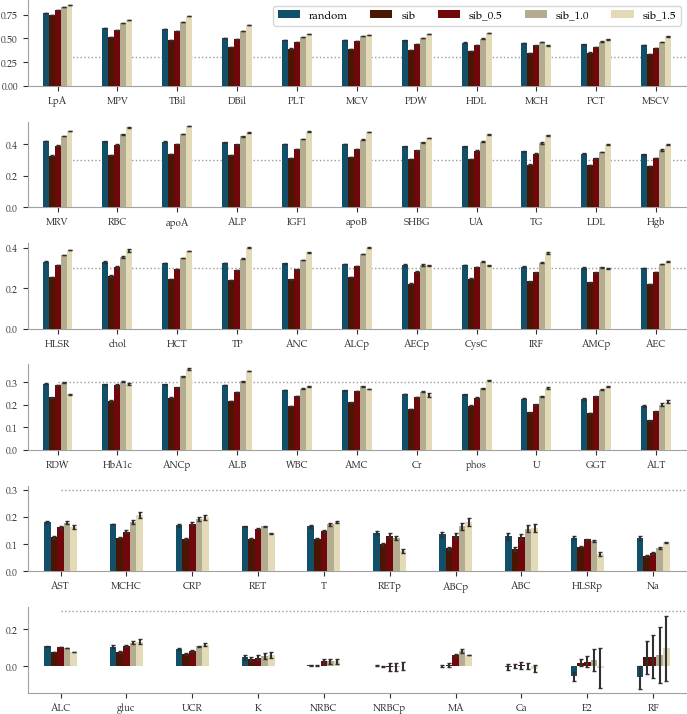

In [256]:
n_axes = 6
fig, axs = plt.subplots(n_axes, 1, figsize=inch(520, 6/4*360))
# plot_idx = np.ceil(np.linspace(1,48, n_axes + 1)).astype(int)
# plot_idx[0] = 0
dfs = np.array_split(diffs_corr_ms_w.swaplevel(0, 1, 1), n_axes)
# tmp_colors = colors[[1, 2, 0, 8, 4]]
# tmp_colors = colors[[1, 2, 0, 3, 7]]
tmp_colors = colors[[1, 2, 0, 3, 7]]
for n in range(n_axes):
    dfs[n]["mean"].rename(index=new_abbr_map).plot.bar(ax=axs[n], yerr=dfs[n]['std'].rename(index=new_abbr_map), capsize=1.7,
                            legend=False, grid=False, color=tmp_colors,
                           rot=0, zorder=3);
    plt.sca(axs[n])
    hline(0, 11.5, 0.3)
# plt.suptitle(r"Correlation $\Delta_{\mathrm{phen}}, \Delta_{\mathrm{PGS}}$");
axs[0].legend(list(diff_ms_dfs.keys()), ncol=5, fontsize=8)
plt.tight_layout()

In [257]:
fig.savefig("FiguresV2/sib_pgs_corrs.pdf")

Only top row

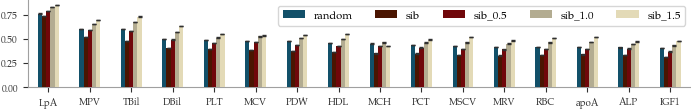

In [258]:
n_axes = 1
fig, axs = plt.subplots(n_axes, 1, figsize=inch(520, 100))
# plot_idx = np.ceil(np.linspace(1,48, n_axes + 1)).astype(int)
# plot_idx[0] = 0
dfs = np.array_split(diffs_corr_ms_w.swaplevel(0, 1, 1), 4)
# tmp_colors = colors[[1, 2, 0, 8, 4]]
# tmp_colors = colors[[1, 2, 0, 3, 7]]
tmp_colors = colors[[1, 2, 0, 3, 7]]
for n in range(n_axes):
    dfs[n]["mean"].rename(index=new_abbr_map).plot.bar(ax=axs, yerr=dfs[n]['std'].rename(index=new_abbr_map), capsize=1.7,
                            legend=False, grid=False, color=tmp_colors,
                           rot=0, zorder=3);
    plt.sca(axs)
#     hline(0, 11.5, 0.3)
    break
# plt.suptitle(r"Correlation $\Delta_{\mathrm{phen}}, \Delta_{\mathrm{PGS}}$");
axs.legend(list(diff_ms_dfs.keys()), ncol=5, fontsize=8)
plt.tight_layout()

In [259]:
fig.savefig("FiguresV2/sib_pgs_corrs_topRow.pdf")

In [260]:
(diffs_corr_ms[('sib', 'mean')]/diffs_corr_ms[('random', 'mean')]).head(46).mean()

0.784473433170535

#### Table

In [261]:
diff_sizes_w = pd.DataFrame({k: df.groupby(level=0).size() for k, df in diff_dfs_w.items()})

In [262]:
_eids = []
for t in diff_dfs_w['sib'].loc['alan'].index.get_level_values(0):
    _eids.append(t[0])
    _eids.append(t[1])
    
pr.ancestry.loc[pr.ancestry.index.isin(_eids), "ANCESTRY"].unique()

array(['white'], dtype=object)

In [263]:
def tab_reshape(df, n_cols):
    new_df = pd.concat([_df.reset_index() for _df in np.array_split(df, 2)], axis=1)
    return new_df.to_latex(index=False)

In [264]:
print(tab_reshape(diff_sizes_w.rename(index=new_abbr_map).sort_index(key=lambda s: s.str.lower()), 2))

\begin{tabular}{lrrrrrlrrrrr}
\toprule
  abbr &  random &    sib &  sib\_0.5 &  sib\_1.0 &  sib\_1.5 &   abbr &  random &    sib &  sib\_0.5 &  sib\_1.0 &  sib\_1.5 \\
\midrule
   ABC &   19645 &  20469 &     8442 &     4631 &     2992 &    IRF &   19146 &  19974 &    13388 &     8011 &     4163 \\
  ABCp &   19645 &  20469 &     7932 &     3398 &     1666 &      K &   19622 &  20465 &    14023 &     8984 &     5416 \\
   AEC &   19645 &  20469 &    10512 &     4714 &     2189 &    LDL &   19016 &  19829 &    13478 &     8319 &     4589 \\
  AECp &   19645 &  20469 &    10598 &     5097 &     2550 &    LpA &   12265 &  13386 &     4967 &     2921 &     2116 \\
   ALB &   16129 &  16861 &    11401 &     6889 &     3668 &     MA &    1863 &   2173 &      187 &       99 &       60 \\
   ALC &   19645 &  20469 &     6964 &     1623 &      403 &    MCH &   19701 &  20527 &    10702 &     4508 &     1778 \\
  ALCp &   19645 &  20469 &    13359 &     7490 &     3637 &   MCHC &   19700 &  2052

## Sib: BRS and BPRS

In [267]:
sibs_xor = {cond: sibPairs_cc(cc[cond], logic_op='xor') for cond in cc}

In [268]:
sibs_xor_eids = {cond: df[0].append(df[1], ignore_index=True) for cond, df in sibs_xor.items()}

In [269]:
fsize_sib_xor = inch(150, 150)

### Sib: brs

In [272]:
tmp = wpap_brs_df.unstack()
_df = pd.concat({l: tmp.loc[l] for l in tmp.index}, axis=1)

Mixing sexes

In [273]:
z_pap_brs = z_score(_df).stack(1).reset_index(level=1, drop=True)

In [274]:
start = time()
z_brs_sib_diff = calc_diffs(z_pap_brs, sibs_w)
print(time() - start)

0.04723691940307617


In [275]:
start = time()
z_brs_random_diff = calc_diffs(z_pap_brs, random_pairs_w)
print(time() - start)

0.04573369026184082


In [276]:
start = time()
cc_diffs = calc_diffs(cc, sibs_w)
print(time() - start)

0.2573506832122803


In [ ]:
cc_diffs.loc[cc_diffs.index.isin(sibs_w.apply(tuple, axis=1).to_list())]

In [289]:
frac_brs_sibs_called = {}
n_pairs = {}
start = time()
for cond in sibs_xor:
    start_cond = time()
    pairs = sibs_xor[cond][[0, 1]].apply(tuple, axis=1)
    tmp = z_brs_sib_diff.loc[z_brs_sib_diff.index.isin(pairs), cond].mul(cc_diffs.loc[cc_diffs.index.isin(pairs), cond], axis=0).dropna()
#     tmp2 = (bprs_diffs.loc[bprs_diffs.index.isin(pairs), ccol] * cc_diffs.loc[pairs, ccol]).dropna()
    n_pairs[cond] = len(tmp)
    frac_brs_sibs_called[cond] = (tmp > 0).mean()
#     print_tmp(cond, time() - start, time() - start_cond)
#     print(len(pairs), len(tmp))

frac_brs_sibs_called = pd.DataFrame({"call_fracs": frac_brs_sibs_called, "mean": pd.DataFrame(frac_brs_sibs_called).mean(), "std": pd.DataFrame(frac_brs_sibs_called).std(), "n_pairs": n_pairs})

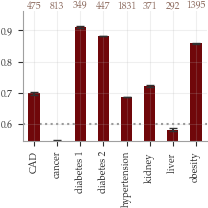

In [290]:
_fbrs = frac_brs_sibs_called.drop(index="diabetes")
ax = _fbrs.rename(index=cond_to_print).plot.bar(y="mean", yerr="std", figsize=fsize_sib_xor, legend=None)
for n, n_p in enumerate(_fbrs["n_pairs"].values):
    plt.text(ax.get_xticks()[n], ax.get_ylim()[1], str(n_p),
            fontsize="x-small", ha="center", va="bottom", color=colors[2] + "a0")
ax.hlines(0.6, *ax.get_xlim(), linestyle=":", color='0.6', zorder=0)
plt.ylim(bottom=_fbrs["mean"].min())
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
fig = plt.gcf()

In [291]:
fig.savefig("FiguresV2/sib_xor_brs.pdf")

### Sib: bprs

pap_bprs is a dataframe of lists of series

In [292]:
tmp = wpap_bprs_df.unstack()
_df = pd.concat({l: pd.DataFrame(tmp.loc[l]).T for l in tmp.index}, axis=1)

Mixing sexes

In [293]:
z_pap_bprs = z_score(_df).stack(1).reset_index(level=1, drop=True)

In [294]:
start = time()
z_bprs_sib_diff = calc_diffs(z_pap_bprs, sibs)
print(time() - start)

0.013072729110717773


In [296]:
frac_bprs_sibs_called = {}
n_pairs = {}
start = time()
for cond in sibs_xor:
    start_cond = time()
    pairs = sibs_xor[cond][[0, 1]].apply(tuple, axis=1)
    tmp = z_bprs_sib_diff.loc[z_bprs_sib_diff.index.isin(pairs), cond].mul(cc_diffs.loc[cc_diffs.index.isin(pairs), cond], axis=0).dropna()
#     tmp2 = (bprs_diffs.loc[bprs_diffs.index.isin(pairs), ccol] * cc_diffs.loc[pairs, ccol]).dropna()
    n_pairs[cond] = len(tmp)
    frac_bprs_sibs_called[cond] = (tmp > 0).mean()
#     print_tmp(cond, time() - start, time() - start_cond)
#     print(len(pairs), len(tmp))

frac_bprs_sibs_called = pd.DataFrame({"call_fracs": frac_bprs_sibs_called, "mean": pd.DataFrame(frac_bprs_sibs_called).mean(), "std": pd.DataFrame(frac_bprs_sibs_called).std(), "n_pairs": n_pairs})

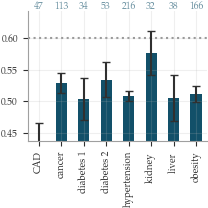

In [297]:
_fbprs = frac_bprs_sibs_called.drop(index='diabetes')
ax = _fbprs.rename(index=cond_to_print).plot.bar(y="mean", yerr="std", figsize=fsize_sib_xor, color=colors[1], legend=None)
for n, n_p in enumerate(_fbprs["n_pairs"].values):
    plt.text(ax.get_xticks()[n], ax.get_ylim()[1], str(n_p),
            fontsize="x-small", ha="center", va="bottom", color=colors[1] + "a0")
ax.hlines(0.6, *ax.get_xlim(), linestyle=":", color='0.6', zorder=0)
plt.ylim(bottom=_fbprs["mean"].min())
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
fig = plt.gcf()

In [298]:
fig.savefig("FiguresV2/sib_xor_bprs.pdf")

# Genetic architecture

Choose 5 top predictors and check genetic architecture.
- Where are the top SNPs located?
- Are there known SNPs within certain range from our top SNPs?
- Are there known SNPs that we are not picking up?

In [300]:
beta_files = {}
for ab in fields['abbr']:
    tmpdir = dir_lou_siblingGP + abbr_to_lou(ab) +"/"
    beta_files[ab] = (tmpdir,
                    nip.all_files_in_dir_containing(tmpdir, "^beta")
                     )
    

In [347]:
beta_files["vitD"][1][0]

'beta.bioMarkers2.30.3.txt'

In [349]:
def get_beta_name(fn):
    return "BETA_" + re.search(r"bioMarkers(\d+)\.(\d+)\.(\d+)\.txt", fn)[3]

list(map(get_beta_name, beta_files["vitD"][1]))

['BETA_3', 'BETA_4']

In [350]:
betas = {}
beta_cols = ["CHR", "SNP", "?", "BP", "A1", "A2", "geno_mean", "BETA"]
for ab in blood2.columns: # ga_top_abbrs.index:
    print_tmp(ab)
    betas[ab] = [
        pd.read_csv(beta_files[ab][0] + fn,
                   sep=' ', header=None)\
#         .set_axis(beta_cols, axis=1).rename(columns={"BETA": f"BETA_{n+1}"})
        .set_axis(beta_cols, axis=1).rename(columns={"BETA": get_beta_name(fn)})
        for n, fn in enumerate(beta_files[ab][1])
    ]

vitD


In [354]:
cols_to_exclude = ["geno_mean"]
cols_to_merge = [c for c in beta_cols if c not in cols_to_exclude and c != 'BETA']
def beta_merge(df1, df2):
    return df1.merge(
                    df2.drop(columns=cols_to_exclude), on=cols_to_merge, how='outer'
                    ).fillna(0.0)

betas_df = {}
for ab in betas:
    betas_df[ab] = reduce(beta_merge, betas[ab]).drop(
        columns=["?", "A1", "A2"]).set_index("SNP")#\
#     .sort_values("BETA_1", ascending=False)
    
betas_df = pd.concat(betas_df)

In [114]:
bs = [f"BETA_{n}" for n in range(1, 6)]

#### SNP Loci

In [303]:
def top_snps(abbr, n=10, cv_fold=1, beta_col=None):
    if beta_col is not None:
        col = beta_col
    else:
        col = f"BETA_{cv_fold}"
    return betas_df.loc[abbr].sort_values(col, ascending=False, key=np.abs).head(n)

def top_snpnexus(*args, **kwargs):
    tmp = pd.DataFrame(top_snps(*args, **kwargs).index)
    tmp[1] = 'dbsnp'
    tmp = tmp[[1, 'SNP']]
#     tmp.to_clipboard(sep="\t", header=False, index=False)
    return tmp.set_index(1)

In [615]:
gwas = {}
abbr = 'ldl'
_name = abbr_to_lou('dbili')
gwas[abbr] = pd.read_csv(dir_lou_siblingGP + _name + f"/gwas.{_name}.1.csv",
                    sep=",")

In [304]:
def var_accounted_for(beta_df, beta_col, query=None, loc=None):
    if query is not None:
        sdf = beta_df.query(query)
    elif loc is not None:
        sdf = beta_df.loc[loc]
    else:
        raise Exception("No subset given")
        
    sub_beta2 = sdf[beta_col].pow(2)
    sub_maf = 1 - sdf["geno_mean"]/2
    sub_var = 2*sub_beta2*(1 - sub_maf)*sub_maf
    beta2 = beta_df[beta_col].pow(2)
    maf = 1 - beta_df["geno_mean"]/2
    var = 2*beta2*(1 - maf)*maf
    return sub_var.sum()/var.sum()

def beta_by_chrom(abbr, beta_col="BETA_1"):
    return betas_df.loc[abbr].groupby("CHR")[beta_col].agg(
                count='count',
                sum_beta=lambda s: s.abs().sum(),
                var_acc=lambda s: var_accounted_for(betas_df.loc[abbr], beta_col, loc=s.index)
            ).sort_values('var_acc', ascending=False)

In [339]:
def plot_var_acc(abbr, beta_col, n_snp_lim=None, query=None, locs=None, top=True, x=None,
                **plot_kws):
    '''Plot variance accounted for. '''
    if n_snp_lim is not None:
        n_max = min(n_snp_lim, len(betas_df.loc[abbr]))
    
    if locs is None:
        if top:
            locs = top_snps(abbr, n_max, beta_col=beta_col).index
        else:
            locs = betas_df.loc[abbr].sort_values(["CHR", "BP"]).index
            
    step = 1 + int(n_max/70)
    n_snps = np.arange(1, n_max + 1, step)
    var_accs = [var_accounted_for(betas_df.loc[abbr], beta_col, loc=locs[:x])
               for x in n_snps]

    if x is None:
        x = n_snps
    else:
        x = x[n_snps-1]
    plt.plot(x, var_accs, **plot_kws)
    if top:
        plt.xlabel("#SNPs")

#### Manhattan plots

In [306]:
chrom_df = pd.read_csv("path/to/chromosomeLength.csv", header=0, sep="\t")
chrom_df = chrom_df.set_index("CHR")
# print(chrom_df.dtypes)
chrom_df.head(2)

,BP,Cumulative,acum BP
CHR,,,
1,248956422,7.9,0
2,242193529,16.2,248956422


In [307]:
chrom_df["minorTick"] = chrom_df["acum BP"] + chrom_df["BP"]/2

In [308]:
def x_coord_from_chr_bp(c, bp):
    if c > 22:
        raise Exception(f"Can't handle c > 22 for the moment. Got {c}.")

    return chrom_df.loc[str(int(c)), "acum BP"] + bp

def x_coord(row):
    return x_coord_from_chr_bp(row["CHR"], row["BP"])

def chrom_cmap(chrom):
#     cm = plt.get_cmap("Dark2")
    val = (chrom-1)%3
#     ret = cm(val)
    ret = colors[val]
    
    # Gray version
#     ret = "#000000" if chrom%2 else "#222288"
#     ret = "#202020" if chrom%2 else colors[1]
#     ret = "#555565" if chrom%2 else '#202020'
#     ret = "#2f434b" if chrom%2 else '#202020'
    ret = "#3D5761" if chrom%2 else '#202020'
    return ret

def size_from_y(y):
    base_size = 20
    lim_size = {0.2: 5/3*base_size, 0.4: 7/3*base_size}
    if isinstance(y, pd.Series):
        s = y.copy()
        s.iloc[:] = base_size
        for l in sorted(list(lim_size.keys())):
            mask = y.abs() > l
            s[mask] = lim_size[l]
        
        return s.to_numpy()
    for l in sorted(list(lim_size.keys()), reverse=True):
        if np.abs(y) > l:
            return lim_size[l]

    return base_size

def manhattan(data, y_label, chrom="CHR", bp="BP", log=False, scatter_kws=None):
    if scatter_kws is None:
        scatter_kws = {
            "marker": '.',
            "edgecolors": "none",
            "alpha": 0.6,
            "s": size_from_y(data[y_label]),
            "c": data[chrom].apply(chrom_cmap).to_numpy(),
        }
        

    x = data.apply(x_coord, axis=1).to_numpy()
    if log:
        y = np.log(data[y_label].abs().to_numpy())
    else:
        y = data[y_label].to_numpy()

    plt.scatter(x, y,
               **scatter_kws)
    # x-ticks
    ax = plt.gca()
    plt.xticks(ticks=chrom_df.loc[:"22", "acum BP"])
    ax.set_xticks(chrom_df.loc[:"22", "minorTick"], minor=True);
    ax.set_xticklabels(chrom_df.loc[:"22"].index, minor=True)
    ax.set_xticklabels("")
    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('center')
#     plt.xticks(ticks=chrom_df.loc[:"22", "acum BP"],
#                labels=chrom_df.loc[:"22"].index);    

hdl


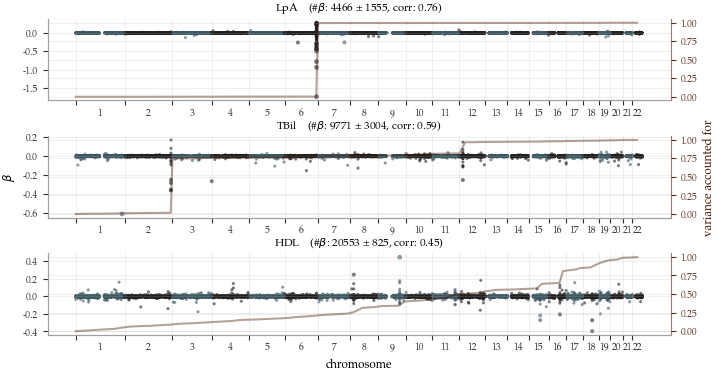

In [356]:
fsize = inch(520, 270)
# for m, ab in enumerate(sorted(blood.columns)):
# for m, ab in enumerate(ga_top_abbrs.index):
label_nr = 1
n_plots = 3
beta_cols = score_corrs.loc[(slice(None), "white", "PHEN")].filter(regex=r"SCORE_\d").idxmax(axis=1)
for m, ab in enumerate(["lipoA", "tbili", "hdl"]):
    print_tmp(ab)
    if m%n_plots == 0:
        fig, axs = plt.subplots(n_plots, 1, figsize=fsize)
        
    n = m%n_plots + 1

    tmp = betas_df.loc[ab]
    plt.subplot(n_plots, 1, n)
#     beta_col = "BETA_1"
    beta_col = beta_cols[ab].replace("SCORE", "BETA")
    manhattan(tmp.loc[tmp[beta_col].abs() > 0], beta_col, log=False)
    if m == label_nr:
        plt.ylabel(r'$\beta$')
    if m == n_plots - 1:
        plt.xlabel('chromosome')

    # Variance accounted for
    plt.locator_params(axis='y', nbins=5)
    plt.gca().twinx()
    x = tmp.sort_values(["CHR", "BP"]).apply(x_coord, axis=1).to_numpy()
    plot_var_acc(ab, beta_col, n_snp_lim=int(1e5), top=False, x=x, alpha=.4, color=colors[2])
    plt.gca().spines['right'].set_visible(True)
    _color = colors[2] + 'e0'
    plt.gca().spines['right'].set_color(_color[:-2] + '90')
    plt.gca().tick_params(axis='y', colors=_color)
    plt.locator_params(axis='y', nbins=5)

    # Decorations
    tmp_corr = score_corrs.loc[(ab, 'white', 'SCORE_mean'), "PHEN"]
#     plt.text(1.0, 0.05, f"{tmp_corr:.2}",
#              ha='right', va='bottom',
#              transform=plt.gca().transAxes)
#     tmp_n = (tmp[beta_col].abs() > 0).sum()
    tmp_n = (tmp.filter(regex=r"BETA_\d").abs() > 0).sum().agg(["mean", "std"])
    if ab in ga_top_abbrs.index:
        fontdict = {'fontweight': 'bold', 'color': colors[2]}
    else:
        fontdict = {}
    plt.title(fr"{new_abbr_map[ab]}    (#$\beta$: {int(tmp_n['mean'])} ± {int(tmp_n['std'])}, corr: {tmp_corr:.2})", {'fontsize': 8})
    if m == label_nr:
        plt.ylabel('variance accounted for', color=colors[2])
    if m%n_plots == n_plots - 1:
        plt.tight_layout(pad=0, w_pad=0)
        

In [357]:
fig.savefig('FiguresV2/manhattan_top3.pdf')
# fig.savefig('Figures/manhattan_top5.pdf')

In [311]:
[k for k in plt.rcParams if "dpi" in k.lower()]
plt.rcParams["savefig.dpi"] =  300

In [ ]:
# all manhattan plots
fsize = inch(520, 700)
label_nr = 3
n_plots = 8
start = time()
beta_cols = score_corrs.loc[(slice(None), "white", "PHEN")].filter(regex=r"SCORE_\d").idxmax(axis=1)
# for m, ab in enumerate(["white"]):
#     all_labels = True
for m, ab in enumerate(fields.sort_values("new_abbr", key=lambda s: s.str.lower())["abbr"]):
    all_labels = False
    start_ab = time()
    if m%n_plots == 0:
        fig, axs = plt.subplots(8, 1, figsize=fsize)
        
    n = m%n_plots + 1

    tmp = betas_df.loc[ab]
    plt.subplot(n_plots, 1, n)
#     beta_col = "BETA_1"
    beta_col = beta_cols[ab].replace("SCORE", "BETA")
    manhattan(tmp.loc[tmp[beta_col].abs() > 0], beta_col, log=False)
    if m % n_plots == label_nr or all_labels:
        plt.ylabel(r'$\beta$')
    if m%n_plots == n_plots - 1 or all_labels:
        plt.xlabel('chromosome')
    # Variance accounted for
    plt.locator_params(axis='y', nbins=5)
    plt.gca().twinx()
    x = tmp.sort_values(["CHR", "BP"]).apply(x_coord, axis=1).to_numpy()
    plot_var_acc(ab, beta_col, n_snp_lim=int(1e5), top=False, x=x, alpha=.4, color=colors[2])
    plt.gca().spines['right'].set_visible(True)
    _color = colors[2] + 'e0'
    plt.gca().spines['right'].set_color(_color[:-2] + '90')
    plt.gca().tick_params(axis='y', colors=_color)
    plt.locator_params(axis='y', nbins=5)

    # Decorations
    tmp_corr = score_corrs.loc[(ab, 'white', 'SCORE_mean'), "PHEN"]
#     plt.text(1.0, 0.05, f"{tmp_corr:.2}",
#              ha='right', va='bottom',
#              transform=plt.gca().transAxes)
    tmp_n = (tmp.filter(regex=r"BETA_\d").abs() > 0).sum().agg(["mean", "std"])
    if ab in ga_top_abbrs.index:
        fontdict = {'fontweight': 'bold', 'color': colors[2]}
    else:
        fontdict = {}
    plt.title(fr"{new_abbr_map[ab]}    (#$\beta$: {int(tmp_n['mean'])} ± {int(tmp_n['std'])}, corr: {tmp_corr:.2})", {'fontsize': 8})
    if m%n_plots == label_nr or all_labels:
        plt.ylabel('variance accounted for', color=colors[2])
#     if m == n_plots - 1:
#         plt.xlabel('chromosome')
    
#     plt.tight_layout()
#     fig.savefig(f"FiguresV2/supp_manhattan_9.png")
#     break
    if m%n_plots == n_plots - 1:
        plt.tight_layout()#(pad=0, w_pad=0)
        fig.savefig(f"FiguresV2/supp_manhattan_{int((m+1)/n_plots)}.png")
#         fig.savefig("FiguresV2/testtest2.png")
#         break
    
    print_tmp(ab + " done:", time() - start, time() - start_ab)

In [530]:
# fig.savefig("FiguresV2/testtest.png")

In [328]:
def show_rows(data, n_rows=70):
    with pd.option_context("display.max_rows", n_rows):
        display(data)

## PCA correction

Investigae whether PCA impacts the BRS.
- make PCA corrected phenotypes
- train new predictors on the corrected phens
- evaluate new predictors
- train predictor directly on case status using PCA.

### PCA corrected phen

Use proc_phen from training oof pap_predictors above.

In [153]:
# proc_phen = pr.prune(blood2, "ANCESTRY == 'white'").groupby(pr.sex["SEX"]).transform(z_score)

# age_regressions = {}
# for col in proc_phen:
#     print_tmp(col)
#     _, reg = pr.correct_for(proc_phen, pr.age.loc[proc_phen.index, "AGE-0.0"], col, new_col=col + "_corr", winsorize=3);
#     age_regressions[col] = reg

# proc_phen = proc_phen.rename(columns=lambda c: c + "_orig").rename(columns=lambda c: re.sub(r"_corr_orig", "", c))

# proc_phen = proc_phen.transform(z_score)

# abbrs_to_drop = ["micro", "oest", "rheu"]
# phen_cols = [c for c in proc_phen if not c.endswith("_orig") and c not in abbrs_to_drop]

# proc_phen[phen_cols].dropna().shape

In [556]:
pca_phen = proc_phen.copy()

In [557]:
pca_phen.ewinfo = proc_phen.ewinfo

In [542]:
_df = pd.DataFrame(np.random.rand(4, 3))
_df = _df + np.arange(3)
_df = _df.T.reset_index()

In [546]:
# pr.correct_for(_df, x=_df.iloc[:, 1:], y="index")

In [ ]:
# pca_regressions = {}
# for col in pca_phen:
#     print_tmp(col)
#     _, reg = pr.correct_for(pca_phen, pr.age.loc[pca_phen.index, "AGE-0.0"], col, new_col=col + "_corr");
#     pca_regressions[col] = reg

# proc_phen = proc_phen.rename(columns=lambda c: c + "_orig").rename(columns=lambda c: re.sub(r"_corr_orig", "", c))
# proc_phen = proc_phen.transform(z_score)

In [548]:
pr.ancestry_pca

,ANC_PCA_0,ANC_PCA_1,ANC_PCA_2,ANC_PCA_3,ANC_PCA_4,ANC_PCA_5,ANC_PCA_6,ANC_PCA_7,ANC_PCA_8,ANC_PCA_9,ANC_PCA_10,ANC_PCA_11,ANC_PCA_12,ANC_PCA_13,ANC_PCA_14,ANC_PCA_15,ANC_PCA_16,ANC_PCA_17,ANC_PCA_18,ANC_PCA_19
eid,,,,,,,,,,,,,,,,,,,,
1000012,-11.6137,4.97740,-1.63615,2.277540,2.114240,-0.578779,2.428640,1.851830,-5.437880,-1.636670,-0.048089,2.293010,-0.422768,-1.353430,0.682134,0.402667,2.877690,-0.152174,0.248236,-0.024874
1000029,-12.2241,1.21737,0.43338,-2.319290,-2.604730,1.114080,2.506040,-0.147274,-4.895640,-3.084280,-3.378210,-0.126752,0.027312,-5.989220,-0.539680,-2.929330,-2.908100,-3.521120,-0.607627,4.945400
1000031,-12.9578,3.95457,-2.44440,7.649460,9.099580,-4.056550,-2.770350,3.105540,-1.668730,2.106630,7.032750,-0.441834,0.744790,0.181002,3.245240,-3.287030,-0.571177,1.799660,3.805930,-3.032280
1000047,-11.9452,3.64888,-2.70113,-1.616210,-2.689260,0.570065,4.165940,-1.087460,0.312097,-0.653168,-2.758040,1.597370,-1.123320,0.264724,2.681820,-1.754450,-1.845960,-1.275120,4.743250,3.164010
1000050,-13.1927,1.27585,-4.06711,1.362230,0.034947,-0.619351,0.854741,-0.409637,-1.566520,-3.355620,-5.832980,1.876990,-0.172232,2.192130,-1.466010,0.978854,0.683621,2.720440,-1.567810,1.818810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6026515,-11.5299,1.70058,-2.69485,-1.891710,-6.353230,-0.632295,1.573110,-1.473200,-1.060220,-0.898156,-2.755310,-2.217640,-5.011790,-5.498780,-2.560660,0.364828,-0.482687,-4.037960,-1.814000,2.901400
6026521,-10.2056,3.28027,-2.19711,5.861510,0.011954,0.064821,-0.834210,-1.538590,-1.507450,-0.105520,2.496810,-0.106342,3.254240,0.595626,-1.895550,-8.514610,-0.568286,0.545508,-3.556100,-3.665810
6026533,-14.1822,5.42206,-1.84933,1.582180,-9.107770,0.345837,-0.099220,0.389005,0.526111,-4.740510,-0.853392,-2.004170,-1.141780,0.460938,1.982130,-4.332330,2.237250,-0.368276,3.488620,-2.366500


In [558]:
pca_regressions = {}
for col in pca_phen:
    print_tmp(col)
    _y = pca_phen[col].dropna()
    _x = pr.ancestry_pca.loc[_y.index].dropna()
    _idx = _x.index.intersection(_y.index)
    _x, _y = _x.loc[_idx], _y.loc[_idx]
    reg = LinearRegression().fit(_x, _y)
    pca_regressions[col] = reg
    pca_phen[col + "_pca"] = _y - reg.predict(_x)

vitD


In [559]:
pca_phen = pca_phen.rename(columns=lambda c: c + "_orig").rename(columns=lambda c: re.sub(r"_pca_orig", "", c))
pca_phen = pca_phen.transform(z_score)

In [560]:
ew.ewinfo(pca_phen, "|| correct for PCA || z-score")

'|| correct for PCA || z-score'

### Train on PCA corrected

In [563]:
pca_preds = {}
subset_fstring = "ANCESTRY == 'white' and SEX == {sex}"
tmp_phen = pca_phen.loc[~pca_phen.index.isin(pr.cohorts['eid.withinSibPairs'])].drop(columns=abbrs_to_drop)
start = time()
for cond in cc:
    start_cond = time()
    pca_preds[cond] = {}
    for sex in [0, 1]:
        start_sex = time()
        subset_string = subset_fstring.format(sex=sex)
        pca_preds[cond][sex] = []
        tmpX = pr.prune(tmp_phen[phen_cols].dropna(), subset_string)
        for n in range(5):
            start_n = time()
            pca_preds[cond][sex].append(LassoWrapper(description=f"{cond}:{sex} - {subset_string}", eps=0.01, n_alphas=100))
            pca_preds[cond][sex][-1].fit_to_cc(tmpX, cond)
            print_tmp(cond, sex, n, ":", time() - start, time() - start_cond, time() - start_sex, time() - start_n)

obesity 1 4 : 172.9183189868927 17.20979952812195 9.772835969924927 1.8905291557312012


In [564]:
# pickle.dump(pca_preds, open(dir_varsBiomarkersV2 + 'pca_preds.p', 'wb'))

In [97]:
pca_preds = pickle.load(open(dir_varsBiomarkersV2 + 'pca_preds.p', 'rb'))

In [565]:
pca_preds_df = pd.DataFrame({(cond, sex): pca_preds[cond][sex] for cond in pca_preds for sex in pca_preds[cond]})

#### Get prediction AUCs

In [571]:
def pca_calc_aucs(pred, ancestry=None, sex=None, ret_brs=False):
    m = re.search(r"ANCESTRY\s*==\s*'(.*)'.*SEX\s*==\s*(\d)", pred.description)
    if ancestry is None:
        ancestry = m[1]
    if sex is None:
        sex = m[2]
    subset_string = f"ANCESTRY == '{ancestry}' and SEX == {sex}"
    cond = pred.train_cond
    pred_group = pred.description.split(":")[0]
    print_tmp(pred_group, cond)
    brs_X = pca_phen[phen_cols].dropna()
    brs = pr.prune(brs_X, subset_string)
    brs = brs.loc[~brs.index.isin(pred.train_eids)]
    auc_brs = pred.auc(cc.loc[brs.index, cond], brs, subset_string)
    if ret_brs:
        y_pred_ser = pd.Series(pred.predict(brs), index=brs.index)

    return y_pred_ser if ret_brs else auc_brs

# def pca_calc_bprs_aucs(pred, ancestry=None, sex=None,  ret_bprs=False):
#     m = re.search(r"ANCESTRY\s*==\s*'(.*)'.*SEX\s*==\s*(\d)", pred.description)
#     if ancestry is None:
#         ancestry = m[1]
#     if sex is None:
#         sex = m[2]
#     subset_string = f"ANCESTRY == '{ancestry}' and SEX == {sex}"
#     cond = pred.train_cond
#     pred_group = pred.description.split(":")[0]
#     print_tmp(pred_group, cond, ancestry, sex)
#     bprs_Xs = scores_vitD_fill.filter(regex=r"SCORE_\d")
#     aucs_bprs = []
#     preds_bprs = []
#     for s in bprs_Xs:
#         bprs_X = z_score(bprs_Xs[s].unstack(0)[pred.train_cols].dropna())
#         bprs = pr.prune(bprs_X, subset_string)
#         bprs = bprs.loc[bprs.index.isin(cc.index)]
#         aucs_bprs.append(pred.auc(cc.loc[bprs.index, cond], bprs, "bprs: " + subset_string))
#         if ret_bprs:
#             y_pred_ser = pd.Series(pred.predict(bprs), index=bprs.index)
#             preds_bprs.append(y_pred_ser)

#     return preds_bprs if ret_bprs else aucs_bprs

In [574]:
pca_anc_aucs = {a: pca_preds_df.applymap(lambda p: pca_calc_aucs(p, ancestry=a)) for a in ["white"]}#, "asian", "chinese", "black"]}

obesity obesity


/mnt/home/wideneri/Piplines/Modular/phen_reader.py:22: UnderDevelopmentWarning: Interface of 'prune' might change!
  warnings.warn(f"Interface of '{fun.__name__}' might change!",


In [575]:
pca_anc_aucs_df = pd.concat(pca_anc_aucs, names=["ANCESTRY"])

In [586]:
# pickle.dump(pca_anc_aucs_df, open("VarsBiomarkersV2/pca_anc_aucs_df.p", "wb"))

Compare results with non-pca

In [585]:
_dfp = pca_anc_aucs_df.loc["white"]
_df = pap_redone_anc_aucs_df.loc["white"]

In [587]:
_diff_normed = (_df - _dfp)/_dfp

In [591]:
_diffs = _diff_normed.agg(["mean", "std"])

In [610]:
_tab = _diffs.T.apply(lambda row: f"{row['mean']:.4f} ± {row['std']:.4f}", axis=1).unstack().rename(columns={0: "women", 1: "men"}).drop("diabetes")
print(_tab.rename(cond_to_print).to_latex())

\begin{tabular}{lll}
\toprule
{} &             women &               men \\
\midrule
CAD          &   0.0027 ± 0.0160 &  -0.0088 ± 0.0063 \\
cancer       &  -0.0060 ± 0.0089 &   0.0049 ± 0.0051 \\
diabetes 1   &  -0.0068 ± 0.0026 &  -0.0006 ± 0.0042 \\
diabetes 2   &  -0.0002 ± 0.0037 &  -0.0014 ± 0.0025 \\
hypertension &  -0.0026 ± 0.0029 &   0.0005 ± 0.0024 \\
kidney       &  -0.0033 ± 0.0124 &  -0.0074 ± 0.0161 \\
liver        &  -0.0108 ± 0.0113 &  -0.0370 ± 0.0072 \\
obesity      &  -0.0004 ± 0.0011 &   0.0030 ± 0.0017 \\
\bottomrule
\end{tabular}



In [581]:
# pap_redone_anc_aucs_df = pickle.load(open("VarsBiomarkersV2/pap_redone_anc_aucs_df.p", "rb"))

# ASCVD comparison

## Functions

In [424]:
def _custom_case_control_status(self, data, case_match,
                                onset=None, match_on_coding=False):
    # TODO: fix doc string. TODO: PRINC - include in phen_reader
    # PODO:
    # - including relabeling functionality with eg data={50: "height"}?
    # - including multiple loads, i.e., different definitions but combine.
    '''
    Parameters
    ----------
    data : int, list of ints, pd.Series or pd.DataFrame
        specifies what data underlies the case/ctrl status. If int(s)
        then interpreted as fieldIDs to be read by read_feather.
        If already a pandas object, this is used directly.
    case_match : object, list thereof or function
        specifies what is a case. If not callable, matches are 
        determined by pandas .isin() (scalars are wrapped by list).
        If callable, it is passed into data.transform()
    onset : int, list of ints, pd.Series or pd.DataFrame
        specifies how to determine onset. If int(s), then taken as
        fieldIDs into read_feather, otherwise taken as is.
        The earliest onset available for each eid is choosen.
    match_on_coding : bool or int optional [False]
        match case_match on the coding values for field, 
        rather than field data.
        If boolean True, match on coding corresponding to data 
        interpreted as fieldID. If int, use this as codingID.
        
    Returns
    -------
    dataframe
        TODO
    '''

    def match_fun(d, m):
        if callable(m):
            d = d.transform(m).astype(int)
        else:
            try:
                d = d.isin(m).astype(int)
            except TypeError:
                d = d.isin([m]).astype(int)
        return d
    
    in_data = data
    if not isinstance(data, (pd.Series, pd.DataFrame)):
        data = self.read_feather(fieldIDs=data)
    
    if match_on_coding:
        if isinstance(match_on_coding, bool):
            if isinstance(in_data, int):
                coding = self.codings(fieldID=in_data)
            else:
                raise Exception(
                    "data must be int if match_on_coding = True,"
                    + f" was {type(in_data)}")
        elif isinstance(match_on_coding, int):
            coding = self.codings(codingID=match_on_coding)
        else:
            raise Exception(
            "match_on_coding must be bool or int, was "
            +f"{type(match_on_coding)}")
        
        coding.index = coding['coding']
        matched_codings = match_fun(coding["meaning"], case_match)
        data =  data.replace(matched_codings)
    else:  # if not match_on_coding
        data = match_fun(data, case_match)
            
    # Sum data
    # TODO: fix col name
    sum_col = "CUSTOM"
    data[sum_col] = data.sum(axis=1)
    data["CC"] = (data[sum_col] > 0).astype(int)
    
    # Onset
    if onset is not None:
        if not isinstance(onset, (pd.Series, pd.DataFrame)):
            onset = self.read_feather(fieldIDs=onset)
            # PODO: use relabel_fields
#             self.relabel_fields(onset, "ONSET")
#             onset.rename(columns=lambda c: re.sub(r".*(-\d+(\.d+)?)", r"ONSET\1", c), inplace=True)
            onset = onset.min(axis=1).rename("ONSET")
    return pd.concat([data[[sum_col, "CC"]], onset], axis=1)

In [425]:
def print_cond_def(cond_def, colwidth=100):
    with pd.option_context('display.max_colwidth', colwidth):
        for key, codes in cond_def.items():
            print(key)
            display(pr.codings[key].set_index("coding").loc[codes])

## ASCVD definition

In [63]:
cad_codes = pr.codings.import_condition_def('cad.json')

In [64]:
icd10 = pr.codings['ICD10'].set_index("coding")

### Collect all ASCVD stuff in list

In [56]:
ascvd_parts = []

In [57]:
ascvd_parts.append(cad_codes)

NameError: name 'cad_codes' is not defined

#### angina

In [68]:
for key in ["noncancer", "ICD9", "ICD10"]:
    print(key)
    display(pr.codes_containing(key, "[aA]ngina"))

noncancer


,coding,meaning,node_id,parent_id,selectable
34,1074,angina,1091,1082,Y


ICD9


,coding,meaning,node_id,parent_id,selectable
663,0740,0740 Herpangina,852,851,Y
821,101,101 Vincent's angina,1010,31,N
822,1019,1019 Vincent's angina,1011,1010,Y
3211,413,413 Angina pectoris,3400,70,N
3212,4139,4139 Angina pectoris,3401,3400,Y


ICD10


,coding,meaning,node_id,parent_id,selectable
4069,I20,I20 Angina pectoris,4070,116,N
4070,I200,I20.0 Unstable angina,4071,4070,Y
4071,I201,I20.1 Angina pectoris with documented spasm,4072,4070,Y
4072,I208,I20.8 Other forms of angina pectoris,4073,4070,Y
4073,I209,"I20.9 Angina pectoris, unspecified",4074,4070,Y


In [58]:
angina_codes = {"noncancer": [1074], "ICD9": ["413", "4139"],
               "ICD10": ["I20", "I200", "I201", "I208", "I209"]}

In [59]:
# print_cond_def(angina_codes)

In [60]:
ascvd_parts.append(angina_codes)

In [ ]:
_custom_case_control_status

In [72]:
# angina
# tmp = _custom_case_control_status(pr, 6150, 2, onset=3627,)
angina_cust = _custom_case_control_status(pr, 6150, 'Angina', 
                                  onset=3627, match_on_coding=True)
angina_cust.sum()

CUSTOM     17099.0
CC         16489.0
ONSET     846772.0
dtype: float64

In [73]:
ascvd_parts.append(angina_cust)

Heart attack

In [74]:
heart_attack_cust = _custom_case_control_status(pr, 6150, 'Heart attack', onset=3894,
                                              match_on_coding=True)
heart_attack_cust.sum()

CUSTOM     12368.0
CC         11849.0
ONSET     630540.0
dtype: float64

In [75]:
ascvd_parts.append(heart_attack_cust)

#### Stroke

In [76]:
# for key in ["noncancer", "ICD9", "ICD10", "OPCS3", "OPCS4"]:
#     print(key)
#     display(pr.codes_containing(key, "[sS]troke"))

In [61]:
stroke_codes = {"noncancer": [1081, 1583],
               "ICD10": ["G463", "G464", "I64", "I694"],
                "OPCS4": ["U543"]
}

In [78]:
stroke_cust = _custom_case_control_status(pr, 6150, "Stroke", onset=4056, match_on_coding=True)

In [62]:
ascvd_parts.append(stroke_codes)
ascvd_parts.append(stroke_cust)

NameError: name 'stroke_cust' is not defined

#### Revascularization

In [80]:
# for key in ["noncancer", "ICD9", "ICD10", "OPCS3", "OPCS4"]:
#     print(key)
#     display(pr.codes_containing(key, "[rR]evascul"))

#### Ischemia

In [81]:
for key in ["noncancer", "ICD9", "ICD10", "OPCS3", "OPCS4"]:
    print(key)
    display(pr.codes_containing(key, "[iI]sch"))

noncancer


,coding,meaning,node_id,parent_id,selectable
42,1082,transient ischaemic attack (tia),1099,1083,Y
378,1583,ischaemic stroke,1649,1098,Y


ICD9


,coding,meaning,node_id,parent_id,selectable
3207,411,411 Other acute and subacute forms of ischaemi...,3396,70,N
3208,4119,4119 Other acute and subacute forms of ischaem...,3397,3396,Y
3213,414,414 Other forms of chronic ischaemic heart dis...,3402,70,N
3216,4148,4148 Other specified forms of chronic ischaemi...,3405,3402,Y
3217,4149,"4149 Chronic ischaemic heart disease, unspecified",3406,3402,Y
3322,435,435 Transient cerebral ischaemia,3511,73,N
3323,4359,4359 Transient cerebral ischaemia,3512,3511,Y
3328,4371,4371 Other generalized ischaemic cerebrovascul...,3517,3515,Y
6079,7401,7401 Craniorachischisis,6268,6261,Y
7519,7887,7887 Urethral discharge,7708,7700,Y


ICD10


,coding,meaning,node_id,parent_id,selectable
1014,Block I20-I25,I20-I25 Ischaemic heart diseases,116,9,N
3329,G45,G45 Transient cerebral ischaemic attacks and r...,3330,92,N
3335,G458,G45.8 Other transient cerebral ischaemic attac...,3336,3330,Y
3336,G459,"G45.9 Transient cerebral ischaemic attack, uns...",3337,3330,Y
4096,I24,I24 Other acute ischaemic heart diseases,4097,116,N
4099,I248,I24.8 Other forms of acute ischaemic heart dis...,4100,4097,Y
4100,I249,"I24.9 Acute ischaemic heart disease, unspecified",4101,4097,Y
4101,I25,I25 Chronic ischaemic heart disease,4102,116,N
4107,I255,I25.5 Ischaemic cardiomyopathy,4108,4102,Y
4108,I256,I25.6 Silent myocardial ischaemia,4109,4102,Y


OPCS3


,coding,meaning,node_id,parent_id,selectable
980,4801,480.1 Incision of peri-anal or peri-rectal tis...,997,8,Y


OPCS4


,coding,meaning,node_id,parent_id,selectable
3187,H581,H58.1 Drainage of ischiorectal abscess,3122,3121,Y
11072,Z754,Z75.4 Ischium,10723,10719,Y


In [63]:
ischem_codes = {"noncancer": [1082],
               "ICD9": ["411", "4119", "414", "4148", "4149", "435", "4359", "4371"],
               "ICD10": ["G45", "G458", "G459", "I24", "I248", "I249", "I25", "I255", "I256", "I258", "I259", "M622", "M6220", "M6221", "M6222", "M6223", "M6224", "M6225", "M6226", "M6227", "M6228", "M6229", "N280", "P294", "P910"],
                }

In [64]:
ascvd_parts.append(ischem_codes)

#### Athero...

In [84]:
for key in ["noncancer", "ICD9", "ICD10", "OPCS3", "OPCS4"]:
    print(key)
    display(pr.codes_containing(key, "[aA]theroscl"))

noncancer


,coding,meaning,node_id,parent_id,selectable


ICD9


,coding,meaning,node_id,parent_id,selectable
3214,4140,4140 Coronary atherosclerosis,3403,3402,Y
3327,4370,4370 Cerebral atherosclerosis,3516,3515,Y
3338,440,440 Atherosclerosis,3527,74,N
3339,4400,4400 Atherosclerosis of aorta,3528,3527,Y
3340,4401,4401 Atherosclerosis of renal artery,3529,3527,Y
3341,4402,4402 Atherosclerosis of arteries of the extrem...,3530,3527,Y
3342,4408,4408 Atherosclerosis of other specified arteries,3531,3527,Y
3343,4409,"4409 Atherosclerosis, generalized and unspecified",3532,3527,Y


ICD10


,coding,meaning,node_id,parent_id,selectable
4102,I250,"I25.0 Atherosclerotic cardiovascular disease, ...",4103,4102,Y
4103,I251,I25.1 Atherosclerotic heart disease,4104,4102,Y
4319,I672,I67.2 Cerebral atherosclerosis,4320,4317,Y
4339,I70,I70 Atherosclerosis,4340,120,N
4340,I700,I70.0 Atherosclerosis of aorta,4341,4340,N
4341,I7000,I70.00 Atherosclerosis of aorta (without gangr...,4342,4341,Y
4342,I7001,I70.01 Atherosclerosis of aorta (with gangrene),4343,4341,Y
4343,I701,I70.1 Atherosclerosis of renal artery,4344,4340,N
4344,I7010,I70.10 Atherosclerosis of renal artery (withou...,4345,4344,Y
4345,I7011,I70.11 Atherosclerosis of renal artery (with g...,4346,4344,Y


OPCS3


,coding,meaning,node_id,parent_id,selectable


OPCS4


,coding,meaning,node_id,parent_id,selectable


In [65]:
athero_codes = {
    "ICD9": ["4140", "4370", "440", "4400", "4401", "4402", "4408", "4409"],
    "ICD10": ["I250", "I251", "I672", "I70", "I700", "I7000", "I7001", "I701", "I7010", "I7011", "I702", "I7020", "I7021", "I708", "I7080", "I7081", "I709", "I7090", "I7091"],
}

In [66]:
ascvd_parts.append(athero_codes)

#### Combine

In [87]:
len(ascvd_parts)

8

In [67]:
ascvd_codes = [el for el in ascvd_parts if isinstance(el, dict)]
ascvd_frames = [el for el in ascvd_parts if isinstance(el, pd.DataFrame)]
len(ascvd_codes) + len(ascvd_frames) == len(ascvd_parts)

True

In [68]:
ascvd_codes = {
    k: reduce(set.union, [set(c[k]) for c in ascvd_codes if k in c])
    for k in ["noncancer", "ICD9", "ICD10", "OPCS4"]
}

In [90]:
ascvd_codes_frame = pr.case_control_status(ascvd_codes)

In [91]:
ascvd = pd.concat([ascvd_codes_frame] + ascvd_frames, axis=1)

In [92]:
ascvd["rONSET"] = ascvd.filter(like="ONSET").mask(lambda x: x < 0, np.nan).min(axis=1)

In [93]:
ascvd["rCC"] = ascvd.filter(like="CC").sum(axis=1).astype(bool).astype(int)

In [94]:
ascvd = ascvd[["rCC", "rONSET"]].set_axis(["CC", "ONSET"], axis=1)

In [95]:
ascvd.describe()

,CC,ONSET
count,502489.000000,57294.000000
mean,0.114592,58.143877
std,0.318529,10.162330
min,0.000000,0.500000
25%,0.000000,52.000000
50%,0.000000,59.000000
75%,0.000000,65.470226
max,1.000000,81.000000


In [96]:
ascvd.to_csv("Data/ascvd.csv", sep=" ")

Convert codes to text

In [72]:
print(cond_map_to_text(ascvd_codes, "ASCVD"))

\paragraph{Ascvd}
\begin{description}
\item[Non-cancer illness code, self-reported, UKB field 20002] 1081, 1074, 1082, 1583
\item[Diagnoses - ICD9, UKB field 41271] 4139, 4401, 413, 4402, 4140, 4119, 4370, 411, 4148, 4408, 4400, 4149, 4371, 4359, 440, 414, 4409, 435
\item[Diagnoses - ICD10, UKB field 41270] I7011, I20, I700, I7091, M6228, M6224, M6227, I258, I259, M6222, I7021, P910, I708, P294, I250, I7080, M6226, I256, M6223, G458, I70, I24, I672, I64, I209, I7010, I7001, M6221, I7081, I702, I251, I709, I25, I208, I249, M6220, G459, N280, I7000, I7020, I248, G45, I201, M6229, I255, G463, G464, I200, M6225, I701, I7090, I694, M622
\item[Operative procedures - OPCS4, UKB field 41272] U543
\end{description}




## Load risk

In [426]:
dir_ascvd = "path/to/ascvd-dir"

In [427]:
ascvd = pd.read_csv("Data/ascvd.csv", sep=" ").set_index("eid")

In [428]:
risk0 = pd.concat(
    [pd.read_csv(dir_ascvd + fn, sep=" ").set_index("eid")
     for fn in  nip.all_files_in_dir_containing(dir_ascvd, "inst0")])
risk1 = pd.concat(
    [pd.read_csv(dir_ascvd + fn, sep=" ").set_index("eid")
     for fn in  nip.all_files_in_dir_containing(dir_ascvd, "inst1")])

In [429]:
risk = pd.concat([risk0.rename(columns=lambda c: c + "-0"),
                  risk1.rename(columns=lambda c: c + "-1")
                 ], axis=1)

In [430]:
risk_cc = pd.concat([risk, ascvd, pr.age[["AGE-0.0", "AGE-1.0"]]], join="inner", axis=1)

In [ ]:
risk_cc

In [432]:
risk_cc[['risk_10y-0', 'CC']].dropna().shape

(358650, 2)

## Make phen files

In [815]:
ascvd_phen_df = pr.standard_phen_df(ascvd)

In [802]:
# ascvd_phen_df.to_csv("ASCVD_Lasso/ascvd_CC.csv", sep=" ")

Make a file with non_case_only

In [816]:
too_early_cases = (ascvd["ONSET"] < pr.age["AGE-0.0"]) & (ascvd['CC'] == 1)

In [806]:
# ascvd_phen_df.CC.value_counts() , ascvd.CC.value_counts()

In [818]:
ascvd_phen_df.loc[~too_early_cases].to_csv("ASCVD_Lasso_NonCase/ascvd_NonCase.csv", sep=" ")

## Analyze ASCVD Risk

### What time differences are there between visits?

array([[<AxesSubplot:title={'center':'AGE-0.0'}>,
        <AxesSubplot:title={'center':'ONSET'}>]], dtype=object)

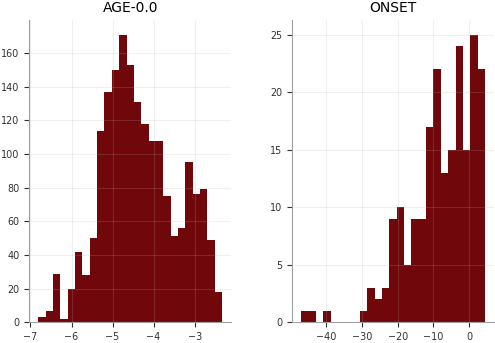

In [275]:
risk_cc[["AGE-0.0", "ONSET"]].sub(risk_cc["AGE-1.0"], axis=0).hist(bins=25)

<AxesSubplot:>

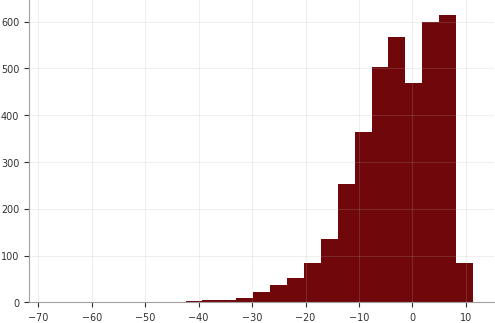

In [278]:
(risk_cc["ONSET"] - risk_cc["AGE-0.0"]).hist(bins=25)

How many risk data points did we get?

In [277]:
# risk_cc["CC"].sum()
risk_cc.count()

risk_10y-0     30619
risk_life-0    18841
risk_opt-0     30711
risk_10y-1      1341
risk_life-1      489
risk_opt-1      1345
CC             34127
ONSET           3807
AGE-0.0        34127
AGE-1.0         1870
dtype: int64

How many values did the calculator return, i.e., how continuous is it?
*Conclusion:* It has 467/30619 unique values, with most counts at low risk.

(467,)


<AxesSubplot:>

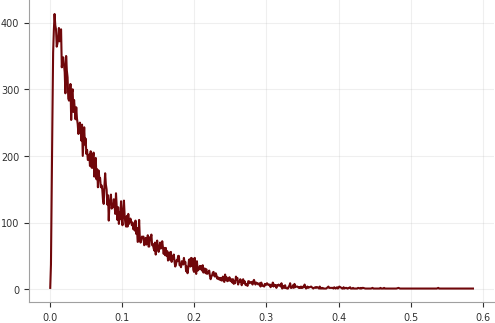

In [351]:
tmp = risk_cc["risk_10y-0"].value_counts().sort_index()
print(tmp.shape)
tmp.plot()

### Functions for analysis

In [433]:
class RiskPredictor(LinearRegression):
    
    def __init__(self, feature_df, cc_df, X_train, y_train=None,
                 non_case_only=False,
                 fit_intercept=True, normalize=False,
                 copy_X=True, n_jobs=None):
        '''non_case_only=True selects non_cases at instance 0 and predicts future status.'''
        
        super().__init__(
                        fit_intercept=fit_intercept,
                        normalize=normalize,
                        copy_X=copy_X,
                        n_jobs=n_jobs,
                        )
        self.feature_df = feature_df
        self.cc_df = cc_df
        if isinstance(X_train, dict):
            self.query_map = X_train
            X_train = self.get_X_train(X_train)
        
        self.risk_train(X_train, y_train, non_case_only)
        
    def get_X_train(self, query_map, subsample=0.95):
        tmp_eids = self.subset_to_query_map(
                    self.feature_df.loc[~self.feature_df.index.isin(pr.cohorts["eid.withinSibPairs"])].index,
                query_map)
#         tmp_cols = preds['lasso0']['cad'].train_data[0].columns
        X_train = self.feature_df.loc[tmp_eids].dropna()
        if subsample:
            X_train = X_train.sample(
                n=int(subsample * len(X_train)),
                random_state=10
            )
        return X_train
    
    def get_y(self, non_case_only, eids=None):
        y_full = pd.concat([self.cc_df, pr.age[["AGE-0.0", "AGE-1.0"]]], join="inner", axis=1)
        if eids is not None:
            y_full = y_full.loc[y_full.index.isin(eids)]
        if non_case_only:
            non_cases = (y_full["ONSET"] > y_full["AGE-0.0"]) | (y_full["CC"] == 0)
            y_full = y_full.loc[non_cases]
            
        return y_full
    
    def risk_train(self, X_train, y_train, non_case_only):
        # Subset X and y to eids in X_train that has case status
        if y_train is None:
            y_train = self.get_y(non_case_only, X_train.index)
        X_train = X_train.loc[y_train.index]
#         if non_case_only:
#             non_cases = (y_train["ONSET"] > y_train["AGE-0.0"]) | y_train["CC"] == 0
#             X_train = X_train.loc[non_cases]
#             y_train = y_train.loc[non_cases]
        
        y_train = y_train["CC"]
        if not (y_train > 0).any():
            warnings.warn(f"y_train had no positive values, only {y_train.unique()}")
        assert (X_train.index == y_train.index).all()
        # set train attributes
        self.train_eids = X_train.index
        self.train_cols = X_train.columns
        self.non_case_only = non_case_only
        # train
        self.fit(X_train, y_train)
        prs = pd.Series(self.predict(X_train), index=X_train.index)
        self.risk_map = self.make_prs_to_risk_map(prs, y_train)
        self.coef_ser = pd.Series(self.coef_, index=self.train_cols)
        
    def query_map_to_string(self, query_map):
        return " and ".join(
            [f"{c}.isin({v if isinstance(v, (list, tuple, set)) else [v]})"
                 for c, v in query_map.items()])
    
    def subset_to_query_map(self, data, query_map):
        if isinstance(data, pd.Series):
            return self.subset_to_query_map(data.to_frame(), query_map).iloc[:, 0]
        
        query = self.query_map_to_string(query_map)
        if isinstance(data, pd.Index):
            return pr.common_info.loc[data].query(query).index
        
        eids = pr.common_info.loc[data.index].query(query).index
        return data.loc[eids]
    
    def risk_predict(self, X, match_query=True, non_case_only=None):
        X = X[self.train_cols].dropna()
        if match_query and self.query_map:
            X = self.subset_to_query_map(X, self.query_map)
        if non_case_only is None:
            non_case_only = self.non_case_only
        if non_case_only:
            y = self.get_y(self.non_case_only, eids=X.index)
            X = X.loc[y.index]
        
        prs = self.prs_predict(X)
        prs['r'] = prs['prs'].apply(lambda s: self.risk_from_score(self.risk_map, s)) 
        return prs
    
    def prs_predict(self, X):
        return pd.DataFrame({"prs": self.predict(X[self.train_cols])},
                           index=X.index)
    
    def update_risk_map(self, X, delta=0.0005, win_size=2000, inplace=False):
        if not isinstance(X, pd.DataFrame):
            X = self.feature_df.loc[self.train_eids, self.train_cols]
        prs = self.prs_predict(X)
        rm = self.make_prs_to_risk_map(prs['prs'], self.cc_df.loc[X.index, "CC"],
                                      delta=delta, win_size=win_size)
        if inplace:
            self.risk_map = rm
        return rm
    
    @staticmethod
    def make_prs_to_risk_map(prs, cc, delta=0.0005, win_size=2000):
        prs = prs.sort_values()
        qs = prs.quantile(np.arange(0, 1 + delta, delta))
        prs_binned = pd.cut(prs, qs, include_lowest=True)
        data = pd.concat([prs, cc], axis=1, join='inner').set_axis(["prs", "CC"], axis=1)
        data["bins"] = prs_binned.loc[prs.index]
        data["N"] = data.groupby("bins").size().loc[data["bins"]].to_numpy()
        data["br"] = data.groupby("bins")["CC"].mean().loc[data["bins"]].to_numpy()
        data = data.sort_values('prs')
        data["r"] = data.sort_values('prs')["br"].rolling(win_size, min_periods=1, center=True, win_type='triang').mean()
        return data

    @staticmethod
    def risk_from_score(risk_map, s):
#         return risk_map['r'].iat[(risk_map['prs'] - s).abs().argsort().iat[0]]
        return risk_map.loc[(risk_map['prs'] - s).abs().idxmin(), 'r']

In [849]:
pap_bap.train_eids.shape

(185106,)

In [434]:
class BloodPredictor(RiskPredictor):
    
    def __init__(self, cc_df, X_train, y_train=None,
                 non_case_only=False,
                 fit_intercept=True, normalize=False,
                 copy_X=True, n_jobs=None):
        '''non_case_only=True selects non_cases at instance 0 and predicts future status.'''
        
        super().__init__(
                        feature_df=blood[preds['lasso0']['cad'].train_data[0].columns],
                        cc_df=cc_df,
                        X_train=X_train,
                        y_train=y_train,
                        non_case_only=non_case_only,
                        fit_intercept=fit_intercept,
                        normalize=normalize,
                        copy_X=copy_X,
                        n_jobs=n_jobs,
                        )
        


Compare online risk with cc-status risk

In [435]:
class BloodAscvdPredictor(BloodPredictor):
    
    def __init__(self, X_train, y_train=None,
                 non_case_only=False,
                 fit_intercept=True, normalize=False,
                 copy_X=True, n_jobs=None):
        '''non_case_only=True selects non_cases at instance 0 and predicts future status.'''
        
        super().__init__(
            cc_df=ascvd,
            X_train=X_train,
            y_train=y_train,
            non_case_only=non_case_only,
            fit_intercept=fit_intercept,
            normalize=normalize,
            copy_X=copy_X,
            n_jobs=n_jobs,
            )

In [436]:
def bootstrap_ci(data, func, size, n_samples=None, ci=[2.5, 97.5]):
    if n_samples is None:
        n_samples = len(data)
    samples = np.empty(size)
    np.random.seed(1)
    for i in range(size):
        samples[i] = func(resample(data, n_samples=n_samples, replace=True))
    
    conf_interval = np.percentile(samples, ci)
    return np.mean(samples), conf_interval
    
# bootstrap_ci(range(10), np.mean, 50, n_samples=10)

In [437]:
def risk_compare(data, risk_col=None, cc_col="CC", delta=0.05, cc_df=None):
    if cc_df is None:
        cc_df = ascvd
    if isinstance(data, pd.Series):
        df = pd.concat([data, cc_df.loc[data.index, "CC"]], axis=1, join='inner')
        risk_col = data.name
    elif risk_col is not None:
        df = data
    else:
        raise Exception("Need risk_col when passing df.")
        
    quantiles = np.arange(0, 1, delta)
    ret = pd.DataFrame(dtype=float)
    for q in quantiles:
        mask = (df[risk_col] >= q) & (df[risk_col] < q + delta)
        mean, conf_interval = bootstrap_ci(df.loc[mask, cc_col], np.mean, 100)
        ret.loc[q, "CC_risk"] = mean
        ret.loc[q, "CC_risk_low"] = conf_interval[0]
        ret.loc[q, "CC_risk_high"] = conf_interval[1]
        ret.loc[q, "N"] = mask.sum()
    return ret

In [438]:
# for i in range(3):
#     x = np.arange(0, 7, .1)
#     y1 = x/2 + i
#     y2 = x + np.sin(x) + i
#     plt.fill_between(x, y1, y2, alpha=0.25, edgecolor='none')

In [484]:
def plot_risk_comparison(df, risk_col=None, lim_stable=50, ref_line=True, cc_df=None, cross_val=None, **plot_kws):

    plot_risk_col = "CC_risk"
    if plot_risk_col not in df:
        df = risk_compare(df, risk_col=risk_col, cc_df=cc_df)
    df = df.dropna()
    N_min = 10
    df =  df.query("N >= @N_min")
    px = np.array([np.array((df.index.to_list() + [1]))[n:n+2].mean() for n in range(len(df))])
    py =px #+ np.diff(px).mean()/2
    if ref_line:
        plt.plot(px, py, color='0.7', label='_nolabel_')
    p = plt.plot(px, df[plot_risk_col].to_list(), **plot_kws)
    lcolor = p[0].get_color()
    if "CC_risk_low" in df:
        plt.fill_between(px, df["CC_risk_low"], df["CC_risk_high"],
                         color=lcolor, alpha=.25, edgecolor='none')
#     stable = df.query("N >= @lim_stable")
#     px_stable = [np.array((stable.index.to_list() + [1]))[n:n+2].mean() for n in range(len(stable))]
#     plt.plot(px_stable, stable[plot_risk_col].to_list(), color=lcolor, **plot_kws)

    unstable_mask = df["N"] <= lim_stable
    unstable = df.loc[unstable_mask]
    px_unstable = px[unstable_mask.to_list()]
    plt.scatter(px_unstable, unstable[plot_risk_col].to_list(), marker='o', facecolor='none', edgecolor=lcolor, zorder=4)#, 'o', color=lcolor, **plot_kws)

    if cross_val:
        i = np.argmax(px > cross_val)
        plt.scatter(px[i], df[plot_risk_col].iloc[i], marker='s', s=20, facecolor='none', edgecolor=lcolor, zorder=4)
#     plt.title("ASCVD Risk quantiles vs 'actual risk'");
    plt.xlabel("Predicted risk")
    plt.ylabel("Actual risk")

In [486]:
def compare_with_online(prs, delta=0.03, plot=True, scatter=True, lines=True, hexbins=True, cross_val=None, 
                        cmap_list=None, hex_alpha=None, joint_kws={}, lines_kws={}):
#     df = pd.concat([risk_cc, prs], axis=1)
    df = pd.concat([prs, ascvd], axis=1, join="inner")
    online_prs = pd.concat([risk_cc, prs], axis=1, join='inner')
    r_df = risk_compare(df, risk_col="r", delta=delta)
#     r_online_df = risk_compare(risk_cc.loc[risk_cc.index.isin(prs.index)], 'risk_10y-0', delta=delta)
    r_online_df = risk_compare(pr.prune(risk_cc, "ANCESTRY=='white'"), 'risk_10y-0', delta=delta)
    if plot:
        # online vs blood plot
        if scatter:
            h = sns.jointplot(data=online_prs, x="risk_10y-0", y="r",
                      marker='.', facecolor='k', edgecolors='none', alpha=.3, zorder=3, **joint_kws)
#             h.ax_marg_x.set_title("online dist.")
#             h.ax_marg_y.set_title("biomarker dist.")
            plt.sca(h.ax_joint)
           
        if hexbins:
            if cmap_list is not None:
                cmap = mpl.colors.LinearSegmentedColormap.from_list('', cmap_list)
            else:
                cmap = mpl.colors.LinearSegmentedColormap.from_list('', ['white', colors[2]])
            hex_alpha = 0.4 if hex_alpha is None else hex_alpha
            hexb = plt.hexbin(x=online_prs['risk_10y-0'], y=online_prs['r'],
                       C=online_prs.index,
#                        reduce_C_function=lambda i: risk_cc.loc[i, 'CC'].mean(),
                       reduce_C_function=hex_reduce,
                       gridsize=10,
                       alpha=hex_alpha,
                       zorder=1,
                       cmap=cmap,
                      )
        # Real vs predict risk plots
        if lines:
            plot_risk_comparison(r_df, label="BMRS", cross_val=cross_val)
            plot_risk_comparison(r_online_df, ref_line=False, label="ASCVD Risk Est.", cross_val=cross_val, **lines_kws)
   
    if hexbins:
        return online_prs, pd.concat([r_online_df, r_df], axis=1), hexb
    else:
        return online_prs, pd.concat([r_online_df, r_df], axis=1)

hex_bin_list = []
def hex_reduce(i):
    hex_bin_list.append(i)
    ret = risk_cc.loc[i, 'CC'].mean()
    return ret
# compare_with_online(bap_preds[('white', 1, False)]);
# plt.legend()

In [440]:
def query_map(t):
    return {"ANCESTRY": t[0], "SEX": t[1] if t[1] < 2 else [0, 1]}

In [441]:
def get_query_map(df):
    index = df if isinstance(df, pd.Index) else df.index
    ret = {
        "ANCESTRY": list(pr.ancestry.loc[pr.ancestry.index.isin(index), "ANCESTRY"].unique()),
        "SEX": list(pr.sex.loc[pr.sex.index.isin(index), "SEX"].unique()),
    }
    return ret

### Load SNP predictors

In [442]:
class SNPRiskPredictor():
    def __init__(self, cc_df, prs_file=None, prs_col=None, prs_ser=None, query_map=None, non_case_only=None):
        # Borrow functions
        self.make_prs_to_risk_map = BloodPredictor.make_prs_to_risk_map
        self.risk_from_score = BloodPredictor.risk_from_score
        self.subset_to_query_map = BloodPredictor.subset_to_query_map
        self.get_y = BloodPredictor.get_y
        # Setup prs data
        if prs_file is not None and prs_col is not None:
            prs = pd.read_csv(prs_file, sep=" ")
            prs = prs.set_index(next(c for c in prs if c.lower() == "eid"))[prs_col]
        elif prs_ser is not None:
            prs = prs_ser
        else:
#             raise Exception("No prs_file-prs_col combo nor prs_ser.")
            prs = pd.read_csv("path/to/ascvdBetas.csv", sep=" ")
            prs = prs.set_index(next(c for c in prs if c.lower() == "eid")).iloc[:, :4].mean(axis=1)
        
        if isinstance(query_map, dict):
            prs = self.local_subset_to_query_map(prs, query_map)
            self.query_map = query_map

        if non_case_only is not None:
            self.non_case_only = non_case_only
        self.prs = prs
        self.cc_df = cc_df
        self.risk_map = self.make_prs_to_risk_map(prs, self.cc_df["CC"])
        
    def query_map_to_string(self, query_map):
        return " and ".join(
            [f"{c}.isin({v if isinstance(v, (list, tuple, set)) else [v]})"
                 for c, v in query_map.items()])
    
    def local_subset_to_query_map(self, data, query_map):
        if isinstance(data, pd.DataFrame):
            data = self.subset_to_query_map(self, data, query_map)
        else:
            data = self.subset_to_query_map(self, data.to_frame(), query_map).iloc[:, 0]
        return data
    
    def risk_predict(self, prs, match_query=True, non_case_only=None):
        prs = prs.to_frame().copy()
        if match_query and self.query_map:
            prs = self.local_subset_to_query_map(prs, self.query_map)
        if non_case_only is None:
            non_case_only = self.non_case_only
        if non_case_only:
            y = self.get_y(self, self.non_case_only, eids=prs.index)
            prs = prs.loc[prs.index]
        
        prs['r'] = prs.iloc[:, 0].apply(lambda s: self.risk_from_score(self.risk_map, s)) 
        return prs

In [443]:
sib_pred = pd.read_csv("path/to/sibling-evaluation-set.csv", sep=" ").set_index("EID")

In [444]:
sib_pred["PRED_MEAN"] = sib_pred.filter(like="PRED").mean(axis=1)

In [445]:
sib_pred["PRED_MEAN4"] = sib_pred.filter(like="PRED").iloc[:, :4].mean(axis=1)

#### Create SNP risk predictors

In [75]:
saps = {}
sap_preds = {}
start = time()
first_start = start
for a in ['white']:
    for s in [0, 1, 2]:
        for nco in [False, True]:
            t = (a, s, nco)
            print_tmp(t, "time: ", time() - start, ". total time:", time() - first_start)
            start = time()
            saps[t] = SNPRiskPredictor(cc_df=ascvd, query_map=query_map(t), non_case_only=nco)

('white', 2, True) time:  5.10817551612854 . total time: 17.048713445663452


Evaluate on sibs, but match on training conditions.

In [76]:
sap_preds = {}
start = time()
first_start = start
for t, sap in saps.items():
    print_tmp(t, "time: ", time() - start, ". total time:", time() - first_start)
    start = time()
    sap_preds[t] = sap.risk_predict(sib_pred["PRED_MEAN4"])

('white', 2, True) time:  107.57251405715942 . total time: 221.65621876716614


In [79]:
# pickle.dump([saps, sap_preds], open("saps_sap_preds.p", 'wb'))

In [446]:
saps, sap_preds = pickle.load(open("saps_sap_preds.p", "rb"))

### Systematic predictors

Train ASCVD predictor on
- only whites
- sex
    - all
    - men
    - women
- CC
    - all
    - no case at instance 0
- columns
    - all

Use convention: (ancestry, sex, non_case_only) where ancestry is the string, sex is 0, 1, 2 for female, male, all, and non_case_only is bool.

In [82]:
baps = {}
bap_preds = {}
start = time()
first_start = start
for a in ['white']:
    for s in [0, 1, 2]:
        for nco in [False, True]:
            t = (a, s, nco)
            print_tmp(t, "time: ", time() - start, ". total time:", time() - first_start)
            start = time()
            baps[t] = BloodAscvdPredictor(query_map(t), non_case_only=nco)
#             bap_preds[t] = baps[t]

('white', 2, True) time:  3.1710851192474365 . total time: 12.589104652404785


Evaluate on everyone not in training, but match on training conditions.

In [83]:
bap_preds = {}
start = time()
first_start = start
for t, bap in baps.items():
    print_tmp(t, "time: ", time() - start, ". total time:", time() - first_start)

    testX = blood.loc[
        ~blood.index.isin(bap.train_eids)
        ][bap.train_cols].dropna()
    start = time()
    bap_preds[t] = bap.risk_predict(testX)

('white', 2, True) time:  34.609121322631836 . total time: 76.38647246360779


In [85]:
# pickle.dump([baps, bap_preds], open("baps_bap_preds.p", "wb"))

#### Plot comparisons

Train predictor for paper. Use
- white, both sexes and both cases and controls
Smooth $r(prs)$ manually.

In [447]:
bap_blood2 = z_score(blood2)

In [448]:
t = ('white', 2, False)
start = time()
pap_bap = RiskPredictor(
    feature_df=bap_blood2[pap_preds['cad'][0][0].train_cols],
    cc_df=ascvd,
    X_train=query_map(t), non_case_only=False)
print(time() - start)

3.544046640396118


In [450]:
pr.ancestry.loc[pap_bap.train_eids, "ANCESTRY"].unique(), len(pap_bap.train_cols)

(array(['white'], dtype=object), 62)

Smooth $r(prs)$ by (1) using two different windowings in rolling average, and (2) pick a subset and make linear interpolation.

In [451]:
rms = {ws: pap_bap.update_risk_map(None, win_size=ws) for ws in [5000, 6000, 9000]}

In [452]:
pap_bap.risk_map['orig_r'] = pap_bap.risk_map['r']
pap_bap.risk_map['r'] = pap_bap.risk_map['orig_r'].combine(rms[9000]['r'], lambda x,y: x if x > 0.53 else y)

In [453]:
from scipy.interpolate import make_interp_spline

In [454]:
len(pap_bap.risk_map)

185101

In [457]:
idx = np.hstack([np.arange(0, 100, 1), np.arange(100, 183150, 2000), np.arange(185101-800, 185101, 2)])
rm = pap_bap.risk_map
rm_sp = make_interp_spline(rm['prs'].iloc[idx], rm['r'].iloc[idx], 1)

In [458]:
rm['r'] = rm_sp(rm['prs'])

<AxesSubplot:xlabel='prs'>

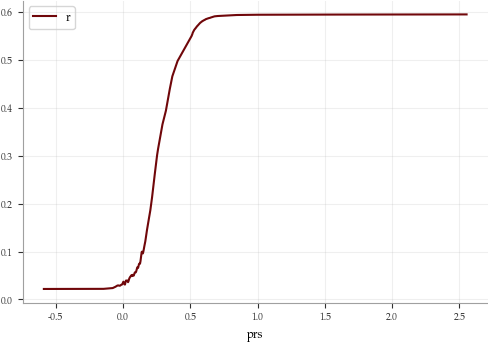

In [459]:
# ax = baps[t].risk_map.plot(x='prs', y='r', alpha=0.5)
# pap_bap.risk_map.plot(x='prs', y='r', ax=ax)
pap_bap.risk_map.plot(x='prs', y='r')#, ax=ax)
# rms[9000].plot(x='prs', y='r', ax=ax, label=str(ws))
# n =0
# for ws in rms:
#     n += 1
#     rms[ws].plot(x='prs', y='r', label=str(ws))
# # plt.plot(xdata, sigmoid(xdata, .56, *popt[1:]))
#     plt.xlim([0, 0.5])

In [460]:
pap_bap_pred = pap_bap.risk_predict(pap_bap.feature_df.loc[~pap_bap.feature_df.index.isin(pap_bap.train_eids)])

In [483]:
# pickle.dump(pap_bap, open("VarsBiomarkersV2/pap_bap.p", "wb"))
# pickle.dump(pap_bap_pred, open("VarsBiomarkersV2/pap_bap_pred.p", "wb"))

In [448]:
pap_bap = pickle.load(open("VarsBiomarkersV2/pap_bap.p", "rb"))
pap_bap_pred = pickle.load(open("VarsBiomarkersV2/pap_bap_pred.p", "rb"))

In [461]:
tmp_eids = risk_cc.index.intersection(pap_bap_pred.index)
roc_auc_score(risk_cc.loc[tmp_eids, "CC"], pap_bap_pred.loc[tmp_eids, 'prs'])

0.7615399265320667

In [527]:
pr.ancestry.loc[tmp_eids, "ANCESTRY"].unique(), pr.ancestry.loc[pap_bap_pred.index, "ANCESTRY"].unique(), 

(array(['white'], dtype=object), array(['white'], dtype=object))

Manually use spline instead of risk lookup.

In [1038]:
# pap_bap_pred['r_orig'] = pap_bap_pred['r']

# pap_bap_pred['r'] = rm_sp(pap_bap_pred['prs'])

In [464]:
delta = 0.03
cross_val = 0.1

In [465]:
fsize = inch(237, 237)

In [ ]:
fig = plt.figure(figsize=fsize);
t = ('white', 2, False)
compare_with_online(pap_bap_pred, scatter=False, delta=delta, cross_val=cross_val, hexbins=False)
plot_risk_comparison(sap_preds[t]['r'], ref_line=False, label="PRS")
plt.legend();
plt.tight_layout(pad=0, h_pad=0, w_pad=0);
print(my_mpl_height())

In [488]:
# fig.savefig("FiguresV2/ascvd_risk_compare.pdf")

In [ ]:
# fig = plt.subplots(figsize=fsize);
compare_with_online(pap_bap_pred, lines=False, scatter=True, hexbins=True, delta=delta, joint_kws={'height': 1.1725*fsize[1]})
#     plt.suptitle(baps[t].query_map_to_string(baps[t].query_map) + f": {'non-cases' if baps[t].non_case_only else 'all'}")
xs = plt.xlim()
ys = plt.ylim()
width = 0.03
o_rect = mpatches.Rectangle((cross_val, 0), width, ys[1], linewidth=1, edgecolor=colors[1], facecolor=colors[1], alpha=0.3, zorder=4)
b_rect = mpatches.Rectangle((0, cross_val), xs[1], width, linewidth=1, edgecolor=colors[0], facecolor=colors[0], alpha=0.2, zorder=4)
plt.gca().add_patch(o_rect)
plt.gca().add_patch(b_rect)
plt.tight_layout();
plt.xlabel('Risk acc. to ASCVD Risk Est.')
plt.ylabel('Risk acc. to BMRS')
fig = plt.gcf()
plt.tight_layout(pad=0, h_pad=0, w_pad=0);
print(my_mpl_height())

In [490]:
# fig.savefig("FiguresV2/ascvd_scatter.pdf")

In [ ]:
hex_bin_list = []
fig = plt.figure(figsize=inch(285, 250))
_, _, hexb = compare_with_online(pap_bap_pred, lines=False, scatter=False, hexbins=True, delta=delta, joint_kws={'height': 1.1725*fsize[1]},
                   cmap_list=colors[[1,0]], hex_alpha=1);
for n, pt in enumerate(hexb.get_offsets()):
    plt.text(pt[0], pt[1], str(len(hex_bin_list[n])), fontsize='x-small',
#             ha='center', va='center', alpha=0.5, color='k')
#             ha='center', va='center', alpha=0.9, color=colors[3])
            ha='center', va='center', alpha=1.0, color='k')

plt.gca().grid(False)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Actual risk', rotation=270, labelpad=9)
plt.xlabel('Risk acc. to ASCVD Risk Est.')
plt.ylabel('Risk acc. to BMRS')
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
print(my_mpl_height())

In [492]:
# fig.savefig("FiguresV2/ascvd_heat_map_black10.pdf")

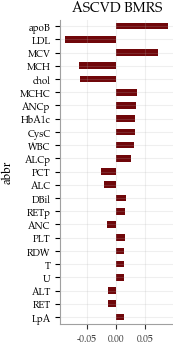

In [493]:
# fig, axs = plt.subplots(1, 2, figsize=inch(250, 250))
fsize = inch(125, 250)
pap_bap.coef_ser.rename(index=new_abbr_map).rename(index=lambda l: re.sub("-.*", "", l))\
    .sort_values(key=np.abs).tail(23).plot.barh(figsize=fsize)
plt.gca().tick_params(axis='y', colors='k')
plt.title(r"ASCVD BMRS")
plt.tight_layout(pad=0, h_pad=0, w_pad=0);
fig = plt.gcf()

In [494]:
# fig.savefig("FiguresV2/ascvd_betas_top.pdf")

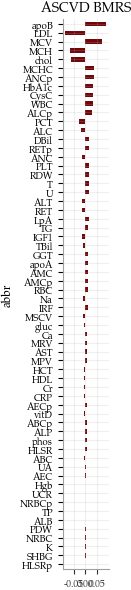

In [496]:
# fig, axs = plt.subplots(1, 2, figsize=inch(250, 250))
# fsize = inch(125, 350)
fsize = inch(100, 450) #fsize_fullBeta
pap_bap.coef_ser.rename(index=new_abbr_map).rename(index=lambda l: re.sub("-.*", "", l))\
    .sort_values(key=np.abs).plot.barh(figsize=fsize)
plt.gca().tick_params(axis='y', colors='k')
plt.title(r"ASCVD BMRS")
plt.tight_layout();
fig = plt.gcf()

In [497]:
fig.savefig("FiguresV2/ascvd_betas.pdf", bbox_inches="tight")

##### Check normality of PRS

In [472]:
from scipy.stats import kstest

In [477]:
pap_bap_pred.groupby(risk_cc["CC"])["prs"].agg(lambda s: kstest(s, "norm"))

CC
0.0    (0.45575368053114174, 0.0)
1.0       (0.47726216540824, 0.0)
Name: prs, dtype: object

CC
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: prs, dtype: object

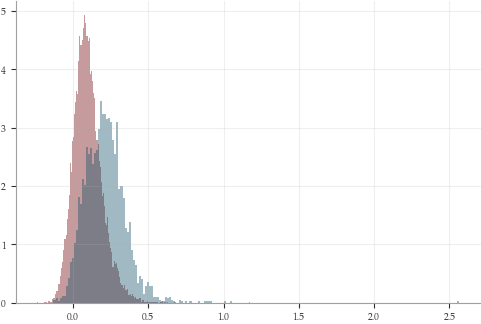

In [482]:
pap_bap_pred.groupby(risk_cc["CC"])["prs"].hist(bins=200, alpha=.4, density=True)

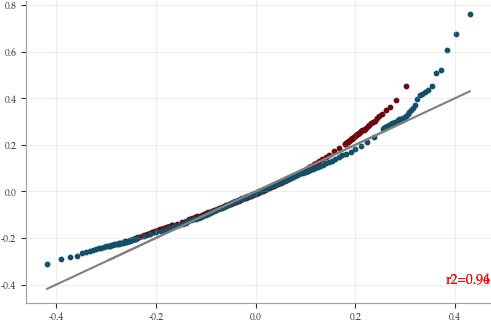

In [481]:
for _, g in pap_bap_pred.groupby(risk_cc["CC"]):
    my_qq(g["prs"])

### Using both online and blood markers

In [498]:
ascvd_input = pd.read_csv("path/to/ascvd-input.csv", sep=" ").set_index("eid")

In [500]:
ascvd_combo = pd.concat([pr.select_instance(ascvd_input, 0), blood2[pap_preds['cad'][0][0].train_cols], risk_cc['risk_10y-0']], axis=1, join='inner').dropna()

In [501]:
ascvd_combo = ascvd_combo.drop(columns=[
    'tchol-0.0',
    'hdl-0.0',
    'ldl-0.0',])

In [502]:
ascvd_combo = ascvd_combo.query("ANCESTRY=='white'").drop(columns='ANCESTRY')

In [503]:
pr.ancestry.loc[ascvd_combo.index, 'ANCESTRY'].unique()

array(['white'], dtype=object)

In [504]:
ascvd_combo = z_score(ascvd_combo)

Risk map has two extra humps because of the discrete variables. Especially aspirin, statin and hyperTreat have large impact and are heavily enriched in top humps.

In [505]:
cap = RiskPredictor(feature_df=ascvd_combo, cc_df=ascvd, X_train=query_map(('white', 2, True)), non_case_only=False)

In [506]:
start = time()
cap_pred = cap.risk_predict(ascvd_combo)
print(time() - start)

171.27754545211792


In [507]:
len(cap_pred)

187771

Do one without risk from online

In [508]:
cap_no_r = RiskPredictor(feature_df=ascvd_combo.drop(columns='risk_10y-0'), cc_df=ascvd, X_train=query_map(('white', 2, True)), non_case_only=False)

In [509]:
start = time()
cap_no_r_pred = cap_no_r.risk_predict(ascvd_combo)
print(time() - start)

171.4786455631256


In [510]:
# pickle.dump(cap, open('VarsBiomarkersV2/cap.p', 'wb'))
# pickle.dump(cap_pred, open('VarsBiomarkersV2/cap_pred.p', 'wb'))
# pickle.dump(cap_no_r, open('VarsBiomarkersV2/cap_no_r.p', 'wb'))
# pickle.dump(cap_no_r_pred, open('VarsBiomarkersV2/cap_no_r_pred.p', 'wb'))

In [475]:
cap = pickle.load(open("cap.p", "rb"))
cap_pred = pickle.load(open("cap_pred.p", "rb"))
cap_no_r = pickle.load(open("cap_no_r.p", "rb"))
cap_no_r_pred = pickle.load(open("cap_no_r_pred.p", "rb"))

In [1174]:
# pd.concat([ascvd_combo.loc[crm.query("prs > 0.2").index].mean().sort_index(), ascvd_combo.mean().sort_index()], axis=1)

In [250]:
tmps = pd.Series(cap.coef_, index=cap.train_cols)
tmps.sort_values(key=np.abs, ascending=False).head(10)

hdl-0.0         6.601781e+10
hdl            -6.601781e+10
chol           -3.776129e+10
tchol-0.0       3.776129e+10
ldl-0.0        -1.039700e+09
ldl             1.039700e+09
aspirin-0       7.152063e-02
statin-0        5.407667e-02
hyperTreat-0    2.820206e-02
risk_10y-0      2.511215e-02
dtype: float64

Smooth risk map by hand...

In [511]:
crm = cap.risk_map

In [513]:
crm.shape

(162852, 6)

In [514]:
idx = np.hstack([np.arange(0, 125000, 5), np.arange(125000, 162852 - 36000, 2000), np.arange(162852-7000, 162852, 4)])
crm_sp = make_interp_spline(crm['prs'].iloc[idx], crm['r'].iloc[idx], 1)

In [515]:
crm['r_orig'] = crm['r']
crm['r'] = crm_sp(crm['prs'])

In [516]:
crm["r_sp"] = crm["r"]
crm["r"] = crm["r_orig"]

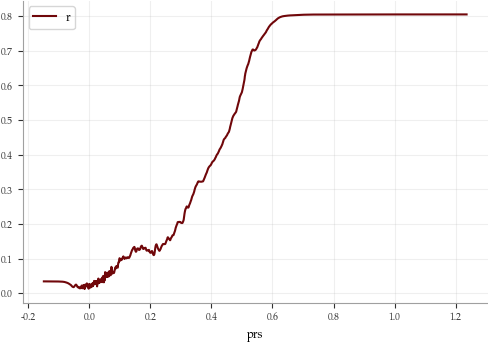

In [517]:
ax = cap.risk_map.plot(x='prs', y='r')
# plt.plot(crm['prs'].to_list(), crm_sp(crm['prs']))

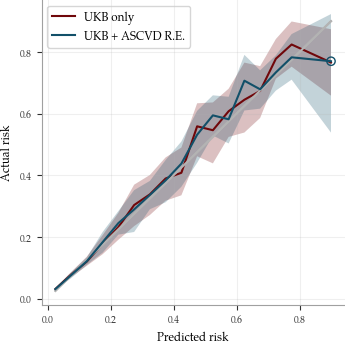

In [525]:
# cap.risk_map.plot.scatter(x='prs', y='r', s=1, alpha=.1)
fig = plt.figure(figsize=inch(250, 250))
eids = pr.ancestry.loc[pr.ancestry.index.isin(pr.cohorts['eid.withinSibPairs'])].query("ANCESTRY=='white'").index
plot_risk_comparison(cap_no_r_pred.loc[cap_no_r_pred.index.isin(eids), 'r'], label='UKB only')#, plot_kws={"figsize": inch(250, 250)})
plot_risk_comparison(cap_pred.loc[cap_pred.index.isin(eids), 'r'], label='UKB + ASCVD R.E.')#, linestyle=":")
plt.legend();
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
# plt.title("Combined ASCVD")

In [526]:
# fig.savefig("FiguresV2/ascvd_combo_risk_compare.pdf")

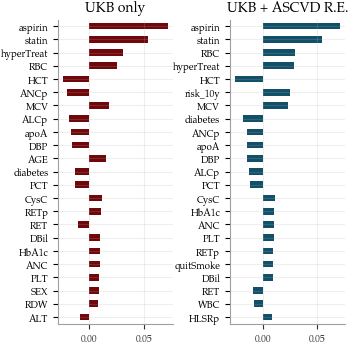

In [519]:
fig, axs = plt.subplots(1, 2, figsize=inch(250, 250))
cap_no_r.coef_ser.rename(index=new_abbr_map).rename(index=lambda l: re.sub("-.*", "", l)).sort_values(key=np.abs).tail(23).plot.barh(ax=axs[0])
axs[0].tick_params(axis='y', colors='k')
axs[0].set_title(r"UKB only")
cap.coef_ser.rename(index=new_abbr_map).rename(index=lambda l: re.sub("-.*", "", l)).sort_values(key=np.abs).tail(23).plot.barh(ax=axs[1], color=colors[1])
axs[1].tick_params(axis='y', colors='k')
axs[1].set_title(r"UKB + ASCVD R.E.")
plt.tight_layout(pad=0, h_pad=0, w_pad=0);

In [520]:
# fig.savefig("FiguresV2/ascvd_combo_betas_top.pdf")

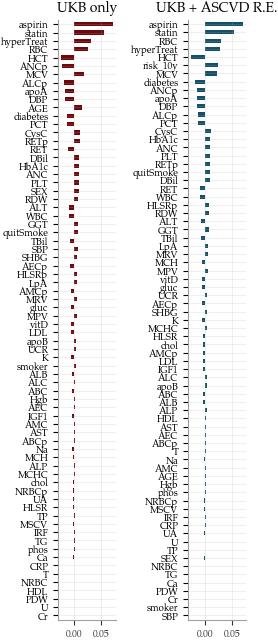

In [522]:
fsize = inch(200, 300 * (62 + 11)/45)
fig, axs = plt.subplots(1, 2, figsize=fsize)
cap_no_r.coef_ser.rename(index=new_abbr_map).rename(index=lambda l: re.sub("-.*", "", l)).sort_values(key=np.abs).plot.barh(ax=axs[0])
axs[0].tick_params(axis='y', colors='k')
axs[0].set_title(r"UKB only")
cap.coef_ser.rename(index=new_abbr_map).rename(index=lambda l: re.sub("-.*", "", l)).sort_values(key=np.abs).plot.barh(ax=axs[1], color=colors[1])
axs[1].tick_params(axis='y', colors='k')
axs[1].set_title(r"UKB + ASCVD R.E.")
plt.tight_layout();

In [523]:
# fig.savefig("FiguresV2/ascvd_combo_betas.pdf", bbox_inches="tight")

#### Check if touchscreen heart attack is the same as noncancer

There is an overlap of questions between noncancer question at verbal interview and the touchscreen questions about diseases. Is the info the same?

*Conclusion:* No. It is not identical. There is a very strong agreement but there are a few exceptions.

In [196]:
# pr.codes_containing("noncancer", "eart")
tmp = pr.case_control_status({"noncancer": [1075]})

In [200]:
mtmp = pd.concat([tmp, heart_attack_cust], axis=1)

In [203]:
mtmp.loc[(mtmp > 0).any(axis=1)]

,noncancer,CC,ONSET,CUSTOM,CC,ONSET
eid,,,,,,
1000335,1,1,45.5,1.0,1,45.0
1000397,1,1,63.5,1.0,1,-1.0
1001410,1,1,50.5,1.0,1,50.0
1001651,1,1,49.5,1.0,1,49.0
1002331,2,1,57.5,2.0,1,57.0
...,...,...,...,...,...,...
6024781,1,1,49.5,1.0,1,49.0
6025899,0,0,NaN,0.0,0,67.0
6025965,1,1,59.5,1.0,1,59.0


In [207]:
print(tmp["noncancer"].count(), heart_attack_cust["CUSTOM"].count())
ctmp = tmp["noncancer"] == heart_attack_cust["CUSTOM"]

502489 502489


## ASCVD on age alone

In [372]:
sib_eids = pr.cohorts['eid.withinSibPairs']

In [373]:
tmpX = ascvd_combo.loc[~ascvd_combo.index.isin(sib_eids), "AGE-0.0"]
tmpy = risk_cc.loc[tmpX.index, "CC"]
aap = pr.poly_regression(tmpX, tmpy, deg=1)

In [376]:
tmpyp = aap.predict(ascvd_combo.loc[ascvd_combo.index.isin(sib_eids), "AGE-0.0"])

In [378]:
roc_auc_score(risk_cc.loc[tmpyp.index, "CC"], tmpyp)

0.6870681890584589

## Does high lipoA => ASCVD

In [687]:
# pdf = scores.loc["lipoA"].filter(regex=r"PHEN|SCORE_\d")
pdf = proc_phen[["lipoA_orig", "lipoA"]]
cdf = risk_cc["CC"]
_eids = pdf.index.intersection(cdf.index)
ascvd_lipoA_or = pd.DataFrame()
for col in pdf:
    ascvd_lipoA_or[col] = calc_or(pdf[col].loc[_eids], cdf.loc[_eids])

<AxesSubplot:>

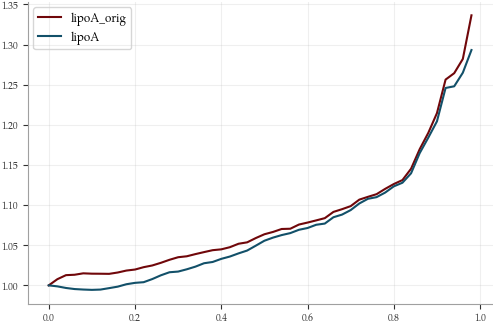

In [688]:
ascvd_lipoA_or.plot()